In [1]:
import os  
os.getcwd()#----------------------------------------View the current working directory

'/home/jovyan/work/dissertation/dohouse'

## 1. Install and load packages

In [2]:
!pip install xlwt
!pip install geopandas shapely
!pip install geopandas matplotlib
!pip install python-louvain
!pip install matplotlib numpy
!pip install basemap

In [3]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import networkx as nx
import numpy as np
import os
import community as community_louvain  
import glob
import xlrd
import warnings
import random
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.lines import Line2D
from matplotlib import rcParams
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely import wkt
from scipy.spatial import distance_matrix
from scipy import interpolate
import scipy.stats as stats
import scipy

## 2. data

### 2.1 Spatial Boundary Vector Data of 41 Cities in the YRD

In [4]:
# Load data
ply = gpd.read_file('data/41shp/YRD.shp')
ply.head()

adcode      name  center  centroid  childrenNu     level  parent  \
0  310000  Shanghai       0         0          16  province       0   
1  330100  Hangzhou       0         0          13      city       0   
2  330200    Ningbo       0         0          10      city       0   
3  330300   Wenzhou       0         0          12      city       0   
4  330400   Jiaxing       0         0           7      city       0   

   subFeature  acroutes                                           geometry  
0           8         0  MULTIPOLYGON (((120.90135 31.01733, 120.89088 ...  
1           0         0  POLYGON ((120.72194 30.28633, 120.69394 30.262...  
2           1         0  MULTIPOLYGON (((120.86702 30.27173, 120.91604 ...  
3           2         0  MULTIPOLYGON (((121.10841 28.13901, 121.09020 ...  
4           3         0  POLYGON ((120.72194 30.28633, 120.71087 30.297...

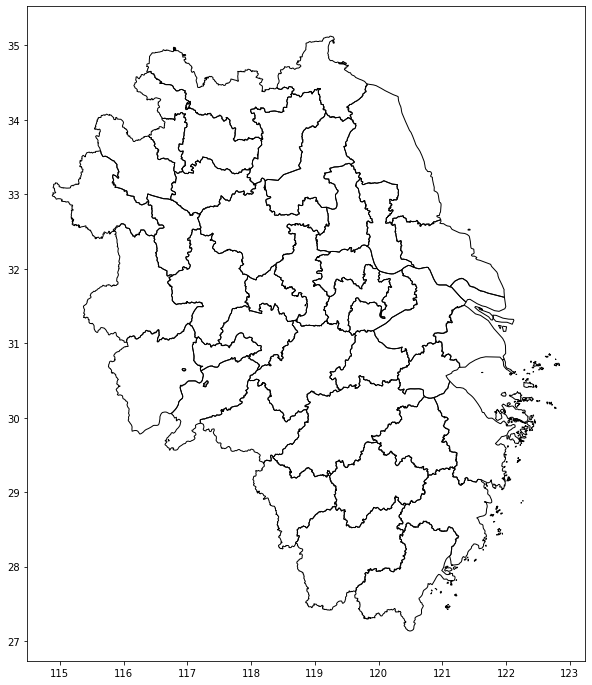

In [5]:
# Plot inspection
ply.plot(figsize = (10,15), facecolor = "None", edgecolor = "black")
plt.show()

In [6]:
# View coordinates
ply.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# View details
ply.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   adcode      41 non-null     int64   
 1   name        41 non-null     object  
 2   center      41 non-null     int64   
 3   centroid    41 non-null     int64   
 4   childrenNu  41 non-null     int64   
 5   level       41 non-null     object  
 6   parent      41 non-null     int64   
 7   subFeature  41 non-null     int64   
 8   acroutes    41 non-null     int64   
 9   geometry    41 non-null     geometry
dtypes: geometry(1), int64(7), object(2)
memory usage: 3.3+ KB


In [8]:
# Modify column names

# Define column name mapping dictionary
column_mapping = {
    'adcode': 'code',
    'name': 'city',
}

ply = ply.rename(columns=column_mapping)

# Delete columns
ply = ply.drop(columns=['center', 'centroid','childrenNu', 'parent', 'subFeature', 'acroutes', 'level'])
ply.head(5)

code      city                                           geometry
0  310000  Shanghai  MULTIPOLYGON (((120.90135 31.01733, 120.89088 ...
1  330100  Hangzhou  POLYGON ((120.72194 30.28633, 120.69394 30.262...
2  330200    Ningbo  MULTIPOLYGON (((120.86702 30.27173, 120.91604 ...
3  330300   Wenzhou  MULTIPOLYGON (((121.10841 28.13901, 121.09020 ...
4  330400   Jiaxing  POLYGON ((120.72194 30.28633, 120.71087 30.297...

In [9]:
# Sort
ply = ply.sort_values('code')
ply = ply.reset_index(drop=True)
ply.head(5)

code       city                                           geometry
0  310000   Shanghai  MULTIPOLYGON (((120.90135 31.01733, 120.89088 ...
1  320100    Nanjing  MULTIPOLYGON (((119.06745 32.46240, 119.04702 ...
2  320200       Wuxi  POLYGON ((119.53262 31.15911, 119.54300 31.175...
3  320300     Xuzhou  POLYGON ((118.40820 34.43551, 118.41522 34.420...
4  320400  Changzhou  POLYGON ((120.02242 31.96777, 120.00766 31.947...

In [10]:
#extract the centroids
ply["Centroids"] = ply.geometry.centroid

/tmp/ipykernel_27531/3636410495.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ply["Centroids"] = ply.geometry.centroid


In [11]:
ply.head(5)

code       city                                           geometry  \
0  310000   Shanghai  MULTIPOLYGON (((120.90135 31.01733, 120.89088 ...   
1  320100    Nanjing  MULTIPOLYGON (((119.06745 32.46240, 119.04702 ...   
2  320200       Wuxi  POLYGON ((119.53262 31.15911, 119.54300 31.175...   
3  320300     Xuzhou  POLYGON ((118.40820 34.43551, 118.41522 34.420...   
4  320400  Changzhou  POLYGON ((120.02242 31.96777, 120.00766 31.947...   

                    Centroids  
0  POINT (121.48663 31.20863)  
1  POINT (118.84816 31.92578)  
2  POINT (120.08033 31.52198)  
3  POINT (117.52264 34.35425)  
4  POINT (119.64157 31.62297)

In [12]:
ply.set_index('code', inplace=True, drop=True)

distances_cert = ply.rename_axis('Orig').Centroids.apply(lambda x:ply.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
# Change the column name of the first column in the 'distances' DataFrame to 'Dist' and perform the modification on the original DataFrame.
distances_cert.rename(columns = {0:'Dist_cert'}, inplace=True)
distances_cert.sort_values(by=["Orig", "Dest"], inplace = True)

ply.reset_index(inplace=True)
print(distances_cert)

/tmp/ipykernel_27531/2564543729.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances_cert = ply.rename_axis('Orig').Centroids.apply(lambda x:ply.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
/tmp/ipykernel_27531/2564543729.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances_cert = ply.rename_axis('Orig').Centroids.apply(lambda x:ply.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
/tmp/ipykernel_27531/2564543729.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances_cert = ply.rename_axis('Orig').Centroids.appl

        Orig    Dest  Dist_cert
0     310000  310000   0.000000
1     310000  320100   2.734189
2     310000  320200   1.440786
3     310000  320300   5.060452
4     310000  320400   1.891013
...      ...     ...        ...
1676  341800  341300   3.573810
1677  341800  341500   2.797628
1678  341800  341600   3.833867
1679  341800  341700   1.541129
1680  341800  341800   0.000000

[1681 rows x 3 columns]


/tmp/ipykernel_27531/2564543729.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances_cert = ply.rename_axis('Orig').Centroids.apply(lambda x:ply.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
/tmp/ipykernel_27531/2564543729.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances_cert = ply.rename_axis('Orig').Centroids.apply(lambda x:ply.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
/tmp/ipykernel_27531/2564543729.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances_cert = ply.rename_axis('Orig').Centroids.appl

In [13]:
distances_cert

Orig    Dest  Dist_cert
0     310000  310000   0.000000
1     310000  320100   2.734189
2     310000  320200   1.440786
3     310000  320300   5.060452
4     310000  320400   1.891013
...      ...     ...        ...
1676  341800  341300   3.573810
1677  341800  341500   2.797628
1678  341800  341600   3.833867
1679  341800  341700   1.541129
1680  341800  341800   0.000000

[1681 rows x 3 columns]

### 2.2  Point Data of 41 Cities in the YRD

In [14]:
# Disable warning messages
warnings.filterwarnings("ignore")

# Create an empty GeoDataFrame to store city point data
points = gpd.GeoDataFrame()

# Create a dictionary containing the capital city names, their corresponding latitude and longitude coordinates, and city codes
cities = {
    'Shanghai': (121.49618479502924, 31.23534996403915, '310000'),
    'Nanjing': (118.79810948650803, 32.07091729742433, '320100'),
    'Wuxi': (120.31538262853158, 31.495251277424444, '320200'),
    'Xuzhou': (117.26962544900873, 34.20795655459594, '320300'),
    'Changzhou': (119.96382016684471, 31.814383013458134, '320400'),
    'Suzhou(Jiangsu)': (120.59484732430482, 31.30067171945164, '320500'),
    'Nantong': (120.88630160812416, 31.982151503792537, '320600'),
    'Lianyungang': (119.22499013119368, 34.5985011934673, '320700'),
    'Huaian': (119.10375460333188, 33.59620434222326, '320800'),
    'Yancheng': (120.17288792899795, 33.35749846892217, '320900'),
    'Yangzhou': (119.41500529163262, 32.39266724141492, '321000'),
    'Zhenjiang': (119.43188454052368, 32.19140382245529, '321100'),
    'Taizhou(Jiangsu)': (119.94139144840565, 32.460093019152595, '321200'),
    'Suqian': (118.27842240181741, 33.966336316299056, '321300'),
    'Hangzhou': (120.1333706893233, 30.281140435312192, '330100'),
    'Ningbo': (121.54447776428383, 29.87027335855557, '330200'),
    'Wenzhou': (120.6905532634919, 28.000742183602576, '330300'),
    'Jiaxing': (120.75071575088229, 30.759567147326614, '330400'),
    'Huzhou': (120.09833994429816, 30.893738754172396, '330500'),
    'Shaoxing': (120.5928319383869, 29.99768109051572, '330600'),
    'Jinhua': (119.65161793526376, 29.077296982473282, '330700'),
    'Quzhou': (118.87891970426045, 28.939402824139663, '330800'),
    'Zhoushan': (122.20937235586594, 29.985153759652267, '330900'),
    'Taizhou(Zhejiang)': (121.42156803219437, 28.66335926319306, '331000'),
    'Lishui': (119.92052006740165, 28.467314115059033, '331100'),
    'Hefei': (117.24298733296291, 31.823918874783807, '340100'),
    'Wuhu': (118.43809371405099, 31.35366046755121, '340200'),
    'Bengbu': (117.38601368037298, 32.92080395981401, '340300'),
    'Huainan': (117.00432071468354, 32.624832102281246, '340400'),
    'Maanshan': (118.50332514224408, 31.67444298502585, '340500'),
    'Huaibei': (116.79426487624504, 33.95817268744104, '340600'),
    'Tongling': (117.81394539713166, 30.94591865044175, '340700'),
    'Anqing': (117.06344189462348, 30.544334110761923, '340800'),
    'Huangshan': (118.34150906427334, 29.71658410440849, '341000'),
    'Chuzhou': (118.32627798288283, 32.25744070311455, '341100'),
    'Fuyang': (115.81167500329035, 32.89033829865164, '341200'),
    'Suzhou(Anhui)': (116.96523957044613, 33.64127091663737, '341300'),
    'Luan': (116.52372617822671, 31.73674262583971, '341500'),
    'Bozhou': (115.77838492553809, 33.84512771219232, '341600'),
    'Chizhou': (117.49130559410162, 30.66433513467605, '341700'),
    'Xuancheng': (118.75550810199641, 30.941918634279862, '341800'), 
}

# Add the information of each city to the GeoDataFrame
for city, coordinates in cities.items():
    lon, lat, code = coordinates
    point = Point(lon, lat)
    points = points.append({'city': city, 'geometry': point, 'code': code}, ignore_index=True)

# Convert the DataFrame to a GeoDataFrame
points = gpd.GeoDataFrame(points, geometry='geometry')

# Set the coordinate system of the GeoDataFrame.
points.crs = 'EPSG:4326'  

# Save the point data as a Shapefile
points.to_file('data/points_shp/points.shp')

In [15]:
point = gpd.read_file('data/points_shp/points.shp')
point.head()

city    code                    geometry
0   Shanghai  310000  POINT (121.49618 31.23535)
1    Nanjing  320100  POINT (118.79811 32.07092)
2       Wuxi  320200  POINT (120.31538 31.49525)
3     Xuzhou  320300  POINT (117.26963 34.20796)
4  Changzhou  320400  POINT (119.96382 31.81438)

### 2.3 datafram

#### 2.3.1 Calculting a distance matrix

In [16]:
# To parse coordinates in the 'geometry' column
point['geometry'] = point['geometry'].apply(lambda x: wkt.loads(str(x)))
coords = point['geometry'].apply(lambda p: (p.x, p.y)).tolist()

# Calculate the distance matrix
dist_matrix = distance_matrix(coords, coords)

# Create a result DataFrame
distances = pd.DataFrame({
    'Orig': np.repeat(point['code'], len(point)),
    'Dest': np.tile(point['code'], len(point)),
    'Dist': dist_matrix.flatten()
})

# Sort by 'Orig' and 'Dest'
distances = distances.sort_values(by=['Orig', 'Dest'])

# Reindex
distances.reset_index(drop=True, inplace=True)
distances

Orig    Dest      Dist
0     310000  310000  0.000000
1     310000  320100  2.824497
2     310000  320200  1.209067
3     310000  320300  5.167223
4     310000  320400  1.638115
...      ...     ...       ...
1676  341800  341300  3.239068
1677  341800  341500  2.369092
1678  341800  341600  4.158351
1679  341800  341700  1.294319
1680  341800  341800  0.000000

[1681 rows x 3 columns]

In [17]:
#ply

#### 2.3.2 datafram处理

In [18]:
#Modify the Excel files for the 41 cities by adding origin and destination columns

# Disable warning messages
warnings.filterwarnings("ignore")

folder_path = 'data/flowdata_out'  # Folder path
output_folder = os.path.join(folder_path, 'modified_files')  # Output folder path
new_column_names = {'城市代码': 'DestCode', '迁出目的地': 'DestCity'}  # Column name mapping relationship

# Create an output folder
os.makedirs(output_folder, exist_ok=True)

for file_name in os.listdir(folder_path):
    if file_name.endswith('.xls'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        
        # Modify column names
        df = df.rename(columns=new_column_names)
        
        # Add columns
        orig_city = file_name.split('-')[0]
        dest_city_code = df.loc[df['DestCity'] == orig_city, 'DestCode'].iloc[0]  
        df['OrigCity'] = orig_city
        df['OrigCode'] = dest_city_code
        
        # Calculate the 'Total' column
        non_sum_cols = ['OrigCode', 'DestCode']
        df['Total'] = df.drop(columns=non_sum_cols).sum(axis=1)
        
        # Adjust column order
        column_order = ['OrigCode', 'OrigCity', 'DestCode', 'DestCity', 'Total'] + [col for col in df.columns if col not in non_sum_cols + ['Total', 'OrigCity', 'DestCity']]
        df = df.reindex(columns=column_order)
        df
        
        # Save the modified file
        new_file_name = file_name.split('.')[0] + '_modified.xls'
        new_file_path = os.path.join(output_folder, new_file_name)
        df.to_excel(new_file_path, index=False)


In [19]:
#Extract study area data

# Disable warning messages
warnings.filterwarnings("ignore")

# Folder path and file format
folder_path = 'data/flowdata_out/modified_files'
file_format = 'xls'

# Read all files in the folder
file_list = [file for file in os.listdir(folder_path) if file.endswith(file_format)]

for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    
    # Read Excel files
    df = pd.read_excel(file_path)
    
    # Extract rows that meet the condition
    df_filtered = df[df['DestCode'].astype(str).str[:2].isin(['31', '32', '33', '34'])]
    
    df_filtered.to_excel(file_path, index=False)

In [20]:
# Merge all XLS files into a single CSV file


# Get the file paths of all XLS files
file_paths = glob.glob('data/flowdata_out/modified_files/*.xls')

# Create an empty DataFrame to store all the data
all_data = pd.DataFrame()

# Define a counter for numbering
counter = 1

# Read each XLS file one by one and merge it into the all data DataFrame.
for file_path in file_paths:
    df = pd.read_excel(file_path, engine='xlrd')  
    
    df.insert(0, 'No', range(counter, counter + df.shape[0]))
    counter += df.shape[0]
    
    all_data = all_data.append(df, ignore_index=True)

all_data.sort_values(['OrigCode', 'DestCode'], inplace=True, ascending=[True, True])

all_data['No'] = range(1, all_data.shape[0] + 1)

# Save path for the merged data
save_path = 'data/flowdata_out/modified_files/merged_data.csv'

# When saving the merged data as a CSV file, specify the encoding as GBK
all_data.to_csv(save_path, index=False, encoding='GBK')

print("Merge is complete and saved as merged_data.csv file.")

Merge is complete and saved as merged_data.csv file.


In [21]:
#datafram
df = pd.read_csv('data/flowdata_out/modified_files/merged_data.csv', encoding='GBK')
df

No  OrigCode OrigCity  DestCode DestCity   Total  20220901  20220902  \
0        1    310000      上海市    310000      上海市    0.00      0.00      0.00   
1        2    310000      上海市    320100      南京市  143.10      2.65      2.65   
2        3    310000      上海市    320200      无锡市  222.70      3.35      3.64   
3        4    310000      上海市    320300      徐州市   36.77      0.72      0.59   
4        5    310000      上海市    320400      常州市  113.36      1.81      1.97   
...    ...       ...      ...       ...      ...     ...       ...       ...   
1676  1677    341800      宣城市    341300      宿州市   22.41      0.31      0.43   
1677  1678    341800      宣城市    341500      六安市   43.64      0.56      0.78   
1678  1679    341800      宣城市    341600      亳州市   18.52      0.25      0.28   
1679  1680    341800      宣城市    341700      池州市   89.46      1.27      1.10   
1680  1681    341800      宣城市    341800      宣城市    0.00      0.00      0.00   

      20220903  20220904  ...  20221022  20221023  20221024  20221025  \
0         0.00      0.00  ...      0.00      0.00      0.00      0.00   
1         2.98      2.48  ...      2.11      1.75      2.26      2.17   
2         3.86      3.30  ...      4.55      3.71      4.32      4.07   
3         0.61      0.69  ...      0.45      0.45      0.42      0.49   
4         2.00      1.67  ...      2.33      1.81      2.02      2.06   
...        ...       ...  ...       ...       ...       ...       ...   
1676      0.64      0.47  ...      0.32      0.18      0.26      0.35   
1677      0.68      0.61  ...      0.52      0.59      0.52      0.56   
1678      0.63      0.38  ...      0.24      0.20      0.13      0.20   
1679      1.51      0.98  ...      1.71      1.34      1.48      1.62   
1680      0.00      0.00  ...      0.00      0.00      0.00      0.00   

      20221026  20221027  20221028  20221029  20221030  20221031  
0         0.00      0.00      0.00      0.00      0.00      0.00  
1         2.15      2.04      1.96      1.84      1.61      1.86  
2         4.36      4.39      4.64      4.63      3.89      4.05  
3         0.52      0.51      0.47      0.45      0.52      0.54  
4         2.05      2.09      2.20      2.26      1.84      1.92  
...        ...       ...       ...       ...       ...       ...  
1676      0.35      0.36      0.43      0.52      0.30      0.35  
1677      0.79      0.68      0.62      0.63      0.60      0.69  
1678      0.20      0.22      0.32      0.28      0.26      0.17  
1679      1.55      1.34      1.75      1.75      1.68      1.58  
1680      0.00      0.00      0.00      0.00      0.00      0.00  

[1681 rows x 68 columns]

In [22]:
# Delete the specified columns
columns_to_drop = ['20220931','20221019', '20221020', '20221021', '20221022', '20221023', '20221024', '20221025', '20221026', '20221027', '20221028', '20221029', '20221030', '20221031']
df = df.drop(columns=columns_to_drop)
df

No  OrigCode OrigCity  DestCode DestCity   Total  20220901  20220902  \
0        1    310000      上海市    310000      上海市    0.00      0.00      0.00   
1        2    310000      上海市    320100      南京市  143.10      2.65      2.65   
2        3    310000      上海市    320200      无锡市  222.70      3.35      3.64   
3        4    310000      上海市    320300      徐州市   36.77      0.72      0.59   
4        5    310000      上海市    320400      常州市  113.36      1.81      1.97   
...    ...       ...      ...       ...      ...     ...       ...       ...   
1676  1677    341800      宣城市    341300      宿州市   22.41      0.31      0.43   
1677  1678    341800      宣城市    341500      六安市   43.64      0.56      0.78   
1678  1679    341800      宣城市    341600      亳州市   18.52      0.25      0.28   
1679  1680    341800      宣城市    341700      池州市   89.46      1.27      1.10   
1680  1681    341800      宣城市    341800      宣城市    0.00      0.00      0.00   

      20220903  20220904  ...  20221009  20221010  20221011  20221012  \
0         0.00      0.00  ...      0.00      0.00      0.00      0.00   
1         2.98      2.48  ...      2.02      2.18      2.31      2.46   
2         3.86      3.30  ...      3.34      3.75      3.34      3.50   
3         0.61      0.69  ...      0.57      0.51      0.53      0.51   
4         2.00      1.67  ...      1.63      1.80      1.83      1.80   
...        ...       ...  ...       ...       ...       ...       ...   
1676      0.64      0.47  ...      0.29      0.19      0.18      0.21   
1677      0.68      0.61  ...      0.53      0.50      0.47      0.64   
1678      0.63      0.38  ...      0.21      0.16      0.37      0.21   
1679      1.51      0.98  ...      1.85      1.49      1.49      1.65   
1680      0.00      0.00  ...      0.00      0.00      0.00      0.00   

      20221013  20221014  20221015  20221016  20221017  20221018  
0         0.00      0.00      0.00      0.00      0.00      0.00  
1         2.51      2.54      2.71      2.08      2.50      2.12  
2         3.52      3.72      3.71      3.28      3.89      3.87  
3         0.54      0.45      0.45      0.46      0.43      0.46  
4         1.93      2.00      2.07      1.73      1.97      2.07  
...        ...       ...       ...       ...       ...       ...  
1676      0.28      0.19      0.28      0.24      0.23      0.30  
1677      0.73      0.90      0.61      0.58      0.70      0.56  
1678      0.25      0.25      0.21      0.21      0.13      0.15  
1679      1.69      1.78      1.71      1.34      1.58      1.60  
1680      0.00      0.00      0.00      0.00      0.00      0.00  

[1681 rows x 54 columns]

In [23]:
# Calculate the 'Total' for the specified date range and replace the original 'Total' column
start_column = '20220901'
end_column = '20221018'

df['Total'] = df.loc[:, start_column:end_column].sum(axis=1)


In [24]:
df

No  OrigCode OrigCity  DestCode DestCity   Total  20220901  20220902  \
0        1    310000      上海市    310000      上海市    0.00      0.00      0.00   
1        2    310000      上海市    320100      南京市  117.28      2.65      2.65   
2        3    310000      上海市    320200      无锡市  167.67      3.35      3.64   
3        4    310000      上海市    320300      徐州市   30.50      0.72      0.59   
4        5    310000      上海市    320400      常州市   86.10      1.81      1.97   
...    ...       ...      ...       ...      ...     ...       ...       ...   
1676  1677    341800      宣城市    341300      宿州市   18.27      0.31      0.43   
1677  1678    341800      宣城市    341500      六安市   35.70      0.56      0.78   
1678  1679    341800      宣城市    341600      亳州市   15.62      0.25      0.28   
1679  1680    341800      宣城市    341700      池州市   68.95      1.27      1.10   
1680  1681    341800      宣城市    341800      宣城市    0.00      0.00      0.00   

      20220903  20220904  ...  20221009  20221010  20221011  20221012  \
0         0.00      0.00  ...      0.00      0.00      0.00      0.00   
1         2.98      2.48  ...      2.02      2.18      2.31      2.46   
2         3.86      3.30  ...      3.34      3.75      3.34      3.50   
3         0.61      0.69  ...      0.57      0.51      0.53      0.51   
4         2.00      1.67  ...      1.63      1.80      1.83      1.80   
...        ...       ...  ...       ...       ...       ...       ...   
1676      0.64      0.47  ...      0.29      0.19      0.18      0.21   
1677      0.68      0.61  ...      0.53      0.50      0.47      0.64   
1678      0.63      0.38  ...      0.21      0.16      0.37      0.21   
1679      1.51      0.98  ...      1.85      1.49      1.49      1.65   
1680      0.00      0.00  ...      0.00      0.00      0.00      0.00   

      20221013  20221014  20221015  20221016  20221017  20221018  
0         0.00      0.00      0.00      0.00      0.00      0.00  
1         2.51      2.54      2.71      2.08      2.50      2.12  
2         3.52      3.72      3.71      3.28      3.89      3.87  
3         0.54      0.45      0.45      0.46      0.43      0.46  
4         1.93      2.00      2.07      1.73      1.97      2.07  
...        ...       ...       ...       ...       ...       ...  
1676      0.28      0.19      0.28      0.24      0.23      0.30  
1677      0.73      0.90      0.61      0.58      0.70      0.56  
1678      0.25      0.25      0.21      0.21      0.13      0.15  
1679      1.69      1.78      1.71      1.34      1.58      1.60  
1680      0.00      0.00      0.00      0.00      0.00      0.00  

[1681 rows x 54 columns]

#### 2.3.3 得到最终的datafram

In [25]:
#Add the distance column to the DataFrame
df = df.merge(distances['Dist'], left_index=True, right_index=True)
df = df.merge(distances_cert['Dist_cert'], left_index=True, right_index=True)
df

No  OrigCode OrigCity  DestCode DestCity   Total  20220901  20220902  \
0        1    310000      上海市    310000      上海市    0.00      0.00      0.00   
1        2    310000      上海市    320100      南京市  117.28      2.65      2.65   
2        3    310000      上海市    320200      无锡市  167.67      3.35      3.64   
3        4    310000      上海市    320300      徐州市   30.50      0.72      0.59   
4        5    310000      上海市    320400      常州市   86.10      1.81      1.97   
...    ...       ...      ...       ...      ...     ...       ...       ...   
1676  1677    341800      宣城市    341300      宿州市   18.27      0.31      0.43   
1677  1678    341800      宣城市    341500      六安市   35.70      0.56      0.78   
1678  1679    341800      宣城市    341600      亳州市   15.62      0.25      0.28   
1679  1680    341800      宣城市    341700      池州市   68.95      1.27      1.10   
1680  1681    341800      宣城市    341800      宣城市    0.00      0.00      0.00   

      20220903  20220904  ...  20221011  20221012  20221013  20221014  \
0         0.00      0.00  ...      0.00      0.00      0.00      0.00   
1         2.98      2.48  ...      2.31      2.46      2.51      2.54   
2         3.86      3.30  ...      3.34      3.50      3.52      3.72   
3         0.61      0.69  ...      0.53      0.51      0.54      0.45   
4         2.00      1.67  ...      1.83      1.80      1.93      2.00   
...        ...       ...  ...       ...       ...       ...       ...   
1676      0.64      0.47  ...      0.18      0.21      0.28      0.19   
1677      0.68      0.61  ...      0.47      0.64      0.73      0.90   
1678      0.63      0.38  ...      0.37      0.21      0.25      0.25   
1679      1.51      0.98  ...      1.49      1.65      1.69      1.78   
1680      0.00      0.00  ...      0.00      0.00      0.00      0.00   

      20221015  20221016  20221017  20221018      Dist  Dist_cert  
0         0.00      0.00      0.00      0.00  0.000000   0.000000  
1         2.71      2.08      2.50      2.12  2.824497   2.734189  
2         3.71      3.28      3.89      3.87  1.209067   1.440786  
3         0.45      0.46      0.43      0.46  5.167223   5.060452  
4         2.07      1.73      1.97      2.07  1.638115   1.891013  
...        ...       ...       ...       ...       ...        ...  
1676      0.28      0.24      0.23      0.30  3.239068   3.573810  
1677      0.61      0.58      0.70      0.56  2.369092   2.797628  
1678      0.21      0.21      0.13      0.15  4.158351   3.833867  
1679      1.71      1.34      1.58      1.60  1.294319   1.541129  
1680      0.00      0.00      0.00      0.00  0.000000   0.000000  

[1681 rows x 56 columns]

In [26]:
# Variable data
flowdata = pd.read_csv("data/Variables.csv")
flowdata.head()

number  district      city    code  population  GDP growth rate  \
0       1  Shanghai  Shanghai  310000    24894300              8.1   
1       2  Zhejiang    Huzhou  330500     3367579              9.5   
2       3  Zhejiang  Hangzhou  330100    11936010              8.5   
3       4  Zhejiang   Jiaxing  330400     5400868              8.5   
4       5  Zhejiang  Shaoxing  330600     5270977              8.7   

   house rate  higher education institutions   Income growth rate  tourist  \
0    0.191131                              64            0.078391       71   
1    0.291872                               4            0.101064       28   
2    0.572755                              47            0.931930       47   
3    0.570047                               6            0.089124       14   
4    1.007255                               8            0.096066       19   

   industrial enterprises  star hotel  density of highway  
0                    9300         177              206.33  
1                    4082          25              141.74  
2                    6528          78              100.82  
3                    6818          29              193.89  
4                    4944          26              126.14

In [27]:
# Incorporate variable data
df = pd.merge(df, flowdata, left_on='OrigCode', right_on='code', how='left', suffixes=('_Orig','_Dest'))
df = pd.merge(df, flowdata, left_on='DestCode', right_on='code', how='left', suffixes=('_Orig','_Dest'))
df = df.drop(['number_Orig','district_Orig','city_Orig','code_Orig','number_Dest','district_Dest','city_Dest','code_Dest'],axis = 1)
df

No  OrigCode OrigCity  DestCode DestCity   Total  20220901  20220902  \
0        1    310000      上海市    310000      上海市    0.00      0.00      0.00   
1        2    310000      上海市    320100      南京市  117.28      2.65      2.65   
2        3    310000      上海市    320200      无锡市  167.67      3.35      3.64   
3        4    310000      上海市    320300      徐州市   30.50      0.72      0.59   
4        5    310000      上海市    320400      常州市   86.10      1.81      1.97   
...    ...       ...      ...       ...      ...     ...       ...       ...   
1676  1677    341800      宣城市    341300      宿州市   18.27      0.31      0.43   
1677  1678    341800      宣城市    341500      六安市   35.70      0.56      0.78   
1678  1679    341800      宣城市    341600      亳州市   15.62      0.25      0.28   
1679  1680    341800      宣城市    341700      池州市   68.95      1.27      1.10   
1680  1681    341800      宣城市    341800      宣城市    0.00      0.00      0.00   

      20220903  20220904  ...  density of highway_Orig  population_Dest  \
0         0.00      0.00  ...                   206.33         24894300   
1         2.98      2.48  ...                   206.33          9319700   
2         3.86      3.30  ...                   206.33          7464000   
3         0.61      0.69  ...                   206.33          9083900   
4         2.00      1.67  ...                   206.33          5279600   
...        ...       ...  ...                      ...              ...   
1676      0.64      0.47  ...                   106.70          5325000   
1677      0.68      0.61  ...                   106.70          4405000   
1678      0.63      0.38  ...                   106.70          4986000   
1679      1.51      0.98  ...                   106.70          1331000   
1680      0.00      0.00  ...                   106.70          2487000   

      GDP growth rate_Dest  house rate_Dest  \
0                     8.10         0.191131   
1                     7.50         0.018579   
2                     8.80         0.848554   
3                     8.70         0.533353   
4                     9.10         0.842599   
...                    ...              ...   
1676                  6.00         0.299644   
1677                 15.21         0.121458   
1678                  9.23         0.408087   
1679                 15.57         0.586287   
1680                 14.08         0.570385   

      higher education institutions _Dest  Income growth rate_Dest  \
0                                      64                 0.078391   
1                                      51                 0.089411   
2                                      13                 0.089146   
3                                      12                 0.088452   
4                                      11                 0.087446   
...                                   ...                      ...   
1676                                    4                 0.084485   
1677                                    4                 0.093500   
1678                                    2                 0.092479   
1679                                    3                 0.086515   
1680                                    1                 0.094510   

      tourist_Dest  industrial enterprises_Dest  star hotel_Dest  \
0               71                         9300              177   
1               27                         3975               60   
2               30                         7721               29   
3               20                         2557               15   
4               13                         5662               30   
...            ...                          ...              ...   
1676             7                         1081                5   
1677            26                         1179               14   
1678             9                          656               10   
1679            18                          627             

In [28]:
# Modify city names

# Create a dictionary for mapping between Chinese and English names
chinese_to_english = {
    "上海市": "Shanghai","湖州市": "Huzhou","杭州市": "Hangzhou","嘉兴市": "Jiaxing",
    "绍兴市": "Shaoxing","宁波市": "Ningbo","金华市": "Jinhua","台州市": "Taizhou(Zhejiang)",
    "温州市": "Wenzhou","舟山市": "Zhoushan","衢州市": "Quzhou","丽水市": "Lishui",
    "盐城市": "Yancheng","扬州市": "Yangzhou","泰州市": "Taizhou(Jiangsu)","南通市": "Nantong",
    "南京市": "Nanjing","镇江市": "Zhenjiang","常州市": "Changzhou","无锡市": "Wuxi",
    "苏州市": "Suzhou(Jiangsu)","连云港市": "Lianyungang","淮安市": "Huaian","宿迁市": "Suqian",
    "徐州市": "Xuzhou","滁州市": "Chuzhou","合肥市": "Hefei","马鞍山市": "Maanshan",
    "芜湖市": "Wuhu","铜陵市": "Tongling","宣城市": "Xuancheng","安庆市": "Anqing",
    "池州市": "Chizhou","蚌埠市": "Bengbu","淮北市": "Huaibei","淮南市": "Huainan",
    "宿州市": "Suzhou(Anhui)","阜阳市": "Fuyang","亳州市": "Bozhou","六安市": "Luan",
    "黄山市": "Huangshan",
}

df['OrigCity'] = df['OrigCity'].replace(chinese_to_english)
df['DestCity'] = df['DestCity'].replace(chinese_to_english)


In [29]:
#df

In [30]:
# Ignore internal city migration data

# Filter and delete rows in which the 'Dist' column values are 0
df = df[df['Dist'] != 0]

# Sort by the values in the 'OrigCode' and 'DestCode' columns in ascending order
df = df.sort_values(by=['OrigCode', 'DestCode'], ascending=True)

# Update the values in the 'No' column
df['No'] = range(1, len(df) + 1)
df

No  OrigCode   OrigCity  DestCode         DestCity    Total  20220901  \
1        1    310000   Shanghai    320100          Nanjing   117.28      2.65   
2        2    310000   Shanghai    320200             Wuxi   167.67      3.35   
3        3    310000   Shanghai    320300           Xuzhou    30.50      0.72   
4        4    310000   Shanghai    320400        Changzhou    86.10      1.81   
5        5    310000   Shanghai    320500  Suzhou(Jiangsu)  1189.11     24.75   
...    ...       ...        ...       ...              ...      ...       ...   
1675  1636    341800  Xuancheng    341200           Fuyang    19.83      0.41   
1676  1637    341800  Xuancheng    341300    Suzhou(Anhui)    18.27      0.31   
1677  1638    341800  Xuancheng    341500             Luan    35.70      0.56   
1678  1639    341800  Xuancheng    341600           Bozhou    15.62      0.25   
1679  1640    341800  Xuancheng    341700          Chizhou    68.95      1.27   

      20220902  20220903  20220904  ...  density of highway_Orig  \
1         2.65      2.98      2.48  ...                   206.33   
2         3.64      3.86      3.30  ...                   206.33   
3         0.59      0.61      0.69  ...                   206.33   
4         1.97      2.00      1.67  ...                   206.33   
5        26.31     27.84     26.64  ...                   206.33   
...        ...       ...       ...  ...                      ...   
1675      0.43      0.46      0.40  ...                   106.70   
1676      0.43      0.64      0.47  ...                   106.70   
1677      0.78      0.68      0.61  ...                   106.70   
1678      0.28      0.63      0.38  ...                   106.70   
1679      1.10      1.51      0.98  ...                   106.70   

      population_Dest  GDP growth rate_Dest  house rate_Dest  \
1             9319700                  7.50         0.018579   
2             7464000                  8.80         0.848554   
3             9083900                  8.70         0.533353   
4             5279600                  9.10         0.842599   
5            12749600                  8.70         0.240529   
...               ...                   ...              ...   
1675          8171000                  9.49         0.085865   
1676          5325000                  6.00         0.299644   
1677          4405000                 15.21         0.121458   
1678          4986000                  9.23         0.408087   
1679          1331000                 15.57         0.586287   

      higher education institutions _Dest  Income growth rate_Dest  \
1                                      51                 0.089411   
2                                      13                 0.089146   
3                                      12                 0.088452   
4                                      11                 0.087446   
5                                      26                 0.083448   
...                                   ...                      ...   
1675                                    6                 0.081506   
1676                                    4                 0.084485   
1677                                    4                 0.093500   
1678                                    2                 0.092479   
1679                                    3                 0.086515   

      tourist_Dest  industrial enterprises_Dest  star hotel_Dest  \
1               27                         3975               60   
2               30                         7721               29   
3               20                         2557               15   
4               13                         5662               30   
5               40                        12493               63   
...            ...                          ...              ...   
1675             7                         1571                4   
1676             7                         1081                5

In [31]:
# Above, we have obtained the final DataFrame

In [32]:
summary_stats = df.describe()
summary_stats

No       OrigCode       DestCode        Total     20220901  \
count  1640.000000    1640.000000    1640.000000  1640.000000  1640.000000   
mean    820.500000  330987.804878  330987.804878   102.308921     2.108720   
std     473.571536    9116.644832    9116.644832   223.289514     4.688882   
min       1.000000  310000.000000  310000.000000     0.110000     0.000000   
25%     410.750000  321000.000000  321000.000000     9.892500     0.200000   
50%     820.500000  330700.000000  330700.000000    23.425000     0.500000   
75%    1230.250000  340600.000000  340600.000000    78.717500     1.682500   
max    1640.000000  341800.000000  341800.000000  2157.430000    44.900000   

          20220902     20220903     20220904     20220905     20220906  ...  \
count  1640.000000  1640.000000  1640.000000  1640.000000  1640.000000  ...   
mean      2.125768     2.151610     2.141000     2.138494     2.118683  ...   
std       4.663126     4.656545     4.820331     4.880968     4.717904  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.200000     0.190000     0.180000     0.190000     0.200000  ...   
50%       0.500000     0.500000     0.465000     0.470000     0.490000  ...   
75%       1.782500     1.810000     1.630000     1.612500     1.662500  ...   
max      45.220000    44.580000    46.760000    49.410000    43.850000  ...   

       density of highway_Orig  population_Dest  GDP growth rate_Dest  \
count              1640.000000     1.640000e+03           1640.000000   
mean                154.587073     5.740573e+06              9.718293   
std                  35.389383     4.193174e+06              2.941507   
min                  88.720000     1.157817e+06              0.010000   
25%                 126.940000     3.211000e+06              8.400000   
50%                 152.750000     4.601000e+06              8.970000   
75%                 186.390000     7.464000e+06             10.100000   
max                 217.680000     2.489430e+07             16.130000   

       house rate_Dest  higher education institutions _Dest  \
count      1640.000000                          1640.000000   
mean          0.503617                            11.292683   
std           0.273041                            14.832387   
min           0.003505                             1.000000   
25%           0.294575                             4.000000   
50%           0.528228                             6.000000   
75%           0.680488                            10.000000   
max           1.007255                            64.000000   

       Income growth rate_Dest  tourist_Dest  industrial enterprises_Dest  \
count              1640.000000   1640.000000                  1640.000000   
mean                  0.110466     19.073171                  3395.658537   
std                   0.130086     12.816612                  2925.617809   
min                   0.078391      3.000000                   425.000000   
25%                   0.084879      9.000000                  1179.000000   
50%                   0.089492     18.000000                  2288.000000   
75%                   0.094987     25.000000                  5281.000000   
max                   0.931930     71.000000                 12493.000000   

       star hotel_Dest  density of highway_Dest  
count      1640.000000              1640.000000  
mean         29.073171               154.587073  
std          28.943900                35.389383  
min           3.000000                88.720000  
25%          12.000000               126.940000  
50%          24.000000               152.750000  
75%          33.000000               186.390000  
max         177.000000               217.680000  

[8 rows x 72 columns]

In [33]:
# Check whether the population flow data are normally distributed

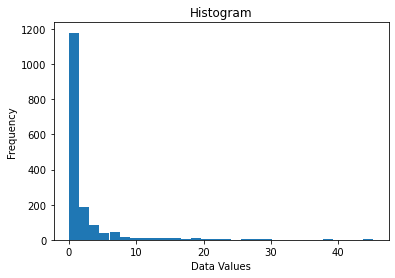

In [34]:
# Plotting the histogram
plt.hist(df['20220902'], bins=30)
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.title('Histogram')

# save
plt.savefig('Migration Flow Data Distribution Histogram.jpg', dpi=300)
plt.show()

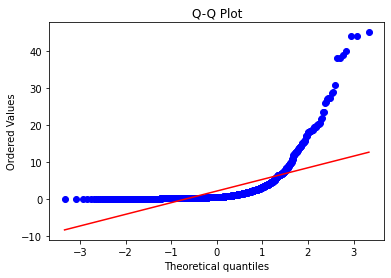

In [35]:
# Plotting the Q-Q plot
stats.probplot(df['20220902'], dist='norm', plot=plt)
plt.title('Q-Q Plot')

# save
plt.savefig('Quantile-Quantile Plot.jpg', dpi=300)
plt.show()

In [36]:
cdatasubmat = pd.pivot_table(df, values ="Total", index="OrigCity", columns = "DestCity",
                            aggfunc=np.sum, margins=True)
cdatasubmat

DestCity            Anqing   Bengbu   Bozhou  Changzhou  Chizhou  Chuzhou  \
OrigCity                                                                    
Anqing                 NaN    44.86    23.55      29.07   430.29    48.55   
Bengbu               41.29      NaN   200.43      41.97    27.31   910.85   
Bozhou               28.71   238.32      NaN      45.49    19.13    75.37   
Changzhou            11.53    17.21    16.95        NaN    13.21    34.41   
Chizhou             750.21    41.48    24.47      54.12      NaN    41.49   
Chuzhou              35.89   657.01    35.22      60.75    20.56      NaN   
Fuyang               35.49    89.77   564.92      44.02    21.70    56.00   
Hangzhou             16.49    11.09    12.42      27.76     9.35    10.39   
Hefei               307.32   183.57   144.70      35.13   105.40   267.73   
Huaian                5.96    24.99     7.07     137.04     4.78   156.22   
Huaibei              17.54   148.14   398.19      23.10    13.05    67.30   
Huainan              52.19   301.51   180.23      20.94    31.37   161.66   
Huangshan           109.28    46.34    23.82      38.33   208.02    43.14   
Huzhou               34.73    10.95    13.57      68.61     8.55    14.76   
Jiaxing              11.47    10.00     8.85      29.71     7.84    10.24   
Jinhua                9.51    11.22    17.47      21.01     4.89    12.73   
Lianyungang           4.61    10.13     6.87     117.57     3.25    17.77   
Lishui                4.52     3.40     2.73      10.46     2.99     4.32   
Luan                157.33    57.40    47.19      47.00    36.02    52.83   
Maanshan             48.94    34.20    26.59      59.35    46.00   135.66   
Nanjing              24.23    44.31    28.54     218.10    21.16   345.11   
Nantong               7.14    17.63    14.37     134.81     4.75    21.32   
Ningbo               17.37    18.32    28.50      33.82     6.35    18.16   
Quzhou                7.78     6.68     4.20      15.06     6.99     5.24   
Shanghai             23.71    25.80    21.72      86.10    15.86    26.74   
Shaoxing              6.65     7.99     8.48      16.28     4.56     7.61   
Suqian                5.42    42.11     9.59     128.64     3.56    55.84   
Suzhou(Anhui)        18.45   314.11    84.87      41.06    11.11    77.22   
Suzhou(Jiangsu)      13.15    15.76    18.51     163.65     9.91    30.26   
Taizhou(Jiangsu)      5.40     9.91     7.00     251.20     5.80    24.34   
Taizhou(Zhejiang)     6.72    18.38    20.21      23.37     6.45    11.78   
Tongling            705.86    34.79    16.27      69.87   677.10    36.76   
Wenzhou              11.88    11.57    20.33      19.52     7.79    10.85   
Wuhu                108.35    50.27    30.39      60.87   135.46    69.73   
Wuxi                 10.42    16.47    16.23     980.91     8.80    29.40   
Xuancheng            50.58    29.63    15.62     263.69    68.95    43.17   
Xuzhou                9.05    32.62    22.60      86.00     5.96    32.47   
Yancheng              4.70     7.76     5.30     144.60     4.19    19.75   
Yangzhou              9.26    18.28     9.22     182.49     6.62   197.38   
Zhenjiang             7.60    15.44     9.67     936.50     8.42    48.57   
Zhoushan              5.66     5.23     8.96      24.63     8.44     5.89   
All                2742.39  2684.65  2155.82    4792.60  2041.94  3239.01   

DestCity            Fuyang  Hangzhou     Hefei   Huaian  ...  Wenzhou  \
OrigCity                                                 ...            
Anqing               36.58    132.57   1358.28     6.88  ...    23.40   
Bengbu               96.74     83.27    747.99    29.77  ...    19.66   
Bozhou              672.15     95.74    674.24     8.85  ...    36.46   
Changzhou            20.07     82.53     53.42    65.26  ...    12.69   
Chizhou              34.71    139.89    746.05     8.35  ...    30.11   
Chuzhou              36.44     52.71    752.73   147.79  ...    11.35   
Fuyang                 NaN 

## 3. Visualization and descriptive statistics

### 3.1 Migration Flow Temporal Dynamics

#### 3.1.1 calculate outflow data

In [37]:
# Group by origin city
orig_city_total = df.groupby('OrigCity', as_index=False).sum()
# List of column names to retain
columns_to_keep = [
    'OrigCity', 'Total','20220901','20220902','20220903','20220904','20220905','20220906',
    '20220907','20220908','20220909','20220910','20220911','20220912','20220913', 
    '20220914','20220915','20220916','20220917','20220918','20220919','20220920',
    '20220921','20220922','20220923','20220924','20220925','20220926','20220927',
    '20220928','20220929','20220930','20221001','20221002','20221003','20221004',
    '20221005','20221006','20221007','20221008','20221009','20221010','20221011',
    '20221012','20221013','20221014','20221015','20221016','20221017','20221018',
                  ]

orig_city_keep = orig_city_total[columns_to_keep]
orig_city_keep.head()

OrigCity    Total  20220901  20220902  20220903  20220904  20220905  \
0     Anqing  3831.12     79.48     81.28     82.28     80.86     81.39   
1     Bengbu  4287.73     88.59     90.06     90.62     90.03     88.65   
2     Bozhou  3596.80     78.62     80.31     80.12     78.06     77.58   
3  Changzhou  4343.38     89.16     89.46     90.63     90.54     91.30   
4    Chizhou  4137.50     85.32     86.74     88.69     89.04     86.92   

   20220906  20220907  20220908  ...  20221009  20221010  20221011  20221012  \
0     79.43     78.30     79.66  ...     77.14     74.91     75.06     74.47   
1     88.37     87.51     88.36  ...     88.25     87.75     88.06     88.21   
2     74.94     74.42     74.09  ...     78.23     76.12     72.23     71.85   
3     90.00     89.78     90.12  ...     89.20     89.46     90.36     90.15   
4     84.51     84.12     85.10  ...     84.80     82.90     82.61     83.54   

   20221013  20221014  20221015  20221016  20221017  20221018  
0     76.31     77.41     77.76     77.81     77.61     77.52  
1     89.02     90.40     89.91     90.14     90.51     89.55  
2     71.38     72.12     70.31     70.67     70.73     69.43  
3     90.54     91.79     91.93     92.03     92.09     91.23  
4     83.28     85.57     83.62     85.37     85.01     85.10  

[5 rows x 50 columns]

#### 3.1.2 calculate inflow data

In [38]:
# Group by destination city
dest_city_total = df.groupby('DestCity', as_index=False).sum()
# List of column names to retain
columns_to_keep_dest = [
    'DestCity', 'Total', '20220901','20220902','20220903','20220904','20220905','20220906',
    '20220907','20220908','20220909','20220910','20220911','20220912','20220913', 
    '20220914','20220915','20220916','20220917','20220918','20220919','20220920',
    '20220921','20220922','20220923','20220924','20220925','20220926','20220927',
    '20220928','20220929','20220930','20221001','20221002','20221003','20221004',
    '20221005','20221006','20221007','20221008','20221009','20221010','20221011',
    '20221012','20221013','20221014','20221015','20221016','20221017','20221018',
                  ]

data_kept_columns_dest = dest_city_total[columns_to_keep_dest]
data_kept_columns_dest.head()

DestCity    Total  20220901  20220902  20220903  20220904  20220905  \
0     Anqing  2742.39     46.13     44.45     49.88     51.35     50.70   
1     Bengbu  2684.65     59.41     61.79     76.63     67.59     58.51   
2     Bozhou  2155.82     43.61     38.77     46.49     48.34     46.69   
3  Changzhou  4792.60     99.52     97.80     98.90    108.59    104.96   
4    Chizhou  2041.94     36.93     36.44     39.59     37.23     38.78   

   20220906  20220907  20220908  ...  20221009  20221010  20221011  20221012  \
0     52.18     57.12     62.51  ...     42.97     48.10     54.66     56.34   
1     58.17     59.69     62.39  ...     43.66     45.03     49.53     51.92   
2     47.80     49.90     52.89  ...     34.69     39.07     39.18     37.99   
3     96.06     93.53     92.99  ...    100.56    102.04    102.08    104.15   
4     39.72     39.33     39.23  ...     41.41     40.90     41.35     42.78   

   20221013  20221014  20221015  20221016  20221017  20221018  
0     57.81     61.17     68.67     66.61     62.93     64.01  
1     53.78     58.30     58.27     59.55     55.72     58.26  
2     39.14     38.10     38.62     40.26     38.18     34.61  
3    105.20    106.73    110.40    112.67    108.52    111.74  
4     46.71     48.75     51.27     48.94     47.02     48.37  

[5 rows x 50 columns]

#### 3.1.3 Net inflow data

Positive values indicate net inflow, where the inflow is greater than the outflow; negative values indicate net outflow, where the outflow is greater than the inflow.

In [39]:
# Select columns for manipulation (excluding the first column of city names)
data_kept_columns_values = orig_city_keep.iloc[:, 1:].values
data_kept_columns_dest_values = data_kept_columns_dest.iloc[:, 1:].values

# Calculate net inflow
data_kept_columns_negative = -data_kept_columns_values
data_combined_values = data_kept_columns_negative + data_kept_columns_dest_values

# Concatenate the new DataFrame with the city name column
data_combined = pd.DataFrame(data_combined_values, columns=orig_city_keep.columns[1:])
data_combined = pd.concat([orig_city_keep.iloc[:, 0], data_combined], axis=1)
data_combined

OrigCity     Total  20220901  20220902  20220903  20220904  \
0              Anqing  -1088.73    -33.35    -36.83    -32.40    -29.51   
1              Bengbu  -1603.08    -29.18    -28.27    -13.99    -22.44   
2              Bozhou  -1440.98    -35.01    -41.54    -33.63    -29.72   
3           Changzhou    449.22     10.36      8.34      8.27     18.05   
4             Chizhou  -2095.56    -48.39    -50.30    -49.10    -51.81   
5             Chuzhou  -1184.89    -22.79    -22.93    -21.55    -31.52   
6              Fuyang  -1063.41    -13.79    -21.67    -19.02    -11.60   
7            Hangzhou  11446.22    231.42    250.60    234.53    246.63   
8               Hefei  10435.81    240.30    261.38    252.49    248.56   
9              Huaian  -1513.64    -35.33    -33.47    -26.46    -32.74   
10            Huaibei  -2214.03    -49.48    -47.25    -42.11    -44.10   
11            Huainan  -2226.07    -49.47    -29.52    -34.55    -48.33   
12          Huangshan  -2668.29    -59.38    -55.65    -47.05    -59.69   
13             Huzhou  -1377.58    -24.14    -21.20    -22.85    -35.43   
14            Jiaxing   -615.67    -11.45     -9.93    -12.03    -16.05   
15             Jinhua    738.93     14.20     12.15     22.61     28.26   
16        Lianyungang  -1446.20    -25.45    -29.14    -29.13    -29.71   
17             Lishui  -2744.25    -57.98    -60.05    -59.91    -57.92   
18               Luan  -1713.19    -39.37    -46.13    -43.43    -42.62   
19           Maanshan  -2261.90    -49.89    -51.79    -50.35    -46.24   
20            Nanjing   8036.16    174.88    172.69    165.65    185.49   
21            Nantong  -1210.59    -27.82    -29.10    -35.40    -38.25   
22             Ningbo   1465.10     40.86     36.98     27.21     18.04   
23             Quzhou  -2555.89    -51.88    -56.48    -56.60    -57.58   
24           Shanghai   8471.20    151.78    142.52    116.41    172.68   
25           Shaoxing  -1031.90    -21.20    -15.68     -7.23    -15.00   
26             Suqian  -1487.04    -34.58    -35.06    -31.13    -33.64   
27      Suzhou(Anhui)    292.78     -0.93     -6.58      5.48     12.44   
28    Suzhou(Jiangsu)   5765.96    116.53    121.30    121.10    123.71   
29   Taizhou(Jiangsu)  -1293.39    -31.90    -33.51    -36.02    -36.28   
30  Taizhou(Zhejiang)  -1557.79    -32.72    -35.12    -36.68    -42.08   
31           Tongling  -2847.81    -57.48    -56.90    -52.04    -57.01   
32            Wenzhou    -36.29      0.85     -3.23    -16.30    -15.36   
33               Wuhu   -132.62      5.91      4.90     10.05     -2.22   
34               Wuxi   1291.01     24.76     28.62     23.15     31.31   
35          Xuancheng  -2249.27    -45.68    -49.29    -51.06    -53.28   
36             Xuzhou    468.47     19.90     14.59     11.98      9.99   
37           Yancheng   -980.10    -17.83    -23.09    -21.62    -25.76   
38           Yangzhou  -1396.91    -24.85    -25.94    -21.63    -28.70   
39          Zhenjiang  -1611.70    -33.41    -28.50    -25.82    -26.27   
40           Zhoushan  -3212.09    -67.02    -69.92    -69.84    -74.30   

    20220905  20220906  20220907  20220908  ...  20221009  20221010  20221011  \
0     -30.69    -27.25    -21.18    -17.15  ...    -34.17    -26.81    -20.40   
1     -30.14    -30.20    -27.82    -25.97  ...    -44.59    -42.72    -38.53   
2     -30.89    -27.14    -24.52    -21.20  ...    -43.54    -37.05    -33.05   
3      13.66      6.06      3.75      2.87  ...     11.36     12.58     11.72   
4     -48.14    -44.79    -44.79    -45.87  ...    -43.39    -42.00    -41.26   
5     -41.94    -46.51    -44.13    -41.44  ...    -29.54    -24.35    -16.50   
6      -8.30     -7.93     -0.95      1.66  ...    -36.40    -27.02    -33.95   
7     256.13    229.50    212.57    204.80  ...    265.58    246.12    229.55   
8     226.26    214.50    221.66    216.37  ...    184.38    190.05    180.70   
9     -37.20    -33.25    -31.36    -28.18  ...    -

In [40]:
# Delete columns that are not numeric
data_numeric = data_combined.drop("OrigCity", axis=1)

In [41]:
dates_merge = data_combined.columns[2:]  # Ignore the first column
dates_merge

Index(['20220901', '20220902', '20220903', '20220904', '20220905', '20220906',
       '20220907', '20220908', '20220909', '20220910', '20220911', '20220912',
       '20220913', '20220914', '20220915', '20220916', '20220917', '20220918',
       '20220919', '20220920', '20220921', '20220922', '20220923', '20220924',
       '20220925', '20220926', '20220927', '20220928', '20220929', '20220930',
       '20221001', '20221002', '20221003', '20221004', '20221005', '20221006',
       '20221007', '20221008', '20221009', '20221010', '20221011', '20221012',
       '20221013', '20221014', '20221015', '20221016', '20221017', '20221018'],
      dtype='object')

In [42]:
merge_data = data_combined.iloc[:, 2:]  # Ignore the first column
merge_data.head(20)

20220901  20220902  20220903  20220904  20220905  20220906  20220907  \
0     -33.35    -36.83    -32.40    -29.51    -30.69    -27.25    -21.18   
1     -29.18    -28.27    -13.99    -22.44    -30.14    -30.20    -27.82   
2     -35.01    -41.54    -33.63    -29.72    -30.89    -27.14    -24.52   
3      10.36      8.34      8.27     18.05     13.66      6.06      3.75   
4     -48.39    -50.30    -49.10    -51.81    -48.14    -44.79    -44.79   
5     -22.79    -22.93    -21.55    -31.52    -41.94    -46.51    -44.13   
6     -13.79    -21.67    -19.02    -11.60     -8.30     -7.93     -0.95   
7     231.42    250.60    234.53    246.63    256.13    229.50    212.57   
8     240.30    261.38    252.49    248.56    226.26    214.50    221.66   
9     -35.33    -33.47    -26.46    -32.74    -37.20    -33.25    -31.36   
10    -49.48    -47.25    -42.11    -44.10    -48.05    -45.65    -44.95   
11    -49.47    -29.52    -34.55    -48.33    -51.19    -51.96    -50.32   
12    -59.38    -55.65    -47.05    -59.69    -57.36    -59.27    -57.61   
13    -24.14    -21.20    -22.85    -35.43    -27.71    -27.41    -31.28   
14    -11.45     -9.93    -12.03    -16.05    -13.90     -9.12    -10.22   
15     14.20     12.15     22.61     28.26     18.11     21.24     23.34   
16    -25.45    -29.14    -29.13    -29.71    -28.59    -22.50    -20.31   
17    -57.98    -60.05    -59.91    -57.92    -55.22    -56.76    -55.62   
18    -39.37    -46.13    -43.43    -42.62    -42.13    -37.09    -33.67   
19    -49.89    -51.79    -50.35    -46.24    -51.24    -49.30    -47.74   

    20220908  20220909  20220910  ...  20221009  20221010  20221011  20221012  \
0     -17.15     -6.98    -12.82  ...    -34.17    -26.81    -20.40    -18.13   
1     -25.97    -25.08    -24.20  ...    -44.59    -42.72    -38.53    -36.29   
2     -21.20    -19.09      1.09  ...    -43.54    -37.05    -33.05    -33.86   
3       2.87     -4.83     -7.77  ...     11.36     12.58     11.72     14.00   
4     -45.87    -46.17    -33.35  ...    -43.39    -42.00    -41.26    -40.76   
5     -41.44    -39.10    -33.31  ...    -29.54    -24.35    -16.50    -18.26   
6       1.66      0.85      6.07  ...    -36.40    -27.02    -33.95    -36.48   
7     204.80    190.25    171.57  ...    265.58    246.12    229.55    227.72   
8     216.37    257.22    196.64  ...    184.38    190.05    180.70    171.33   
9     -28.18    -15.43     -6.08  ...    -41.62    -35.22    -30.56    -30.39   
10    -42.44    -40.71    -30.36  ...    -56.19    -50.83    -45.27    -44.38   
11    -45.53    -37.87    -24.19  ...    -53.23    -51.68    -48.58    -47.40   
12    -56.97    -57.88    -54.45  ...    -61.66    -55.44    -55.54    -55.67   
13    -30.76    -41.92    -38.15  ...    -25.91    -23.38    -24.86    -25.80   
14    -14.27    -25.52    -21.71  ...     -4.35     -7.59     -7.79     -6.93   
15     21.59     18.14     18.98  ...     10.63     13.95     18.51     16.84   
16    -15.50    -19.42    -14.84  ...    -40.25    -35.75    -34.09    -34.77   
17    -55.09    -56.74    -52.39  ...    -60.38    -55.76    -53.49    -54.85   
18    -24.55    -18.13    -20.54  ...    -45.58    -41.58    -36.65    -33.57   
19    -49.06    -49.80    -41.75  ...    -47.46    -46.73    -42.81    -41.63   

    20221013  20221014  20221015  20221016  20221017  20221018  
0     -18.50    -16.24     -9.09    -11.20    -14.68    -13.51  
1     -35.24    -32.10    -31.64    -30.59    -34.79    -31.29  
2     -32.24    -34.02    -31.69    -30.41    -32.55    -34.82  
3      14.66     14.94     18.47     20.64     16.43     20.51  
4     -36.57    -36.82    -32.35    -36.43    -37.99    -36.73  
5     -17.09    -12.38     -6.37     -6.53     -9.89    -10.24  
6     -40.99    -42.03    -38.59    -35.75    -31.11    -25.56  
7     227.02    234.93    228.21    239.05    257.64    245.19  
8     175.16    190.12    150.71    146.69    153.10    139.15  
9     -26.69    -25.87    -19.93    -25.47    -27.32   

In [43]:
# Save as a CSV file
#merge_data.to_csv('merge_data.csv', index=False, encoding='GBK')

#### 3.1.4 plot

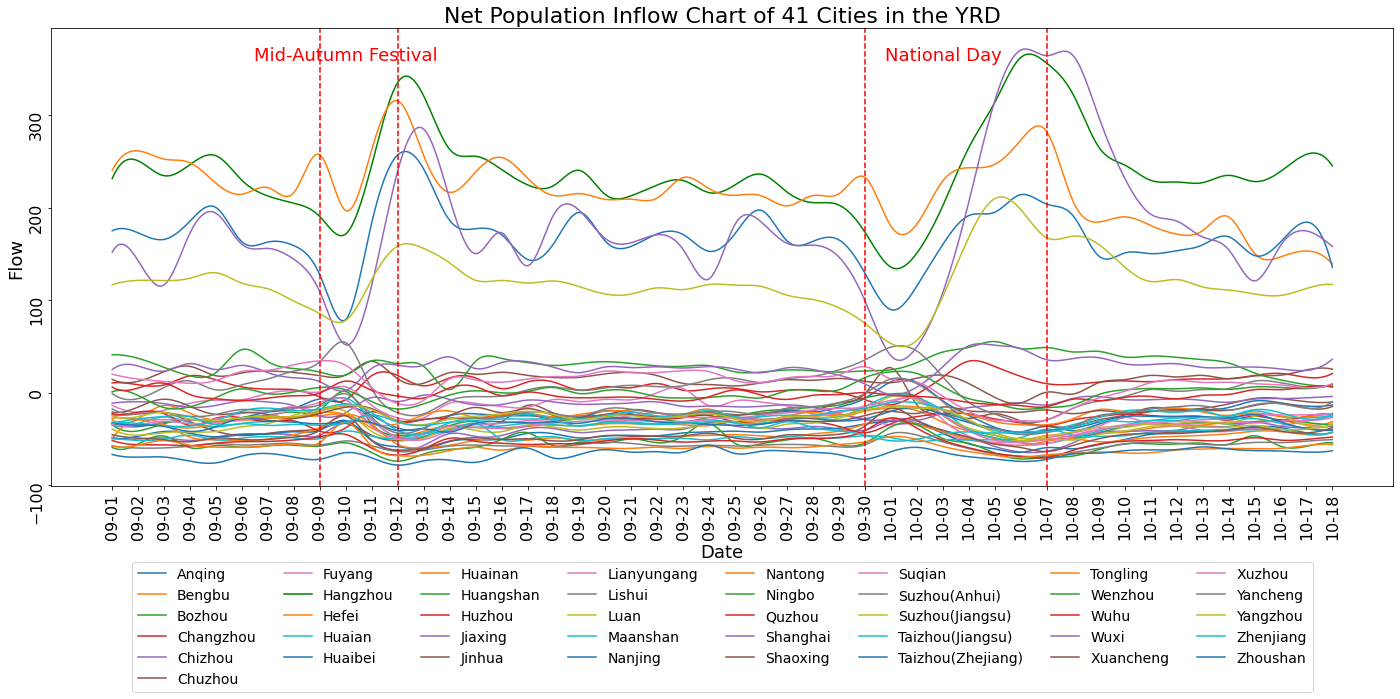

In [44]:
plt.figure(figsize=(20, 10))

# Define custom colors for Hefei and Hangzhou from the 'tab10' color map
color_map = plt.cm.get_cmap('tab10')
color_hangzhou_new = 'green'  # Set the new color for Hangzhou

# Plot a curve
for i in range(len(merge_data)):
    x = mdates.datestr2num(dates_merge)  
    y = merge_data.iloc[i].values
    tck = interpolate.splrep(x, y, s=0)
    x_new = np.linspace(x.min(), x.max(), 500)
    y_smooth = interpolate.splev(x_new, tck, der=0)

    city_name = data_combined['OrigCity'][i]
    if city_name == 'Hefei':
        plt.plot(mdates.num2date(x_new), y_smooth, label=city_name, color=color_map(1))  
    elif city_name == 'Hangzhou':
        plt.plot(mdates.num2date(x_new), y_smooth, label=city_name, color=color_hangzhou_new)  
    else:
        plt.plot(mdates.num2date(x_new), y_smooth, label=city_name, color=color_map(i % color_map.N))

plt.xlabel('Date', fontsize=18)  
plt.ylabel('Flow', fontsize=18) 
plt.title('Net Population Inflow Chart of 41 Cities in the YRD', fontsize=22) 

# Place a legend outside the graph
plt.legend(ncol=8, loc='upper center', bbox_to_anchor=(0.5, -0.15), prop={'size': 14})

plt.xticks(rotation=90, fontsize=16)  
plt.yticks(rotation=90, fontsize=16)  

# Set X-axis ticks and labels
plt.xticks(x, dates_merge)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  

# Add a vertical line
plt.axvline(x=mdates.datestr2num('20220909'), color='r', linestyle='--')  
plt.axvline(x=mdates.datestr2num('20220912'), color='r', linestyle='--')  
plt.axvline(x=mdates.datestr2num('20220930'), color='r', linestyle='--')  
plt.axvline(x=mdates.datestr2num('20221007'), color='r', linestyle='--')  

# Add text
plt.text(mdates.datestr2num('20220910'), plt.ylim()[1]*0.95, 'Mid-Autumn Festival', ha='center', va='top', color='red', fontsize=18)  
plt.text(mdates.datestr2num('20221003'), plt.ylim()[1]*0.95, 'National Day', ha='center', va='top', color='red', fontsize=18) 

plt.tight_layout() 

# Save
plt.savefig('Net Population Inflow Chart of 41 Cities in the YRD.jpg', dpi=300)
plt.show()

In [45]:
# Next, plot an example of population movement for Shanghai.

In [46]:
# Extract Shanghai data
shanghai_data = data_combined[data_combined['OrigCity'] == 'Shanghai']
column_to_delete = 'Total'
shanghai_data = shanghai_data.drop(column_to_delete, axis=1)
shanghai_data

OrigCity  20220901  20220902  20220903  20220904  20220905  20220906  \
24  Shanghai    151.78    142.52    116.41    172.68    193.88    160.23   

    20220907  20220908  20220909  ...  20221009  20221010  20221011  20221012  \
24    155.88    144.08    108.69  ...    298.37     231.9    192.95    185.49   

    20221013  20221014  20221015  20221016  20221017  20221018  
24    168.28     154.7    120.68    158.87    174.78    157.93  

[1 rows x 49 columns]

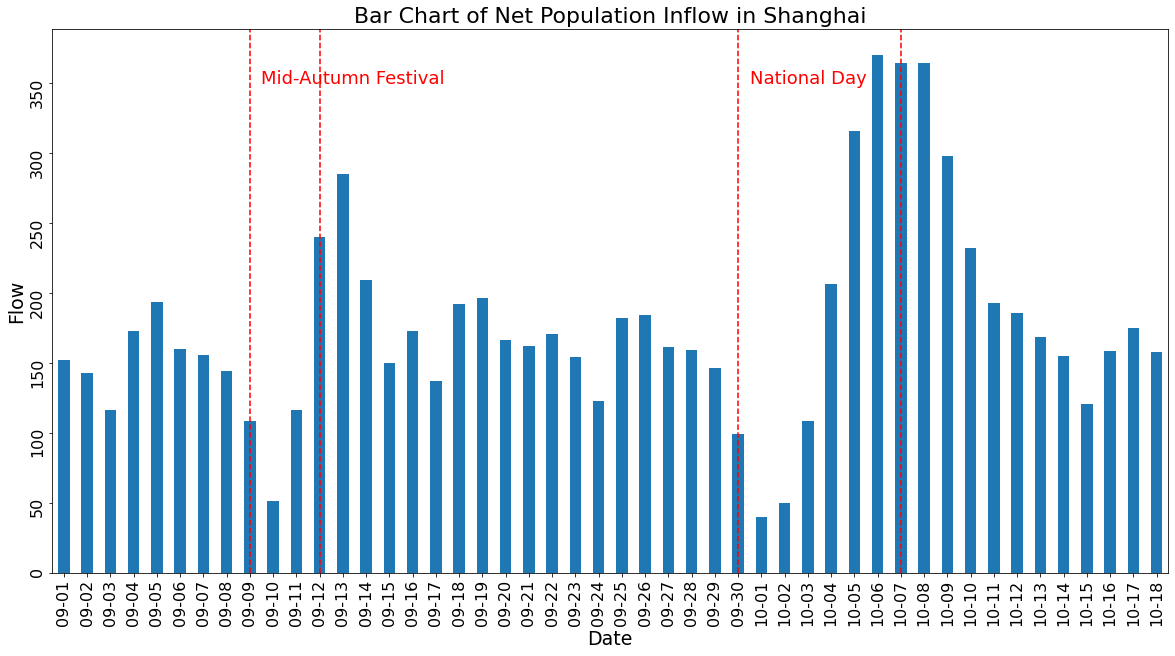

In [47]:
# Convert dates to numerical type
date_columns = shanghai_data.columns[2:]
shanghai_data[date_columns] = shanghai_data[date_columns].astype(float)

shanghai_data_transposed = shanghai_data.set_index('OrigCity').T

# Convert date format to MM-DD
shanghai_data_transposed.index = pd.to_datetime(shanghai_data_transposed.index).strftime('%m-%d')

ax = shanghai_data_transposed.plot(kind='bar', figsize=(20, 10), legend=False)

# Add title and labels
plt.title('Bar Chart of Net Population Inflow in Shanghai', fontsize=22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Flow', fontsize=19)
plt.xticks(rotation=90, fontsize=16) 
plt.yticks(rotation=90, fontsize=16)  

dates_to_find = ['09-09', '09-12', '09-30', '10-07']
for date_to_find in dates_to_find:
    if date_to_find in shanghai_data_transposed.index:
        index_position = shanghai_data_transposed.index.get_loc(date_to_find)
        plt.axvline(x=index_position, color='red', linestyle='--', label=date_to_find)

        # Add text labels
        if date_to_find == '09-09':
            plt.text(index_position + 0.5, ax.get_ylim()[1] * 0.9, 'Mid-Autumn Festival', color='red', fontsize=18)
        elif date_to_find == '09-30':
            plt.text(index_position + 0.5, ax.get_ylim()[1] * 0.9, 'National Day', color='red', fontsize=18)

    else:
        print(f"The date '{date_to_find}' is not in the data.")

plt.savefig('Bar Chart of Net Population Inflow in Shanghai.jpg', dpi=300)

plt.show()

In [48]:
#Suzhou(Anhui)

In [49]:
# Extract Suzhou(Anhui) data
Suzhou_Anhui_data = data_combined[data_combined['OrigCity'] == 'Suzhou(Anhui)']
column_to_delete = 'Total'
Suzhou_Anhui_data = Suzhou_Anhui_data.drop(column_to_delete, axis=1)
Suzhou_Anhui_data

OrigCity  20220901  20220902  20220903  20220904  20220905  20220906  \
27  Suzhou(Anhui)     -0.93     -6.58      5.48     12.44      2.86      8.41   

    20220907  20220908  20220909  ...  20221009  20221010  20221011  20221012  \
27     14.66     23.16     33.47  ...     -9.31     -4.21      3.25      1.35   

    20221013  20221014  20221015  20221016  20221017  20221018  
27      3.21      4.23     12.33     10.54       6.1      8.21  

[1 rows x 49 columns]

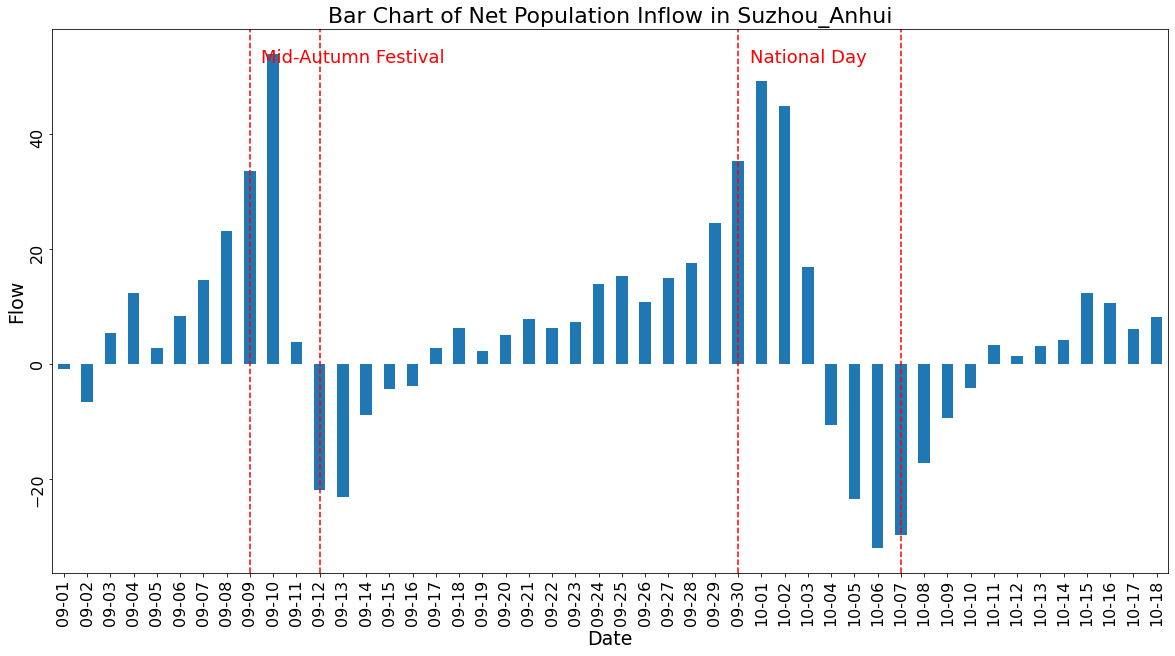

In [50]:
# Convert date to a numeric type
date_columns = Suzhou_Anhui_data.columns[2:]
Suzhou_Anhui_data[date_columns] = Suzhou_Anhui_data[date_columns].astype(float)

Suzhou_Anhui_data_transposed = Suzhou_Anhui_data.set_index('OrigCity').T

# Convert date format to MM-DD
Suzhou_Anhui_data_transposed.index = pd.to_datetime(Suzhou_Anhui_data_transposed.index).strftime('%m-%d')

ax = Suzhou_Anhui_data_transposed.plot(kind='bar', figsize=(20, 10), legend=False)

# Add title and labels
plt.title('Bar Chart of Net Population Inflow in Suzhou_Anhui', fontsize=22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Flow', fontsize=19)
plt.xticks(rotation=90, fontsize=16) 
plt.yticks(rotation=90, fontsize=16)  

dates_to_find = ['09-09', '09-12', '09-30', '10-07']
for date_to_find in dates_to_find:
    if date_to_find in Suzhou_Anhui_data_transposed.index:
        index_position = Suzhou_Anhui_data_transposed.index.get_loc(date_to_find)
        plt.axvline(x=index_position, color='red', linestyle='--', label=date_to_find)

        # Add text labels
        if date_to_find == '09-09':
            plt.text(index_position + 0.5, ax.get_ylim()[1] * 0.9, 'Mid-Autumn Festival', color='red', fontsize=18)
        elif date_to_find == '09-30':
            plt.text(index_position + 0.5, ax.get_ylim()[1] * 0.9, 'National Day', color='red', fontsize=18)

    else:
        print(f"The date '{date_to_find}' is not in the data.")

        
plt.savefig('Bar Chart of Net Population Inflow in Suzhou_Anhui.jpg', dpi=300)

plt.show()

### 3.2 Migration Flow Network Pattern

#### 3.2.0 Dataset processing

In [51]:
ply.head()

code       city                                           geometry  \
0  310000   Shanghai  MULTIPOLYGON (((120.90135 31.01733, 120.89088 ...   
1  320100    Nanjing  MULTIPOLYGON (((119.06745 32.46240, 119.04702 ...   
2  320200       Wuxi  POLYGON ((119.53262 31.15911, 119.54300 31.175...   
3  320300     Xuzhou  POLYGON ((118.40820 34.43551, 118.41522 34.420...   
4  320400  Changzhou  POLYGON ((120.02242 31.96777, 120.00766 31.947...   

                    Centroids  
0  POINT (121.48663 31.20863)  
1  POINT (118.84816 31.92578)  
2  POINT (120.08033 31.52198)  
3  POINT (117.52264 34.35425)  
4  POINT (119.64157 31.62297)

In [52]:
point = gpd.read_file('data/points_shp/points.shp')
point = point.to_crs(epsg=32649)
ply = ply.to_crs(epsg=32649)
point.head()

city    code                         geometry
0   Shanghai  310000  POINT (1502156.346 3503619.189)
1    Nanjing  320100  POINT (1237002.402 3575028.182)
2       Wuxi  320200  POINT (1386452.961 3522344.232)
3     Xuzhou  320300  POINT (1077998.215 3803035.596)
4  Changzhou  320400  POINT (1349927.280 3555088.023)

In [53]:
ply["code"] = ply["code"].astype(int)
point["code"] = point["code"].astype(int)

In [54]:
# Combine
merged_gdf = ply.merge(point, left_on='code', right_on='code', how='left')
merged_gdf.head()

code     city_x                                         geometry_x  \
0  310000   Shanghai  MULTIPOLYGON (((1447289.228 3473963.606, 14455...   
1  320100    Nanjing  MULTIPOLYGON (((1259232.421 3620497.258, 12573...   
2  320200       Wuxi  POLYGON ((1314624.309 3478765.675, 1315477.030...   
3  320300     Xuzhou  POLYGON ((1181307.591 3835436.272, 1182078.880...   
4  320400  Changzhou  POLYGON ((1354069.962 3572647.934, 1352852.641...   

                    Centroids     city_y                       geometry_y  
0  POINT (121.48663 31.20863)   Shanghai  POINT (1502156.346 3503619.189)  
1  POINT (118.84816 31.92578)    Nanjing  POINT (1237002.402 3575028.182)  
2  POINT (120.08033 31.52198)       Wuxi  POINT (1386452.961 3522344.232)  
3  POINT (117.52264 34.35425)     Xuzhou  POINT (1077998.215 3803035.596)  
4  POINT (119.64157 31.62297)  Changzhou  POINT (1349927.280 3555088.023)

In [55]:
# Transform the data structure into a GeoDataFrame type to give it geospatial characteristics
merged_gdf = gpd.GeoDataFrame(merged_gdf)

In [56]:
merged_gdf = merged_gdf.set_geometry('geometry_x')

In [57]:
# Compass
from matplotlib.patches import *

def get_circle(x1, y1, x2, y2, x3, y3):
    a = x1 - x2
    b = y1 - y2
    c = x1 - x3
    d = y1 - y3
    a1 = ((x1 * x1 - x2 * x2) + (y1 * y1 - y2 * y2)) / 2.0
    a2 = ((x1 * x1 - x3 * x3) + (y1 * y1 - y3 * y3)) / 2.0
    theta = b * c - a * d
    if abs(theta) < 1e-7:
        raise ValueError("compute circle error!")
    x0 = (b * a2 - d * a1) / theta
    y0 = (c * a1 - a * a2) / theta
    r = np.sqrt(pow((x1 - x0), 2) + pow((y1 - y0), 2))
    return x0, y0, r

def add_north(ax, x, y, text_size=15, arrow_width=0.05,
              text_pad=0.01, arrow_height=None,
              line_width=1, add_circle=True):

    if arrow_height is None:
        arrow_height = arrow_width * 1.87
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    width = x_max - x_min
    height = y_max - y_min

    left = (x_min + width * (x - arrow_width * 0.5), y_min + height * (y - arrow_height))
    right = (x_min + width * (x + arrow_width * 0.5), left[1])
    top = (x_min + width * x, y_min + height * y)
    bottom_center = (top[0], left[1] + 0.27 * (top[1] - left[1]))
    left_patch = Polygon([left, top, bottom_center], color='k',
                         linewidth=line_width)
    right_patch = Polygon([bottom_center, top, right],
                          facecolor='none',
                          edgecolor='k', linewidth=line_width)
    ax.add_patch(left_patch)
    ax.add_patch(right_patch)
    if add_circle:
        circle_x, circle_y, r = get_circle(*top, *left, *right)

        circle_patch = Circle((circle_x, circle_y), r,
                              facecolor='none',
                              edgecolor='k',
                              linewidth=line_width)
        ax.add_patch(circle_patch)

    ax.text(s='N',
            x=top[0],
            y=top[1] + text_pad * height,
            fontsize=text_size,
            horizontalalignment='center',
            verticalalignment='bottom')

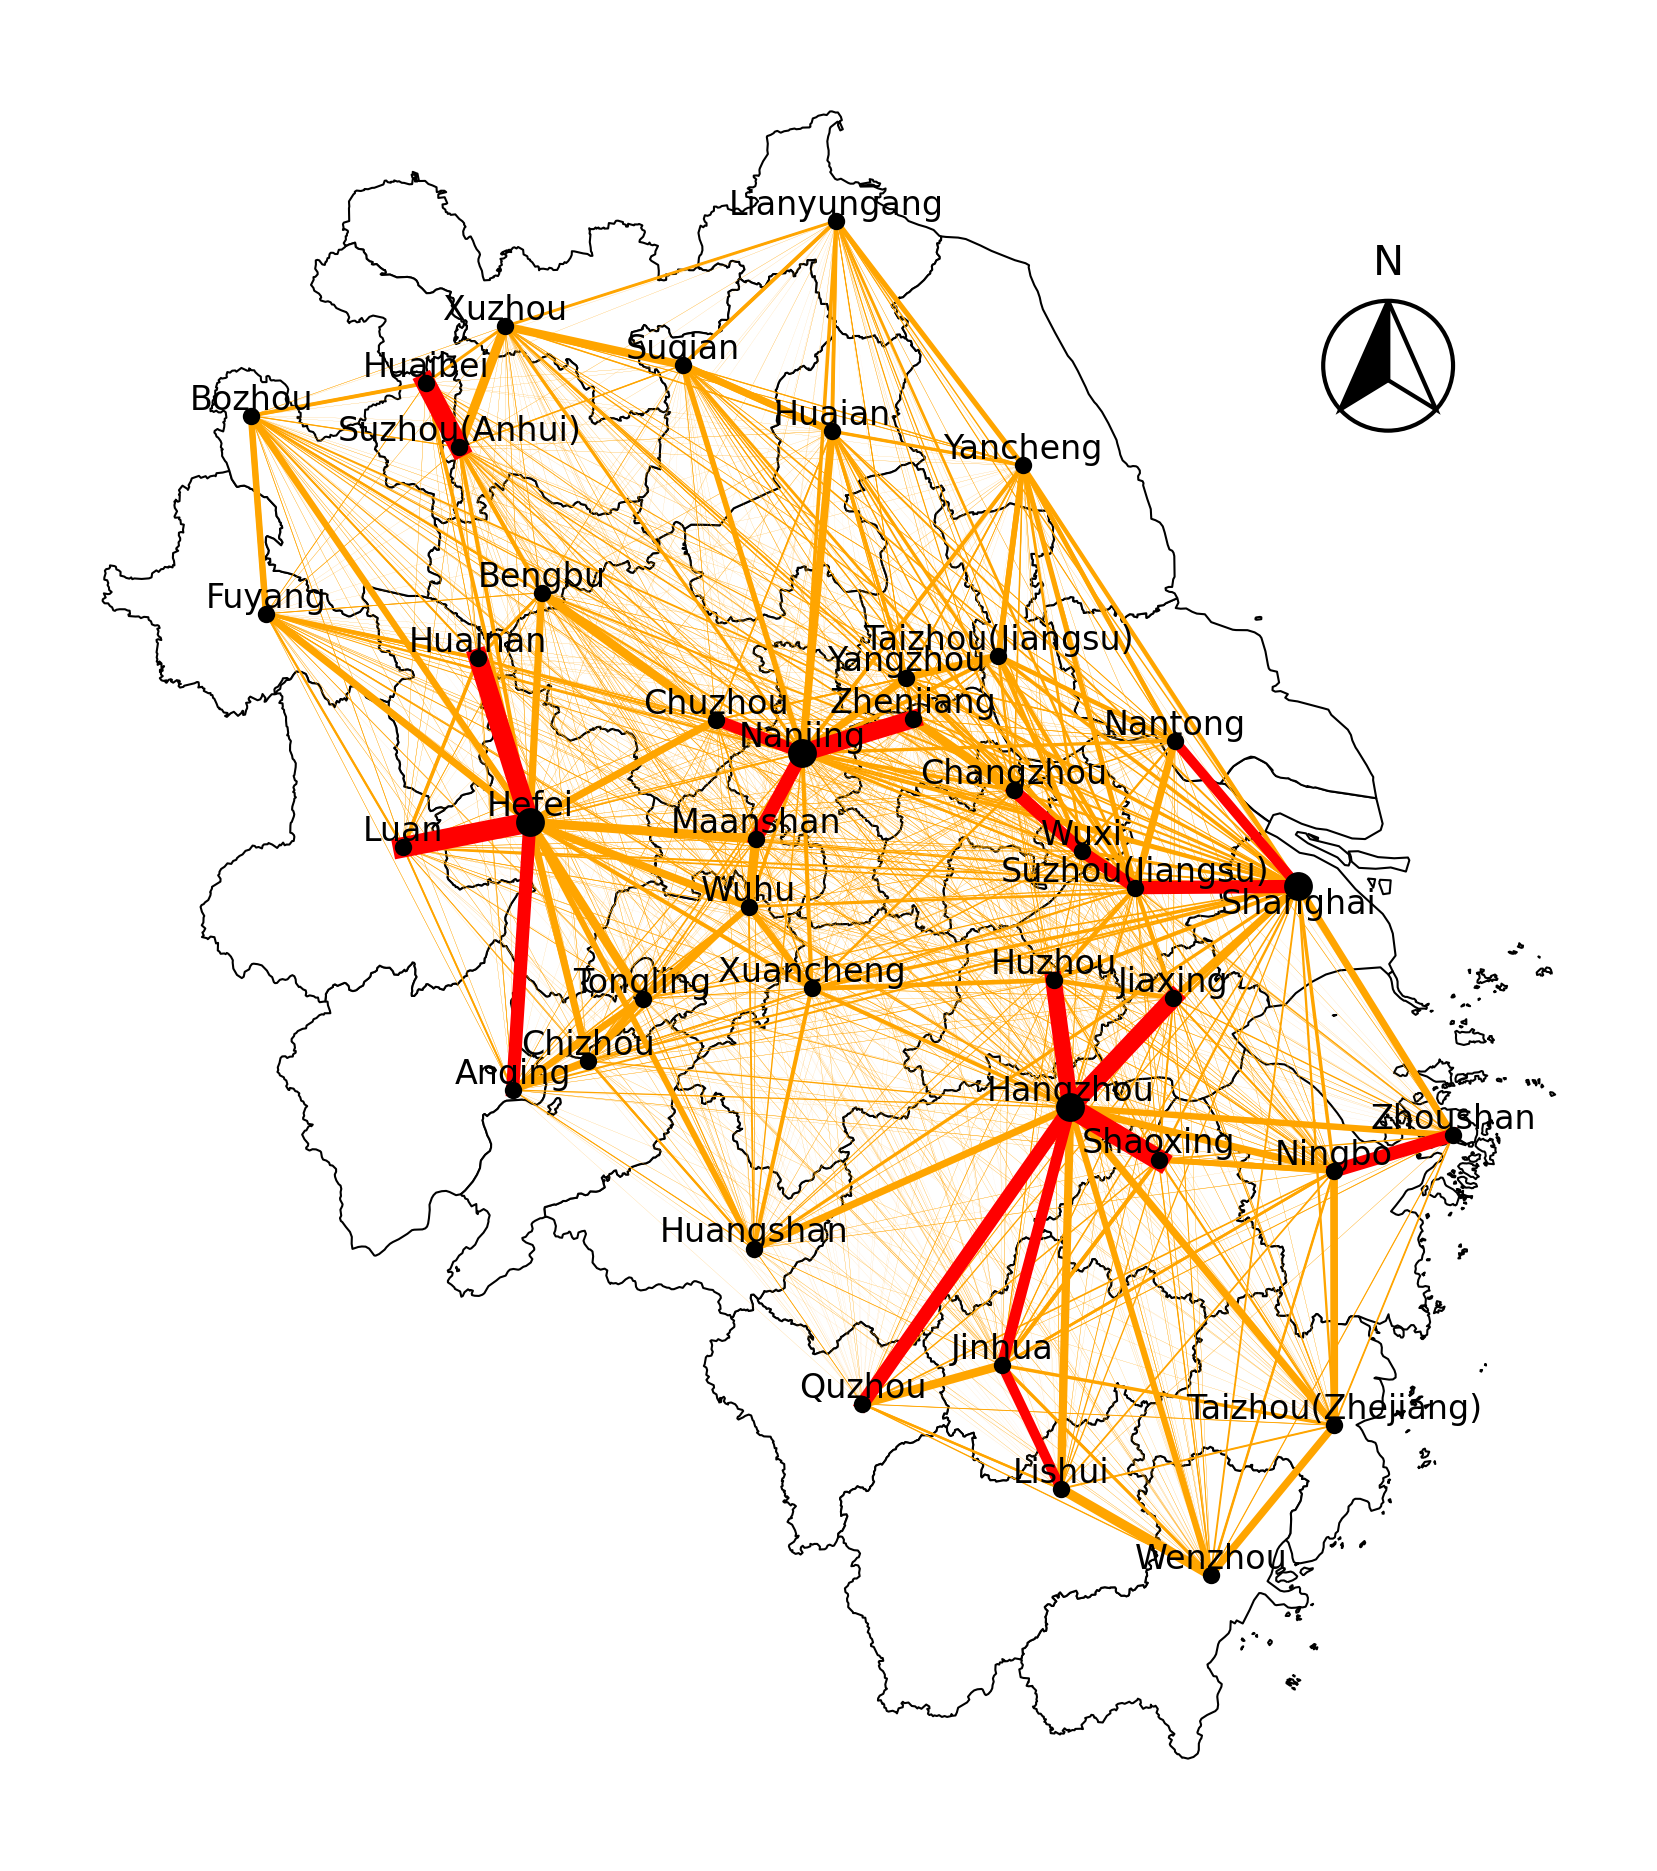

In [58]:
#plot

fig  = plt.figure(1,(8,8),dpi = 300)      
ax   = plt.subplot(111)

point = gpd.read_file('data/points_shp/points.shp')
point = point.to_crs(epsg=32649)
ply = ply.to_crs(epsg=32649)

# Draw a basic map
merged_gdf.plot(ax=ax, facecolor="white", edgecolor="k", lw=0.5)

# Sort the DataFrame by "Total" column in descending order and get the top 20 rows.
top_20_df = df.sort_values(by="Total", ascending=False).head(20)

# Plot lines for each pair
for index, row in df.iterrows():
    # Get the x and y coordinates
    x1 = [merged_gdf[merged_gdf["code"] == row["OrigCode"]]["geometry_y"].x.values[0], merged_gdf[merged_gdf["code"] == row["DestCode"]]["geometry_y"].x.values[0]]
    y1 = [merged_gdf[merged_gdf["code"] == row["OrigCode"]]["geometry_y"].y.values[0], merged_gdf[merged_gdf["code"] == row["DestCode"]]["geometry_y"].y.values[0]]
    
    # Use red color for top 20 lines, otherwise use blue color
    if row["Total"] in top_20_df["Total"].values:
        color = "red"
    else:
        color = "orange"
    
    # Set zorder to make sure red lines are on top
    if color == "red":
        zorder = 2
    else:
        zorder = 1
    
    ax.plot(x1, y1, linewidth=row["Total"]/max(df["Total"])*5, color=color, zorder=zorder)

# Set individual city sizes
highlight_cities = ['Hangzhou', 'Nanjing', 'Shanghai', 'Hefei']
highlight_points = point[point['city'].isin(highlight_cities)]

# Draw highlighted points and set different sizes and zorder values
highlight_points.plot(ax=ax, marker='o', color="black", markersize=35, zorder=10)

# Draw regular points
point[~point['city'].isin(highlight_cities)].plot(ax=ax, marker='o', color="black", markersize=10, zorder=10)

    
# Display city names on each point
for point, label in zip(point.geometry, point['city']):
    x, y = point.x, point.y

    
    if label == 'Shanghai':
        plt.text(x, y - 90, label, fontsize=8, ha='center', va='top') 
    else:
        plt.text(x, y + 90, label, fontsize=8, ha='center', va='bottom')

    
# Add a compass rose
x = 0.85  
y = 0.85 
add_north(ax, x, y, text_size=10, arrow_width=0.06, arrow_height=0.06)

# Remove tick marks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Remove the border
for spine in ax.spines.values():
    spine.set_visible(False)

# Save
plt.savefig('Network Pattern of Migration Flows in the Yangtze River Delta.jpg', dpi=300)
plt.show()


In [59]:
dfsubmat = pd.pivot_table(df, values ="Total", index="OrigCity", columns = "DestCity",
                            aggfunc=np.sum, margins=True)
dfsubmat

DestCity            Anqing   Bengbu   Bozhou  Changzhou  Chizhou  Chuzhou  \
OrigCity                                                                    
Anqing                 NaN    44.86    23.55      29.07   430.29    48.55   
Bengbu               41.29      NaN   200.43      41.97    27.31   910.85   
Bozhou               28.71   238.32      NaN      45.49    19.13    75.37   
Changzhou            11.53    17.21    16.95        NaN    13.21    34.41   
Chizhou             750.21    41.48    24.47      54.12      NaN    41.49   
Chuzhou              35.89   657.01    35.22      60.75    20.56      NaN   
Fuyang               35.49    89.77   564.92      44.02    21.70    56.00   
Hangzhou             16.49    11.09    12.42      27.76     9.35    10.39   
Hefei               307.32   183.57   144.70      35.13   105.40   267.73   
Huaian                5.96    24.99     7.07     137.04     4.78   156.22   
Huaibei              17.54   148.14   398.19      23.10    13.05    67.30   
Huainan              52.19   301.51   180.23      20.94    31.37   161.66   
Huangshan           109.28    46.34    23.82      38.33   208.02    43.14   
Huzhou               34.73    10.95    13.57      68.61     8.55    14.76   
Jiaxing              11.47    10.00     8.85      29.71     7.84    10.24   
Jinhua                9.51    11.22    17.47      21.01     4.89    12.73   
Lianyungang           4.61    10.13     6.87     117.57     3.25    17.77   
Lishui                4.52     3.40     2.73      10.46     2.99     4.32   
Luan                157.33    57.40    47.19      47.00    36.02    52.83   
Maanshan             48.94    34.20    26.59      59.35    46.00   135.66   
Nanjing              24.23    44.31    28.54     218.10    21.16   345.11   
Nantong               7.14    17.63    14.37     134.81     4.75    21.32   
Ningbo               17.37    18.32    28.50      33.82     6.35    18.16   
Quzhou                7.78     6.68     4.20      15.06     6.99     5.24   
Shanghai             23.71    25.80    21.72      86.10    15.86    26.74   
Shaoxing              6.65     7.99     8.48      16.28     4.56     7.61   
Suqian                5.42    42.11     9.59     128.64     3.56    55.84   
Suzhou(Anhui)        18.45   314.11    84.87      41.06    11.11    77.22   
Suzhou(Jiangsu)      13.15    15.76    18.51     163.65     9.91    30.26   
Taizhou(Jiangsu)      5.40     9.91     7.00     251.20     5.80    24.34   
Taizhou(Zhejiang)     6.72    18.38    20.21      23.37     6.45    11.78   
Tongling            705.86    34.79    16.27      69.87   677.10    36.76   
Wenzhou              11.88    11.57    20.33      19.52     7.79    10.85   
Wuhu                108.35    50.27    30.39      60.87   135.46    69.73   
Wuxi                 10.42    16.47    16.23     980.91     8.80    29.40   
Xuancheng            50.58    29.63    15.62     263.69    68.95    43.17   
Xuzhou                9.05    32.62    22.60      86.00     5.96    32.47   
Yancheng              4.70     7.76     5.30     144.60     4.19    19.75   
Yangzhou              9.26    18.28     9.22     182.49     6.62   197.38   
Zhenjiang             7.60    15.44     9.67     936.50     8.42    48.57   
Zhoushan              5.66     5.23     8.96      24.63     8.44     5.89   
All                2742.39  2684.65  2155.82    4792.60  2041.94  3239.01   

DestCity            Fuyang  Hangzhou     Hefei   Huaian  ...  Wenzhou  \
OrigCity                                                 ...            
Anqing               36.58    132.57   1358.28     6.88  ...    23.40   
Bengbu               96.74     83.27    747.99    29.77  ...    19.66   
Bozhou              672.15     95.74    674.24     8.85  ...    36.46   
Changzhou            20.07     82.53     53.42    65.26  ...    12.69   
Chizhou              34.71    139.89    746.05     8.35  ...    30.11   
Chuzhou              36.44     52.71    752.73   147.79  ...    11.35   
Fuyang                 NaN 

In [60]:
# View a detailed table of the top 20 traffic rankings
sorted_df = df.sort_values(by="Total", ascending=False).head(20)
sorted_df

No  OrigCode         OrigCity  DestCode         DestCity    Total  \
793    775    330600         Shaoxing    330100         Hangzhou  2157.43   
1542  1506    341500             Luan    340100            Hefei  2122.25   
1266  1236    340600          Huaibei    341300    Suzhou(Anhui)  2031.36   
1173  1146    340400          Huainan    340100            Hefei  1995.99   
711    695    330400          Jiaxing    330100         Hangzhou  1850.86   
452    442    321100        Zhenjiang    320100          Nanjing  1850.27   
752    735    330500           Huzhou    330100         Hangzhou  1716.57   
875    855    330800           Quzhou    330100         Hangzhou  1418.13   
1190  1162    340500         Maanshan    320100          Nanjing  1394.42   
917    896    330900         Zhoushan    330200           Ningbo  1386.84   
205    201    320500  Suzhou(Jiangsu)    310000         Shanghai  1371.40   
1337  1306    340800           Anqing    340100            Hefei  1358.28   
166    163    320400        Changzhou    320200             Wuxi  1311.90   
87      85    320200             Wuxi    320500  Suzhou(Jiangsu)  1219.51   
1395  1362    341100          Chuzhou    320100          Nanjing  1196.43   
5        5    310000         Shanghai    320500  Suzhou(Jiangsu)  1189.11   
834    815    330700           Jinhua    330100         Hangzhou  1145.67   
1004   981    331100           Lishui    330700           Jinhua  1031.96   
1506  1471    341300    Suzhou(Anhui)    340600          Huaibei  1027.73   
246    241    320600          Nantong    310000         Shanghai  1016.53   

      20220901  20220902  20220903  20220904  ...  density of highway_Orig  \
793      44.53     45.22     43.34     46.76  ...                   126.14   
1542     44.90     44.08     44.58     46.21  ...                   162.69   
1266     41.39     40.09     43.15     46.38  ...                   190.88   
1173     42.33     44.08     42.69     43.26  ...                   169.29   
711      39.66     38.27     36.48     38.56  ...                   193.89   
452      42.46     38.94     35.83     38.97  ...                   179.01   
752      34.43     38.34     35.76     35.56  ...                   141.74   
875      27.87     31.00     29.62     30.83  ...                    98.18   
1190     29.68     26.97     25.84     30.67  ...                   191.70   
917      31.13     28.66     28.11     25.60  ...                   134.82   
205      30.79     27.30     23.43     27.82  ...                   133.51   
1337     28.42     28.87     27.71     29.79  ...                   168.09   
166      28.47     27.36     26.12     26.75  ...                   194.39   
87       26.68     26.05     26.39     25.43  ...                   168.64   
1395     25.73     23.56     20.35     25.58  ...                   152.75   
5        24.75     26.31     27.84     26.64  ...                   206.33   
834      21.16     23.48     23.47     25.78  ...                   121.40   
1004     20.67     19.60     22.59     24.11  ...                    92.00   
1506     20.53     19.44     21.80     23.58  ...                   213.92   
246      18.52     18.82     17.55     23.07  ...                   166.74   

      population_Dest  GDP growth rate_Dest  house rate_Dest  \
793          11936010                  8.50         0.572755   
1542          9465000                 13.61         0.085564   
1266          5325000                  6.00         0.299644   
1173          9465000                 13.61         0.085564   
711          11936010                  8.50         0.572755   
452           9319700                  7.50         0.018579   
752          11936010                  8.50         0.572755   
875          11936010                  8.50         0.572755   
1190          9319700                  7.50         0.018579   
917           9404283                  8.20         0.851483   
205          24894300                  8.10    

#### 3.2.1 Add total flow for holidays and regular days

In [61]:
# Holidays

# Specify the start and end column names of the three consecutive intervals to be deleted
start_column1 = '20220901'
end_column1 = '20220908'
start_column2 = '20220913'
end_column2 = '20220929'
start_column3 = '20221008'
end_column3 = '20221018'

# Construct a list of column names to be deleted
columns_to_drop = list(df.columns[df.columns.get_loc(start_column1):df.columns.get_loc(end_column1) + 1]) + \
                  list(df.columns[df.columns.get_loc(start_column2):df.columns.get_loc(end_column2) + 1]) + \
                  list(df.columns[df.columns.get_loc(start_column3):df.columns.get_loc(end_column3) + 1])

# Remove the specified columns and generate a new dataset
holiday_df = df.drop(columns=columns_to_drop)

# Specify the date column name, 12-day holiday
date_columns = ['20220909', '20220910', '20220911', '20220912', 
                '20220930','20221001', '20221002', '20221003', '20221004', '20221005', '20221006', '20221007']

# Calculate the total and add a new column
holiday_df['Total_holiday'] = holiday_df[date_columns].sum(axis=1)
# Calculate the standard deviation and add a new column
holiday_df['Standard_deviation_holiday'] = holiday_df[date_columns].std(axis=1)

In [62]:
holiday_df

No  OrigCode   OrigCity  DestCode         DestCity    Total  20220909  \
1        1    310000   Shanghai    320100          Nanjing   117.28      2.40   
2        2    310000   Shanghai    320200             Wuxi   167.67      3.26   
3        3    310000   Shanghai    320300           Xuzhou    30.50      0.95   
4        4    310000   Shanghai    320400        Changzhou    86.10      2.21   
5        5    310000   Shanghai    320500  Suzhou(Jiangsu)  1189.11     20.14   
...    ...       ...        ...       ...              ...      ...       ...   
1675  1636    341800  Xuancheng    341200           Fuyang    19.83      0.81   
1676  1637    341800  Xuancheng    341300    Suzhou(Anhui)    18.27      0.58   
1677  1638    341800  Xuancheng    341500             Luan    35.70      0.95   
1678  1639    341800  Xuancheng    341600           Bozhou    15.62      0.48   
1679  1640    341800  Xuancheng    341700          Chizhou    68.95      1.31   

      20220910  20220911  20220912  ...  GDP growth rate_Dest  \
1         2.65      2.08      2.47  ...                  7.50   
2         3.76      3.41      3.49  ...                  8.80   
3         0.76      0.48      0.52  ...                  8.70   
4         2.19      1.71      1.74  ...                  9.10   
5        23.23     29.32     25.10  ...                  8.70   
...        ...       ...       ...  ...                   ...   
1675      0.68      0.33      0.23  ...                  9.49   
1676      0.57      0.19      0.19  ...                  6.00   
1677      0.93      0.35      0.39  ...                 15.21   
1678      0.48      0.32      0.17  ...                  9.23   
1679      1.60      0.94      0.87  ...                 15.57   

      house rate_Dest  higher education institutions _Dest  \
1            0.018579                                   51   
2            0.848554                                   13   
3            0.533353                                   12   
4            0.842599                                   11   
5            0.240529                                   26   
...               ...                                  ...   
1675         0.085865                                    6   
1676         0.299644                                    4   
1677         0.121458                                    4   
1678         0.408087                                    2   
1679         0.586287                                    3   

      Income growth rate_Dest  tourist_Dest  industrial enterprises_Dest  \
1                    0.089411            27                         3975   
2                    0.089146            30                         7721   
3                    0.088452            20                         2557   
4                    0.087446            13                         5662   
5                    0.083448            40                        12493   
...                       ...           ...                          ...   
1675                 0.081506             7                         1571   
1676                 0.084485             7                         1081   
1677                 0.093500            26                         1179   
1678                 0.092479             9                          656   
1679                 0.086515            18                          627   

      star hotel_Dest  density of highway_Dest  Total_holiday  \
1                  60                   147.95          26.36   
2                  29                   168.64          38.20   
3                  15                   134.80           8.78   
4                  30                   194.39          21.01   
5                  63                   133.51         244.24   
...               ...                      ...            ...   
1675                4                   217.68           4.15   
1676                5                   213.92           6.11   
1677       

In [63]:
# Assuming df_compare is the DataFrame you want to inspect
column_names = holiday_df.columns

# View the column names
column_names

Index(['No', 'OrigCode', 'OrigCity', 'DestCode', 'DestCity', 'Total',
       '20220909', '20220910', '20220911', '20220912', '20220930', '20221001',
       '20221002', '20221003', '20221004', '20221005', '20221006', '20221007',
       'Dist', 'Dist_cert', 'population_Orig', 'GDP growth rate_Orig',
       'house rate_Orig', 'higher education institutions _Orig',
       'Income growth rate_Orig', 'tourist_Orig',
       'industrial enterprises_Orig', 'star hotel_Orig',
       'density of highway_Orig', 'population_Dest', 'GDP growth rate_Dest',
       'house rate_Dest', 'higher education institutions _Dest',
       'Income growth rate_Dest', 'tourist_Dest',
       'industrial enterprises_Dest', 'star hotel_Dest',
       'density of highway_Dest', 'Total_holiday',
       'Standard_deviation_holiday'],
      dtype='object')

In [64]:
# Regular days

# Specify the start and end column names of the 2 consecutive intervals to be deleted
start_column4 = '20220909'
end_column4 = '20220912'
start_column5 = '20220930'
end_column5 = '20221007'

# Construct a list of column names to be deleted
columns_to_drop_45 = list(df.columns[df.columns.get_loc(start_column4):df.columns.get_loc(end_column4) + 1]) + \
                  list(df.columns[df.columns.get_loc(start_column5):df.columns.get_loc(end_column5) + 1])

# Remove the specified columns and generate a new dataset
Ordinary_df = df.drop(columns=columns_to_drop_45)

#Specify the date column name, choose regular days
date_columns = ['20220901', '20220902', '20220903', '20220904', '20220905',
                '20220906', '20220907', '20220908', '20220913', '20220914',
                '20220915', '20220916', '20220917', '20220918', '20220919',
                '20220920', '20220921', '20220922', '20220923', '20220924',
                '20220925', '20220926', '20220927', '20220928', '20220929',
                '20221008', '20221009', '20221010', '20221011', '20221012',
                '20221013', '20221014', '20221015', '20221016', '20221017',
                '20221018', 
               ]

# Calculate the total and add a new column
Ordinary_df['Total_Ordinary'] = Ordinary_df[date_columns].sum(axis=1)
# Calculate the standard deviation and add a new column
Ordinary_df['Standard_deviation_Ordinary'] = Ordinary_df[date_columns].std(axis=1)

In [65]:
Ordinary_df

No  OrigCode   OrigCity  DestCode         DestCity    Total  20220901  \
1        1    310000   Shanghai    320100          Nanjing   117.28      2.65   
2        2    310000   Shanghai    320200             Wuxi   167.67      3.35   
3        3    310000   Shanghai    320300           Xuzhou    30.50      0.72   
4        4    310000   Shanghai    320400        Changzhou    86.10      1.81   
5        5    310000   Shanghai    320500  Suzhou(Jiangsu)  1189.11     24.75   
...    ...       ...        ...       ...              ...      ...       ...   
1675  1636    341800  Xuancheng    341200           Fuyang    19.83      0.41   
1676  1637    341800  Xuancheng    341300    Suzhou(Anhui)    18.27      0.31   
1677  1638    341800  Xuancheng    341500             Luan    35.70      0.56   
1678  1639    341800  Xuancheng    341600           Bozhou    15.62      0.25   
1679  1640    341800  Xuancheng    341700          Chizhou    68.95      1.27   

      20220902  20220903  20220904  ...  GDP growth rate_Dest  \
1         2.65      2.98      2.48  ...                  7.50   
2         3.64      3.86      3.30  ...                  8.80   
3         0.59      0.61      0.69  ...                  8.70   
4         1.97      2.00      1.67  ...                  9.10   
5        26.31     27.84     26.64  ...                  8.70   
...        ...       ...       ...  ...                   ...   
1675      0.43      0.46      0.40  ...                  9.49   
1676      0.43      0.64      0.47  ...                  6.00   
1677      0.78      0.68      0.61  ...                 15.21   
1678      0.28      0.63      0.38  ...                  9.23   
1679      1.10      1.51      0.98  ...                 15.57   

      house rate_Dest  higher education institutions _Dest  \
1            0.018579                                   51   
2            0.848554                                   13   
3            0.533353                                   12   
4            0.842599                                   11   
5            0.240529                                   26   
...               ...                                  ...   
1675         0.085865                                    6   
1676         0.299644                                    4   
1677         0.121458                                    4   
1678         0.408087                                    2   
1679         0.586287                                    3   

      Income growth rate_Dest  tourist_Dest  industrial enterprises_Dest  \
1                    0.089411            27                         3975   
2                    0.089146            30                         7721   
3                    0.088452            20                         2557   
4                    0.087446            13                         5662   
5                    0.083448            40                        12493   
...                       ...           ...                          ...   
1675                 0.081506             7                         1571   
1676                 0.084485             7                         1081   
1677                 0.093500            26                         1179   
1678                 0.092479             9                          656   
1679                 0.086515            18                          627   

      star hotel_Dest  density of highway_Dest  Total_Ordinary  \
1                  60                   147.95           90.92   
2                  29                   168.64          129.47   
3                  15                   134.80           21.72   
4                  30                   194.39           65.09   
5                  63                   133.51          944.87   
...               ...                      ...             ...   
1675                4                   217.68           15.68   
1676                5                   213.92           12.16   
16

In [66]:
# Assuming df_compare is the DataFrame you want to inspect
column_names = Ordinary_df.columns

# View the column names
column_names

Index(['No', 'OrigCode', 'OrigCity', 'DestCode', 'DestCity', 'Total',
       '20220901', '20220902', '20220903', '20220904', '20220905', '20220906',
       '20220907', '20220908', '20220913', '20220914', '20220915', '20220916',
       '20220917', '20220918', '20220919', '20220920', '20220921', '20220922',
       '20220923', '20220924', '20220925', '20220926', '20220927', '20220928',
       '20220929', '20221008', '20221009', '20221010', '20221011', '20221012',
       '20221013', '20221014', '20221015', '20221016', '20221017', '20221018',
       'Dist', 'Dist_cert', 'population_Orig', 'GDP growth rate_Orig',
       'house rate_Orig', 'higher education institutions _Orig',
       'Income growth rate_Orig', 'tourist_Orig',
       'industrial enterprises_Orig', 'star hotel_Orig',
       'density of highway_Orig', 'population_Dest', 'GDP growth rate_Dest',
       'house rate_Dest', 'higher education institutions _Dest',
       'Income growth rate_Dest', 'tourist_Dest',
       'industrial en

In [67]:
# Obtain total flow including holidays and public holidays
df_compare = df 
# Add the column Total_Ordinary 
df_compare.insert(df_compare.columns.get_loc('DestCity')+1, 'Total_Ordinary', Ordinary_df['Total_Ordinary'])
# Add the column Total_holiday 
df_compare.insert(df_compare.columns.get_loc('Total_Ordinary')+1, 'Total_holiday', holiday_df['Total_holiday'])

# Add the column Standard_deviation_Ordinary
df_compare.insert(df_compare.columns.get_loc('DestCity')+1, 'Standard_deviation_Ordinary', Ordinary_df['Standard_deviation_Ordinary'])
# Add the column Standard_deviation_holiday 
df_compare.insert(df_compare.columns.get_loc('Standard_deviation_Ordinary')+1, 'Standard_deviation_holiday', holiday_df['Standard_deviation_holiday'])
df_compare.head(20)

No  OrigCode  OrigCity  DestCode          DestCity  \
1    1    310000  Shanghai    320100           Nanjing   
2    2    310000  Shanghai    320200              Wuxi   
3    3    310000  Shanghai    320300            Xuzhou   
4    4    310000  Shanghai    320400         Changzhou   
5    5    310000  Shanghai    320500   Suzhou(Jiangsu)   
6    6    310000  Shanghai    320600           Nantong   
7    7    310000  Shanghai    320700       Lianyungang   
8    8    310000  Shanghai    320800            Huaian   
9    9    310000  Shanghai    320900          Yancheng   
10  10    310000  Shanghai    321000          Yangzhou   
11  11    310000  Shanghai    321100         Zhenjiang   
12  12    310000  Shanghai    321200  Taizhou(Jiangsu)   
13  13    310000  Shanghai    321300            Suqian   
14  14    310000  Shanghai    330100          Hangzhou   
15  15    310000  Shanghai    330200            Ningbo   
16  16    310000  Shanghai    330300           Wenzhou   
17  17    310000  Shanghai    330400           Jiaxing   
18  18    310000  Shanghai    330500            Huzhou   
19  19    310000  Shanghai    330600          Shaoxing   
20  20    310000  Shanghai    330700            Jinhua   

    Standard_deviation_Ordinary  Standard_deviation_holiday  Total_Ordinary  \
1                      0.254373                    0.225765           90.92   
2                      0.274290                    0.378330          129.47   
3                      0.142568                    0.211438           21.72   
4                      0.146421                    0.232436           65.09   
5                      2.893489                    5.292366          944.87   
6                      0.475085                    0.819184          182.35   
7                      0.081268                    0.145810           13.28   
8                      0.107134                    0.309804           18.46   
9                      0.194312                    0.725770           61.91   
10                     0.176972                    0.446470           34.09   
11                     0.071649                    0.107478           26.55   
12                     0.135781                    0.336329           44.43   
13                     0.110230                    0.265711           16.59   
14                     0.674733                    0.952523          212.98   
15                     0.349640                    0.348564           93.08   
16                     0.101412                    0.129217           28.48   
17                     0.761131                    1.824888          240.97   
18                     0.580007                    0.606592           84.40   
19                     0.162417                    0.251630           50.07   
20                     0.094182                    0.114693           31.82   

    Total_holiday    Total  ...  density of highway_Orig  population_Dest  \
1           26.36   117.28  ...                   206.33          9319700   
2           38.20   167.67  ...                   206.33          7464000   
3            8.78    30.50  ...                   206.33          9083900   
4           21.01    86.10  ...                   206.33          5279600   
5          244.24  1189.11  ...                   206.33         12749600   
6           76.13   258.48  ...                   206.33          7728000   
7            6.08    19.36  ...                   206.33          4601000   
8           10.10    28.56  ...                   206.33          4559200   
9           29.74    91.65  ...                   206.33          6710600   
10          17.57    51.66  ...                   206.33          4561000   
11           9.20    35.75  ...                   206.33          3211000   
12          20.81    65.24  ...                   206.33          4516800   
13           9.27    25.86  ...                   206.33          4988200   
14          66.61   279.59  ...                

In [68]:
# Assuming df_compare is the DataFrame you want to inspect
column_names = df_compare.columns

# View the column names
column_names

Index(['No', 'OrigCode', 'OrigCity', 'DestCode', 'DestCity',
       'Standard_deviation_Ordinary', 'Standard_deviation_holiday',
       'Total_Ordinary', 'Total_holiday', 'Total', '20220901', '20220902',
       '20220903', '20220904', '20220905', '20220906', '20220907', '20220908',
       '20220909', '20220910', '20220911', '20220912', '20220913', '20220914',
       '20220915', '20220916', '20220917', '20220918', '20220919', '20220920',
       '20220921', '20220922', '20220923', '20220924', '20220925', '20220926',
       '20220927', '20220928', '20220929', '20220930', '20221001', '20221002',
       '20221003', '20221004', '20221005', '20221006', '20221007', '20221008',
       '20221009', '20221010', '20221011', '20221012', '20221013', '20221014',
       '20221015', '20221016', '20221017', '20221018', 'Dist', 'Dist_cert',
       'population_Orig', 'GDP growth rate_Orig', 'house rate_Orig',
       'higher education institutions _Orig', 'Income growth rate_Orig',
       'tourist_Orig', 'i

#### 3.2.2 plot

In [69]:
ply

code               city  \
0   310000           Shanghai   
1   320100            Nanjing   
2   320200               Wuxi   
3   320300             Xuzhou   
4   320400          Changzhou   
5   320500    Suzhou(Jiangsu)   
6   320600            Nantong   
7   320700        Lianyungang   
8   320800             Huaian   
9   320900           Yancheng   
10  321000           Yangzhou   
11  321100          Zhenjiang   
12  321200   Taizhou(Jiangsu)   
13  321300             Suqian   
14  330100           Hangzhou   
15  330200             Ningbo   
16  330300            Wenzhou   
17  330400            Jiaxing   
18  330500             Huzhou   
19  330600           Shaoxing   
20  330700             Jinhua   
21  330800             Quzhou   
22  330900           Zhoushan   
23  331000  Taizhou(Zhejiang)   
24  331100             Lishui   
25  340100              Hefei   
26  340200               Wuhu   
27  340300             Bengbu   
28  340400            Huainan   
29  340500           Maanshan   
30  340600            Huaibei   
31  340700           Tongling   
32  340800             Anqing   
33  341000          Huangshan   
34  341100            Chuzhou   
35  341200             Fuyang   
36  341300      Suzhou(Anhui)   
37  341500               Luan   
38  341600             Bozhou   
39  341700            Chizhou   
40  341800          Xuancheng   

                                             geometry  \
0   MULTIPOLYGON (((1447289.228 3473963.606, 14455...   
1   MULTIPOLYGON (((1259232.421 3620497.258, 12573...   
2   POLYGON ((1314624.309 3478765.675, 1315477.030...   
3   POLYGON ((1181307.591 3835436.272, 1182078.880...   
4   POLYGON ((1354069.962 3572647.934, 1352852.641...   
5   POLYGON ((1351636.979 3483029.544, 1369004.947...   
6   MULTIPOLYGON (((1365054.217 3644671.236, 13661...   
7   POLYGON ((1311308.318 3851133.590, 1311143.526...   
8   POLYGON ((1267181.534 3661786.112, 1260452.478...   
9   POLYGON ((1437476.277 3657736.118, 1431268.803...   
10  POLYGON ((1276552.529 3594923.613, 1271506.754...   
11  POLYGON ((1282101.795 3528694.621, 1281907.922...   
12  POLYGON ((1403976.303 3582967.893, 1401175.127...   
13  POLYGON ((1255064.056 3802840.031, 1254327.555...   
14  POLYGON ((1437172.341 3390856.583, 1434693.902...   
15  MULTIPOLYGON (((1451368.139 3390449.907, 14559...   
16  MULTIPOLYGON (((1495485.015 3154295.607, 14937...   
17  POLYGON ((1437172.341 3390856.583, 1435991.919...   
18  POLYGON ((1410098.524 3442202.631, 1408253.821...   
19  POLYGON ((1370065.320 3316657.776, 1369966.846...   
20  POLYGON ((1313693.263 3214526.604, 1314541.306...   
21  POLYGON ((1313693.263 3214526.604, 1312534.797...   
22  MULTIPOLYGON (((1588486.469 3380007.582, 15897...   
23  MULTIPOLYGON (((1534690.288 3273753.050, 15357...   
24  POLYGON ((1421876.368 3226155.918, 1420821.384...   
25  POLYGON ((1074822.539 3473777.982, 1075988.804...   
26  POLYGON ((1229640.546 3488792.005, 1230185.848...   
27  POLYGON ((1036600.713 3658008.423, 1037147.982...   
28  POLYGON ((1046042.578 3545169.437, 1043855.933...   
29  POLYGON ((1235634.347 3491228.512, 1235036.609...   
30  MULTIPOLYGON (((999643.602 3751205.273, 100086...   
31  MULTIPOLYGON (((1087799.739 3453964.511, 10895...   
32  POLYGON ((1054464.909 3339087.124, 1051871.827...   
33  POLYGON ((1259354.136 3356281.958, 1259798.930...   
34  POLYGON ((1158024.140 3551204.951, 1155817.437...   
35  POLYGON ((930727.210 3725815.971, 931996.680 3...   
36  POLYGON ((1017716.744 3778714.922, 1016808.850...   
37  POLYGON ((1046042.578 3545169.437, 1045438.544...   
38  POLYGON ((999643.602 3751205.273, 1001057.127 ...   
39  POLYGON ((1054464.909 3339087.124, 1056735.417...   
40  POLYGON ((1259354.136 3356281.958, 1257462.101...   

                     Centroids  
0   POINT (121.48663 31.20863)  
1   POINT (118.84816 31.92578)  
2   POINT (120.08033 31.52198)  
3   POINT (117.52264 34.35425)  
4   POINT (119.64157 31.62297)  
5   POINT (120.66042 31.38

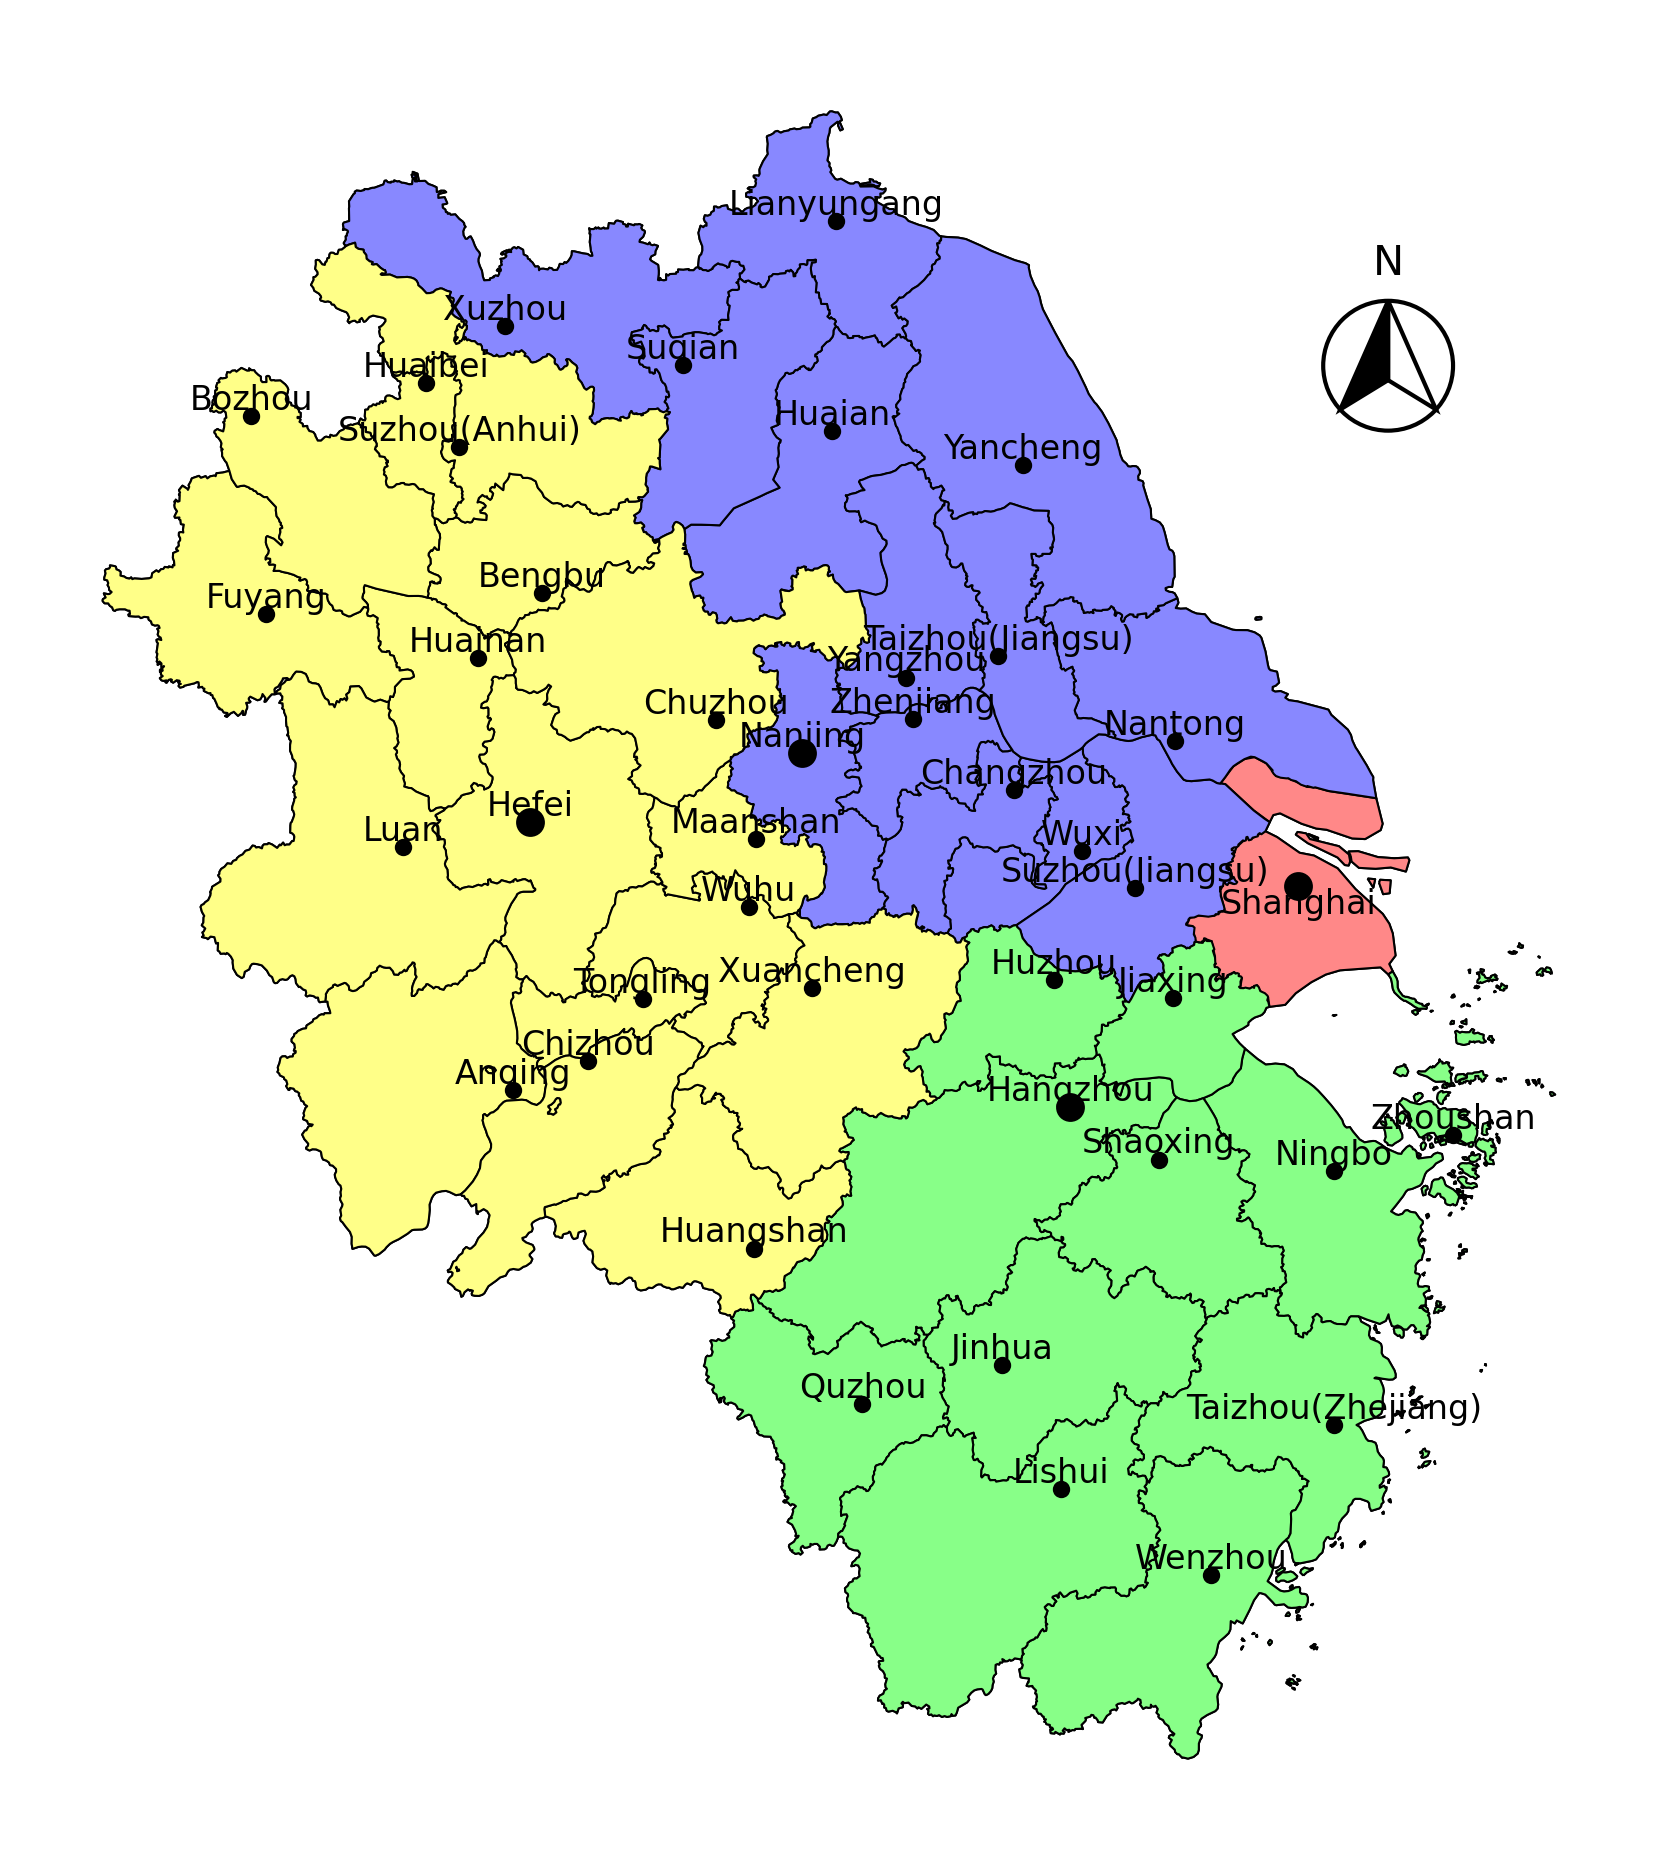

In [70]:
# Three Provinces and One Direct-Controlled Municipality

# Data
point = gpd.read_file('data/points_shp/points.shp')
point = point.to_crs(epsg=32649)

ply = ply.to_crs(epsg=32649)

# Convert the 'code' column to string type
ply['code'] = ply['code'].astype(str)

# Create a basic map
fig = plt.figure(1, (8, 8), dpi=300)
ax = plt.subplot(111)

merged_gdf.plot(ax=ax, facecolor="white", edgecolor="k", lw=0.5)

line_width_factor = 1.5 

sorted_df = df_compare.sort_values(by="Standard_deviation_Ordinary", ascending=False).head(25)

highlight_cities = ['Hangzhou', 'Nanjing', 'Shanghai', 'Hefei']
highlight_points = point[point['city'].isin(highlight_cities)]

highlight_points.plot(ax=ax, marker='o', color="black", markersize=35, zorder=10)
point[~point['city'].isin(highlight_cities)].plot(ax=ax, marker='o', color="black", markersize=10, zorder=10)

for point, label in zip(point.geometry, point['city']):
    x, y = point.x, point.y

    if label == 'Shanghai':
        plt.text(x, y - 90, label, fontsize=8, ha='center', va='top')
    else:
        plt.text(x, y + 90, label, fontsize=8, ha='center', va='bottom')

x = 0.85
y = 0.85
add_north(ax, x, y, text_size=10, arrow_width=0.06, arrow_height=0.06)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

for spine in ax.spines.values():
    spine.set_visible(False)

color_mapping = {
    '31': '#FF8888',  
    '32': '#8888FF',  
    '33': '#88FF88',  
    '34': '#FFFF88',  
}
ply['color'] = ply['code'].apply(lambda x: color_mapping.get(x[:2], 'gray'))
ply.plot(ax=ax, facecolor=ply['color'], edgecolor="k", lw=0.5)

plt.savefig('YRD.jpg', dpi=300)
plt.show()

### 3.3 Other visualizations and descriptive statistics

#### 3.3.1 Comparison of Inflow and Outflow for 41 Cities

In [71]:
#df_compare

In [72]:
# Inflow
data_kept_columns_dest.head(1)

DestCity    Total  20220901  20220902  20220903  20220904  20220905  \
0   Anqing  2742.39     46.13     44.45     49.88     51.35      50.7   

   20220906  20220907  20220908  ...  20221009  20221010  20221011  20221012  \
0     52.18     57.12     62.51  ...     42.97      48.1     54.66     56.34   

   20221013  20221014  20221015  20221016  20221017  20221018  
0     57.81     61.17     68.67     66.61     62.93     64.01  

[1 rows x 50 columns]

In [73]:
# Outflow
orig_city_keep.head(1)

OrigCity    Total  20220901  20220902  20220903  20220904  20220905  \
0   Anqing  3831.12     79.48     81.28     82.28     80.86     81.39   

   20220906  20220907  20220908  ...  20221009  20221010  20221011  20221012  \
0     79.43      78.3     79.66  ...     77.14     74.91     75.06     74.47   

   20221013  20221014  20221015  20221016  20221017  20221018  
0     76.31     77.41     77.76     77.81     77.61     77.52  

[1 rows x 50 columns]

In [74]:
# Net Inflow
data_combined.head(1)

OrigCity    Total  20220901  20220902  20220903  20220904  20220905  \
0   Anqing -1088.73    -33.35    -36.83     -32.4    -29.51    -30.69   

   20220906  20220907  20220908  ...  20221009  20221010  20221011  20221012  \
0    -27.25    -21.18    -17.15  ...    -34.17    -26.81     -20.4    -18.13   

   20221013  20221014  20221015  20221016  20221017  20221018  
0     -18.5    -16.24     -9.09     -11.2    -14.68    -13.51  

[1 rows x 50 columns]

In [75]:
x = list(data_combined.keys())[2:]  
x = [i[4:] for i in x] 
n = len(x)
#x

In [76]:
# Calculate the total inflow
data_total_in = data_kept_columns_dest.iloc[:,1]
data_total_in_sum = sum(data_total_in)
data_total_in_sum

167786.63

In [77]:
 #Calculate the total outflow
data_total_out = orig_city_keep.iloc[:,1]
data_total_out_sum = sum(data_total_out)
data_total_out_sum

167786.62999999998

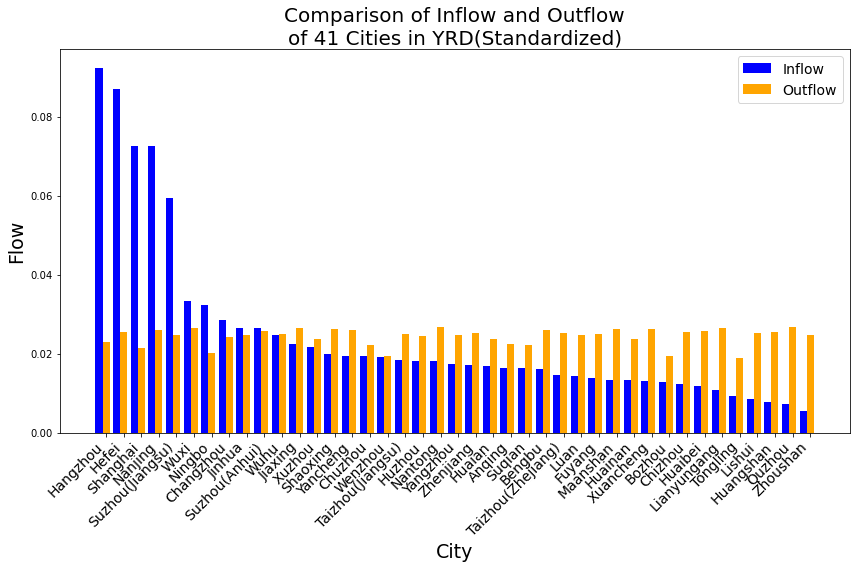

In [78]:
# Increase the height and width of the figure
plt.figure(figsize=(12, 8))  

# Standardize the inflow and outflow of personnel
x2 = list(data_total_in.index)
y1 = list(data_total_in / data_total_in_sum)
y2 = list(data_total_out / data_total_out_sum)
width = 0.4 
xx = np.arange(len(x2))
xxx = xx + width

# Sort cities in descending order based on inflow values
sorted_data = sorted(zip(data_kept_columns_dest['DestCity'], y1), key=lambda x: x[1], reverse=True)
sorted_cities, sorted_y1 = zip(*sorted_data)

plt.title("Comparison of Inflow and Outflow\nof 41 Cities in YRD(Standardized)", fontsize=20)  
plt.bar(xx, sorted_y1, color='blue', width=width)
plt.bar(xxx, y2, color='orange', width=width)
plt.legend(labels=["Inflow", "Outflow"], fontsize=14) 

# Labeling X and Y axes with larger font size
plt.xlabel("City", fontsize=19)
plt.ylabel("Flow", fontsize=19)

# Adjust the rotation angle of X-axis labels to avoid overlap
plt.xticks(xx + width, labels=sorted_cities, rotation=45, ha='right', fontsize=14)

plt.subplots_adjust(bottom=0.25) 

plt.tight_layout() 

plt.savefig('Comparison of Inflow and Outflow of 41 Cities in YRD (Standardized).jpg', dpi=300)
plt.show()

#### 3.3.2 Net Population Flow for 41 Cities (Standardization)

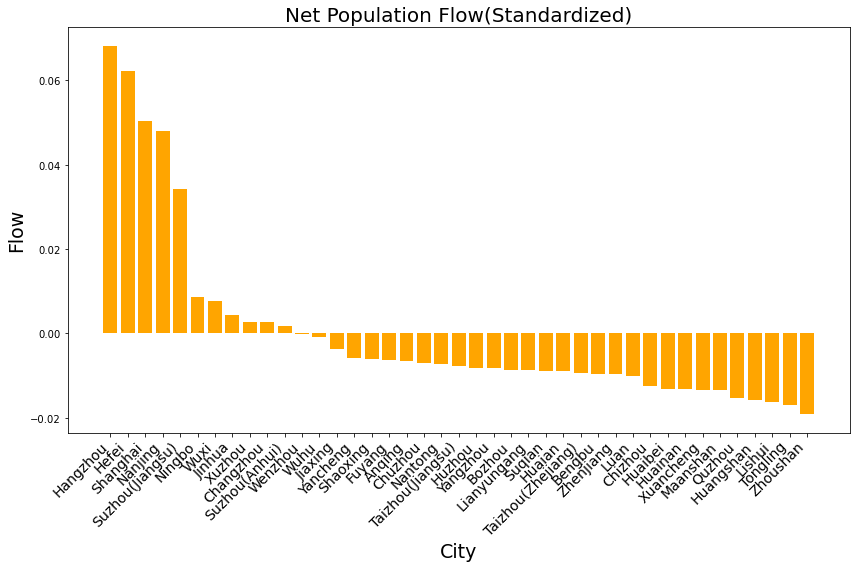

In [79]:
data_combined['NewValue'] = data_combined['Total'] / data_total_in_sum # Divide by the total personnel flow

# Draw a bar chart and sort in descending order
data_combined_sorted = data_combined.sort_values(by='NewValue', ascending=False)

# Draw a bar chart
plt.figure(figsize=(12, 8))
plt.bar(data_combined_sorted['OrigCity'], data_combined_sorted['NewValue'], color='orange') 
plt.xlabel("City", fontsize=19)  
plt.ylabel("Flow", fontsize=19)   

plt.title("Net Population Flow(Standardized)", fontsize=20) 
plt.xticks(rotation=45, ha='right', fontsize=14)  
plt.tight_layout()  

plt.savefig('Net Population Flow (Standardized).jpg', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()

#### 3.3.3 Comparison of Within-Province and Between-Province Average Flows

In [80]:
data_copy = df.copy()
data_copy.head()

No  OrigCode  OrigCity  DestCode         DestCity  \
1   1    310000  Shanghai    320100          Nanjing   
2   2    310000  Shanghai    320200             Wuxi   
3   3    310000  Shanghai    320300           Xuzhou   
4   4    310000  Shanghai    320400        Changzhou   
5   5    310000  Shanghai    320500  Suzhou(Jiangsu)   

   Standard_deviation_Ordinary  Standard_deviation_holiday  Total_Ordinary  \
1                     0.254373                    0.225765           90.92   
2                     0.274290                    0.378330          129.47   
3                     0.142568                    0.211438           21.72   
4                     0.146421                    0.232436           65.09   
5                     2.893489                    5.292366          944.87   

   Total_holiday    Total  ...  density of highway_Orig  population_Dest  \
1          26.36   117.28  ...                   206.33          9319700   
2          38.20   167.67  ...                   206.33          7464000   
3           8.78    30.50  ...                   206.33          9083900   
4          21.01    86.10  ...                   206.33          5279600   
5         244.24  1189.11  ...                   206.33         12749600   

   GDP growth rate_Dest  house rate_Dest  higher education institutions _Dest  \
1                   7.5         0.018579                                   51   
2                   8.8         0.848554                                   13   
3                   8.7         0.533353                                   12   
4                   9.1         0.842599                                   11   
5                   8.7         0.240529                                   26   

   Income growth rate_Dest  tourist_Dest  industrial enterprises_Dest  \
1                 0.089411            27                         3975   
2                 0.089146            30                         7721   
3                 0.088452            20                         2557   
4                 0.087446            13                         5662   
5                 0.083448            40                        12493   

   star hotel_Dest  density of highway_Dest  
1               60                   147.95  
2               29                   168.64  
3               15                   134.80  
4               30                   194.39  
5               63                   133.51  

[5 rows x 78 columns]

In [81]:
data_copy["OrigCode"] = data_copy["OrigCode"].map(lambda x: str(x)[:2])
data_copy["DestCode"] = data_copy["DestCode"].map(lambda x: str(x)[:2])
data_copy.head()

No OrigCode  OrigCity DestCode         DestCity  \
1   1       31  Shanghai       32          Nanjing   
2   2       31  Shanghai       32             Wuxi   
3   3       31  Shanghai       32           Xuzhou   
4   4       31  Shanghai       32        Changzhou   
5   5       31  Shanghai       32  Suzhou(Jiangsu)   

   Standard_deviation_Ordinary  Standard_deviation_holiday  Total_Ordinary  \
1                     0.254373                    0.225765           90.92   
2                     0.274290                    0.378330          129.47   
3                     0.142568                    0.211438           21.72   
4                     0.146421                    0.232436           65.09   
5                     2.893489                    5.292366          944.87   

   Total_holiday    Total  ...  density of highway_Orig  population_Dest  \
1          26.36   117.28  ...                   206.33          9319700   
2          38.20   167.67  ...                   206.33          7464000   
3           8.78    30.50  ...                   206.33          9083900   
4          21.01    86.10  ...                   206.33          5279600   
5         244.24  1189.11  ...                   206.33         12749600   

   GDP growth rate_Dest  house rate_Dest  higher education institutions _Dest  \
1                   7.5         0.018579                                   51   
2                   8.8         0.848554                                   13   
3                   8.7         0.533353                                   12   
4                   9.1         0.842599                                   11   
5                   8.7         0.240529                                   26   

   Income growth rate_Dest  tourist_Dest  industrial enterprises_Dest  \
1                 0.089411            27                         3975   
2                 0.089146            30                         7721   
3                 0.088452            20                         2557   
4                 0.087446            13                         5662   
5                 0.083448            40                        12493   

   star hotel_Dest  density of highway_Dest  
1               60                   147.95  
2               29                   168.64  
3               15                   134.80  
4               30                   194.39  
5               63                   133.51  

[5 rows x 78 columns]

In [82]:
data_new = pd.DataFrame()
data_new["OrigCode"] = data_copy["OrigCode"]
data_new["DestCode"] = data_copy["DestCode"]
data_new["Total"] = data_copy["Total"]
data_new["Dist"] = data_copy["Dist"].map(lambda x: round(x * 100))
data_new

OrigCode DestCode    Total  Dist
1          31       32   117.28   282
2          31       32   167.67   121
3          31       32    30.50   517
4          31       32    86.10   164
5          31       32  1189.11    90
...       ...      ...      ...   ...
1675       34       34    19.83   353
1676       34       34    18.27   324
1677       34       34    35.70   237
1678       34       34    15.62   416
1679       34       34    68.95   129

[1640 rows x 4 columns]

In [83]:
data_new_city = data_new[data_new["OrigCode"] != data_new["DestCode"]]
data_new_pro = data_new[data_new["OrigCode"] == data_new["DestCode"]]

y_city = []
y_pro = []
data_new_city150 = data_new_city[data_new_city["Dist"] <= 150]
y_city.append(data_new_city150["Total"].mean())
data_new_pro150 = data_new_pro[data_new_pro["Dist"] <= 150]
y_pro.append(data_new_pro150["Total"].mean())
for i in range(6):
    idx = 150 + 50 * i
    val = data_new_city[(data_new_city["Dist"] <= (idx + 50)) & (data_new_city["Dist"] > idx)]["Total"].mean()
    y_city.append(val)
    y_pro.append(data_new_pro[(data_new_pro["Dist"] <= (idx + 50)) & (data_new_pro["Dist"] > idx)]["Total"].mean())

data_new_city450 = data_new_city[data_new_city["Dist"] > 450]
y_city.append(data_new_city450["Total"].mean())
data_new_pro450 = data_new_pro[data_new_pro["Dist"] > 450]
y_pro.append(data_new_pro450["Total"].mean())
print(y_city) 
print(y_pro)                             

[222.41273809523813, 75.67682926829269, 36.46094202898551, 26.881866666666667, 26.91647058823531, 17.186268656716422, 24.21468253968255, 20.18280000000001]
[421.4446999999998, 170.45105769230776, 124.404375, 69.29846153846151, 41.411944444444444, 59.78888888888889, 54.12416666666669, 17.705]


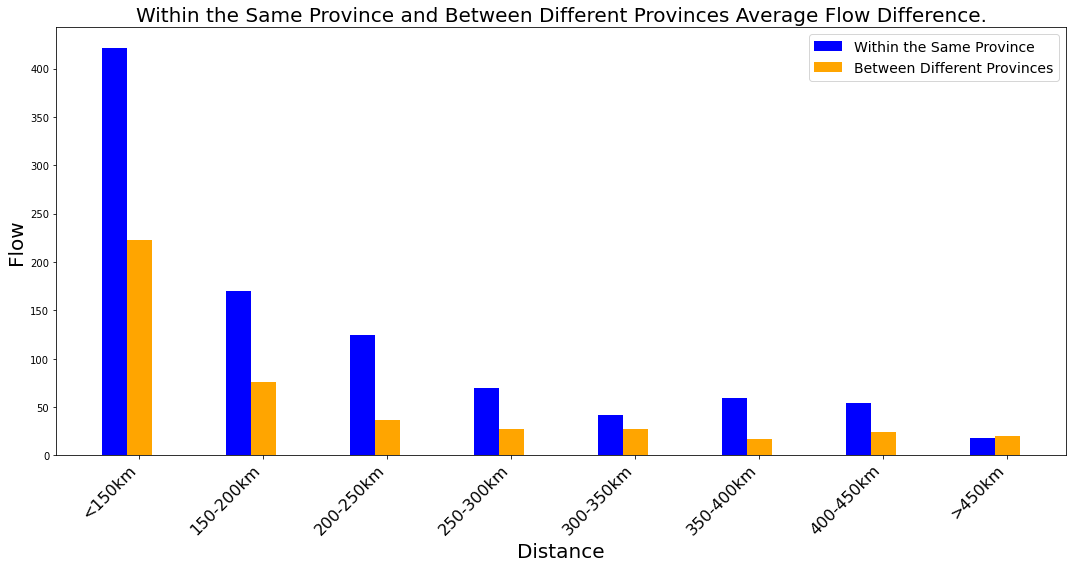

In [84]:
x4 = ["<150km","150-200km","200-250km","250-300km","300-350km","350-400km","400-450km",">450km"]
plt.figure(figsize=(15, 8)) 

width = 0.2
xx = np.arange(len(x4))
xxx = xx + width

plt.title("Within the Same Province and Between Different Provinces Average Flow Difference.", fontsize=20)

plt.bar(xx, y_pro, color='blue', width=width)
plt.bar(xxx, y_city, color='orange', width=width)
plt.legend(labels=["Within the Same Province", "Between Different Provinces"], fontsize=14)

plt.xticks(xx + width, labels=x4, rotation=45, ha='right', fontsize=16) 
# Average personnel flow
plt.xlabel("Distance", fontsize=20)
plt.ylabel("Flow", fontsize=20)

plt.tight_layout() 
plt.savefig('Within the Same Province and Between Different Provinces Average Flow Difference.jpg', dpi=300)
plt.show()

## 4. Basic gravity model 

### 4.1 Correlation Analysis

In [85]:
df

No  OrigCode   OrigCity  DestCode         DestCity  \
1        1    310000   Shanghai    320100          Nanjing   
2        2    310000   Shanghai    320200             Wuxi   
3        3    310000   Shanghai    320300           Xuzhou   
4        4    310000   Shanghai    320400        Changzhou   
5        5    310000   Shanghai    320500  Suzhou(Jiangsu)   
...    ...       ...        ...       ...              ...   
1675  1636    341800  Xuancheng    341200           Fuyang   
1676  1637    341800  Xuancheng    341300    Suzhou(Anhui)   
1677  1638    341800  Xuancheng    341500             Luan   
1678  1639    341800  Xuancheng    341600           Bozhou   
1679  1640    341800  Xuancheng    341700          Chizhou   

      Standard_deviation_Ordinary  Standard_deviation_holiday  Total_Ordinary  \
1                        0.254373                    0.225765           90.92   
2                        0.274290                    0.378330          129.47   
3                        0.142568                    0.211438           21.72   
4                        0.146421                    0.232436           65.09   
5                        2.893489                    5.292366          944.87   
...                           ...                         ...             ...   
1675                     0.217183                    0.218443           15.68   
1676                     0.107706                    0.302849           12.16   
1677                     0.158754                    0.402909           24.83   
1678                     0.094106                    0.271142           10.04   
1679                     0.228479                    0.434236           52.01   

      Total_holiday    Total  ...  density of highway_Orig  population_Dest  \
1             26.36   117.28  ...                   206.33          9319700   
2             38.20   167.67  ...                   206.33          7464000   
3              8.78    30.50  ...                   206.33          9083900   
4             21.01    86.10  ...                   206.33          5279600   
5            244.24  1189.11  ...                   206.33         12749600   
...             ...      ...  ...                      ...              ...   
1675           4.15    19.83  ...                   106.70          8171000   
1676           6.11    18.27  ...                   106.70          5325000   
1677          10.87    35.70  ...                   106.70          4405000   
1678           5.58    15.62  ...                   106.70          4986000   
1679          16.94    68.95  ...                   106.70          1331000   

      GDP growth rate_Dest  house rate_Dest  \
1                     7.50         0.018579   
2                     8.80         0.848554   
3                     8.70         0.533353   
4                     9.10         0.842599   
5                     8.70         0.240529   
...                    ...              ...   
1675                  9.49         0.085865   
1676                  6.00         0.299644   
1677                 15.21         0.121458   
1678                  9.23         0.408087   
1679                 15.57         0.586287   

      higher education institutions _Dest  Income growth rate_Dest  \
1                                      51                 0.089411   
2                                      13                 0.089146   
3                                      12                 0.088452   
4                                      11                 0.087446   
5                                      26                 0.083448   
...                                   ...                      ...   
1675                                    6                 0.081506   
1676                                    4                 0.084485   
1677                                    4                 0.093500   
1678                                    2                 0.092479   
1679  

In [86]:
print(df.columns)

Index(['No', 'OrigCode', 'OrigCity', 'DestCode', 'DestCity',
       'Standard_deviation_Ordinary', 'Standard_deviation_holiday',
       'Total_Ordinary', 'Total_holiday', 'Total', '20220901', '20220902',
       '20220903', '20220904', '20220905', '20220906', '20220907', '20220908',
       '20220909', '20220910', '20220911', '20220912', '20220913', '20220914',
       '20220915', '20220916', '20220917', '20220918', '20220919', '20220920',
       '20220921', '20220922', '20220923', '20220924', '20220925', '20220926',
       '20220927', '20220928', '20220929', '20220930', '20221001', '20221002',
       '20221003', '20221004', '20221005', '20221006', '20221007', '20221008',
       '20221009', '20221010', '20221011', '20221012', '20221013', '20221014',
       '20221015', '20221016', '20221017', '20221018', 'Dist', 'Dist_cert',
       'population_Orig', 'GDP growth rate_Orig', 'house rate_Orig',
       'higher education institutions _Orig', 'Income growth rate_Orig',
       'tourist_Orig', 'i

In [87]:
# Hypothesized column name changes and columns to retain
new_column_names = {
    'population_Orig': 'pop_Orig',
    'population_Dest': 'pop_Dest',
    'GDP_Orig': 'GDP_Orig',
    'GDP_Dest': 'GDP_Dest',
    'GDP growth rate_Orig': 'GDPrate_Orig',
    'GDP growth rate_Dest': 'GDPrate_Dest',
    'Per GDP_Orig':'PerGDP_Orig',
    'Per GDP_Dest':'PerGDP_Dest',
    'average house price _Orig': 'house_Orig',
    'average house price _Dest': 'house_Dest',
    'house rate_Orig': 'houserate_Orig',
    'house rate_Dest': 'houserate_Dest',    
    'higher education institutions _Orig': 'education_Orig',
    'higher education institutions _Dest': 'education_Dest',
    'Income growth rate_Orig': 'incomerate_Orig',
    'Income growth rate_Dest': 'incomerate_Dest',
    'hospital_Orig': 'h_Orig',
    'hospital_Dest': 'h_Dest',
    'motorway_Orig': 'm_Orig',
    'motorway_Dest': 'm_Dest',
    'industrial enterprises_Orig':'industrial_Orig',
    'industrial enterprises_Dest':'industrial_Dest',
    'average wage_Orig': 'averagewage_Orig',
    'average wage_Dest': 'averagewage_Dest',
    'average wage rate_Orig': 'averagewagerate_Orig',
    'average wage rate_Dest': 'averagewagerate_Dest',
    'star hotel_Orig':'starhotel_Orig',
    'star hotel_Dest':'starhotel_Dest',
    'tourist_Orig':'tourist_Orig',
    'tourist_Dest':'tourist_Dest',
    'density of highway_Orig':'denshighway_Orig',
    'density of highway_Dest':'denshighway_Dest',
    'highway mileage_Orig':'highwayml_Orig',
    'highway mileage_Dest':'highwayml_Dest',
}

# Use the rename() method to modify column names and assign the result to df_rg
df_rg = df.rename(columns=new_column_names)

df_rg.head()

No  OrigCode  OrigCity  DestCode         DestCity  \
1   1    310000  Shanghai    320100          Nanjing   
2   2    310000  Shanghai    320200             Wuxi   
3   3    310000  Shanghai    320300           Xuzhou   
4   4    310000  Shanghai    320400        Changzhou   
5   5    310000  Shanghai    320500  Suzhou(Jiangsu)   

   Standard_deviation_Ordinary  Standard_deviation_holiday  Total_Ordinary  \
1                     0.254373                    0.225765           90.92   
2                     0.274290                    0.378330          129.47   
3                     0.142568                    0.211438           21.72   
4                     0.146421                    0.232436           65.09   
5                     2.893489                    5.292366          944.87   

   Total_holiday    Total  ...  denshighway_Orig  pop_Dest  GDPrate_Dest  \
1          26.36   117.28  ...            206.33   9319700           7.5   
2          38.20   167.67  ...            206.33   7464000           8.8   
3           8.78    30.50  ...            206.33   9083900           8.7   
4          21.01    86.10  ...            206.33   5279600           9.1   
5         244.24  1189.11  ...            206.33  12749600           8.7   

   houserate_Dest  education_Dest  incomerate_Dest  tourist_Dest  \
1        0.018579              51         0.089411            27   
2        0.848554              13         0.089146            30   
3        0.533353              12         0.088452            20   
4        0.842599              11         0.087446            13   
5        0.240529              26         0.083448            40   

   industrial_Dest  starhotel_Dest  denshighway_Dest  
1             3975              60            147.95  
2             7721              29            168.64  
3             2557              15            134.80  
4             5662              30            194.39  
5            12493              63            133.51  

[5 rows x 78 columns]

In [88]:
df_rg.isnull().sum()

No                  0
OrigCode            0
OrigCity            0
DestCode            0
DestCity            0
                   ..
incomerate_Dest     0
tourist_Dest        0
industrial_Dest     0
starhotel_Dest      0
denshighway_Dest    0
Length: 78, dtype: int64

In [89]:
df_rg.dropna()

No  OrigCode   OrigCity  DestCode         DestCity  \
1        1    310000   Shanghai    320100          Nanjing   
2        2    310000   Shanghai    320200             Wuxi   
3        3    310000   Shanghai    320300           Xuzhou   
4        4    310000   Shanghai    320400        Changzhou   
5        5    310000   Shanghai    320500  Suzhou(Jiangsu)   
...    ...       ...        ...       ...              ...   
1675  1636    341800  Xuancheng    341200           Fuyang   
1676  1637    341800  Xuancheng    341300    Suzhou(Anhui)   
1677  1638    341800  Xuancheng    341500             Luan   
1678  1639    341800  Xuancheng    341600           Bozhou   
1679  1640    341800  Xuancheng    341700          Chizhou   

      Standard_deviation_Ordinary  Standard_deviation_holiday  Total_Ordinary  \
1                        0.254373                    0.225765           90.92   
2                        0.274290                    0.378330          129.47   
3                        0.142568                    0.211438           21.72   
4                        0.146421                    0.232436           65.09   
5                        2.893489                    5.292366          944.87   
...                           ...                         ...             ...   
1675                     0.217183                    0.218443           15.68   
1676                     0.107706                    0.302849           12.16   
1677                     0.158754                    0.402909           24.83   
1678                     0.094106                    0.271142           10.04   
1679                     0.228479                    0.434236           52.01   

      Total_holiday    Total  ...  denshighway_Orig  pop_Dest  GDPrate_Dest  \
1             26.36   117.28  ...            206.33   9319700          7.50   
2             38.20   167.67  ...            206.33   7464000          8.80   
3              8.78    30.50  ...            206.33   9083900          8.70   
4             21.01    86.10  ...            206.33   5279600          9.10   
5            244.24  1189.11  ...            206.33  12749600          8.70   
...             ...      ...  ...               ...       ...           ...   
1675           4.15    19.83  ...            106.70   8171000          9.49   
1676           6.11    18.27  ...            106.70   5325000          6.00   
1677          10.87    35.70  ...            106.70   4405000         15.21   
1678           5.58    15.62  ...            106.70   4986000          9.23   
1679          16.94    68.95  ...            106.70   1331000         15.57   

      houserate_Dest  education_Dest  incomerate_Dest  tourist_Dest  \
1           0.018579              51         0.089411            27   
2           0.848554              13         0.089146            30   
3           0.533353              12         0.088452            20   
4           0.842599              11         0.087446            13   
5           0.240529              26         0.083448            40   
...              ...             ...              ...           ...   
1675        0.085865               6         0.081506             7   
1676        0.299644               4         0.084485             7   
1677        0.121458               4         0.093500            26   
1678        0.408087               2         0.092479             9   
1679        0.586287               3         0.086515            18   

      industrial_Dest  starhotel_Dest  denshighway_Dest  
1                3975              60            147.95  
2                7721              29            168.64  
3                2557              15            134.80  
4                5662              30            194.39  
5               12493              63            133.51  
...               ...             ...               ...  
1675             1571               4            217.68  
1676             1081   

In [90]:
# Select the columns to be retained
selected_columns = ['pop_Orig', 
                    'GDPrate_Orig',
                    'houserate_Orig', 
                    'education_Orig', 
                    'incomerate_Orig', 
                    'starhotel_Orig',
                    'tourist_Orig',
                    'pop_Dest',
                    'GDPrate_Dest',
                    'houserate_Dest', 
                    'education_Dest',
                    'incomerate_Dest',
                    'starhotel_Dest',
                    'tourist_Dest',
                    'Dist_cert',
                    'Total']

df_rg_Variables = df_rg[selected_columns].copy()
df_rg_Variables.head()

pop_Orig  GDPrate_Orig  houserate_Orig  education_Orig  incomerate_Orig  \
1  24894300           8.1        0.191131              64         0.078391   
2  24894300           8.1        0.191131              64         0.078391   
3  24894300           8.1        0.191131              64         0.078391   
4  24894300           8.1        0.191131              64         0.078391   
5  24894300           8.1        0.191131              64         0.078391   

   starhotel_Orig  tourist_Orig  pop_Dest  GDPrate_Dest  houserate_Dest  \
1             177            71   9319700           7.5        0.018579   
2             177            71   7464000           8.8        0.848554   
3             177            71   9083900           8.7        0.533353   
4             177            71   5279600           9.1        0.842599   
5             177            71  12749600           8.7        0.240529   

   education_Dest  incomerate_Dest  starhotel_Dest  tourist_Dest  Dist_cert  \
1              51         0.089411              60            27   2.734189   
2              13         0.089146              29            30   1.440786   
3              12         0.088452              15            20   5.060452   
4              11         0.087446              30            13   1.891013   
5              26         0.083448              63            40   0.844081   

     Total  
1   117.28  
2   167.67  
3    30.50  
4    86.10  
5  1189.11

In [91]:
plt.rcParams["axes.grid"] = False                                         
f = plt.figure(figsize=(19, 15))

plt.matshow(df_rg_Variables.corr(), fignum=f.number, cmap='coolwarm')

for i in range(df_rg_Variables.shape[1]):
    for j in range(df_rg_Variables.shape[1]):
        plt.text(j, i, "{:.2f}".format(df_rg_Variables.corr().iloc[i, j]), ha='center', va='center', fontsize=16) 

plt.xticks(range(df_rg_Variables.shape[1]), df_rg_Variables.columns, fontsize=18, rotation=90)  
plt.yticks(range(df_rg_Variables.shape[1]), df_rg_Variables.columns, fontsize=18)  
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18) 
plt.savefig('Correlation Matrix Among Variables.jpg', dpi=300)

### 4.2 Variance Inflation Factor (VIF)

In [92]:
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):

    while True:
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF", index=df_with_const.columns).to_frame()

        vif_df = vif_df.drop('const')

        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('VIF for {}: {}'.format(index_to_drop, vif_df.VIF.max())) 
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break

    return df  

In [93]:
df_rg_Variables.columns

Index(['pop_Orig', 'GDPrate_Orig', 'houserate_Orig', 'education_Orig',
       'incomerate_Orig', 'starhotel_Orig', 'tourist_Orig', 'pop_Dest',
       'GDPrate_Dest', 'houserate_Dest', 'education_Dest', 'incomerate_Dest',
       'starhotel_Dest', 'tourist_Dest', 'Dist_cert', 'Total'],
      dtype='object')

In [94]:
#sm.formula.ols

In [95]:
df_predictors_selected_VIF = drop_column_using_vif_(df_rg_Variables.drop('Total', axis=1))
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

VIF for starhotel_Orig: 7.990821040070092
Dropping: starhotel_Orig
VIF for starhotel_Dest: 7.985770515203879
Dropping: starhotel_Dest
The columns remaining after VIF selection are:
Index(['pop_Orig', 'GDPrate_Orig', 'houserate_Orig', 'education_Orig',
       'incomerate_Orig', 'tourist_Orig', 'pop_Dest', 'GDPrate_Dest',
       'houserate_Dest', 'education_Dest', 'incomerate_Dest', 'tourist_Dest',
       'Dist_cert'],
      dtype='object')


### 4.3 selection

Based on correlation analysis and VIF values, select and retain the independent variables that have the most significant impact on explaining the model, while trying to avoid using highly correlated independent variables.

Separate the holiday dataset and the regular dataset.

In [96]:
# Select the columns to be retained
selected_columns = ['No', 'OrigCode', 'OrigCity', 'DestCode', 'DestCity', 'Total_Ordinary',
       '20220901', '20220902', '20220903', '20220904', '20220905', '20220906',
       '20220907', '20220908', '20220913', '20220914', '20220915', '20220916',
       '20220917', '20220918', '20220919', '20220920', '20220921', '20220922',
       '20220923', '20220924', '20220925', '20220926', '20220927', '20220928',
       '20220929', '20221008', '20221009', '20221010', '20221011', '20221012',
       '20221013', '20221014', '20221015', '20221016', '20221017', '20221018',
                    'pop_Orig', 
                    'GDPrate_Orig',
                    'houserate_Orig', 
                    'education_Orig', 
                    'incomerate_Orig', 
                    'tourist_Orig',
                    'pop_Dest',
                    'GDPrate_Dest',
                    'houserate_Dest', 
                    'education_Dest',
                    'incomerate_Dest',
                    'tourist_Dest',
                    'Dist_cert'
                    ]
df_Ordinary = df_rg[selected_columns]
df_Ordinary

No  OrigCode   OrigCity  DestCode         DestCity  Total_Ordinary  \
1        1    310000   Shanghai    320100          Nanjing           90.92   
2        2    310000   Shanghai    320200             Wuxi          129.47   
3        3    310000   Shanghai    320300           Xuzhou           21.72   
4        4    310000   Shanghai    320400        Changzhou           65.09   
5        5    310000   Shanghai    320500  Suzhou(Jiangsu)          944.87   
...    ...       ...        ...       ...              ...             ...   
1675  1636    341800  Xuancheng    341200           Fuyang           15.68   
1676  1637    341800  Xuancheng    341300    Suzhou(Anhui)           12.16   
1677  1638    341800  Xuancheng    341500             Luan           24.83   
1678  1639    341800  Xuancheng    341600           Bozhou           10.04   
1679  1640    341800  Xuancheng    341700          Chizhou           52.01   

      20220901  20220902  20220903  20220904  ...  education_Orig  \
1         2.65      2.65      2.98      2.48  ...              64   
2         3.35      3.64      3.86      3.30  ...              64   
3         0.72      0.59      0.61      0.69  ...              64   
4         1.81      1.97      2.00      1.67  ...              64   
5        24.75     26.31     27.84     26.64  ...              64   
...        ...       ...       ...       ...  ...             ...   
1675      0.41      0.43      0.46      0.40  ...               1   
1676      0.31      0.43      0.64      0.47  ...               1   
1677      0.56      0.78      0.68      0.61  ...               1   
1678      0.25      0.28      0.63      0.38  ...               1   
1679      1.27      1.10      1.51      0.98  ...               1   

      incomerate_Orig  tourist_Orig  pop_Dest  GDPrate_Dest  houserate_Dest  \
1            0.078391            71   9319700          7.50        0.018579   
2            0.078391            71   7464000          8.80        0.848554   
3            0.078391            71   9083900          8.70        0.533353   
4            0.078391            71   5279600          9.10        0.842599   
5            0.078391            71  12749600          8.70        0.240529   
...               ...           ...       ...           ...             ...   
1675         0.094510            24   8171000          9.49        0.085865   
1676         0.094510            24   5325000          6.00        0.299644   
1677         0.094510            24   4405000         15.21        0.121458   
1678         0.094510            24   4986000          9.23        0.408087   
1679         0.094510            24   1331000         15.57        0.586287   

      education_Dest  incomerate_Dest  tourist_Dest  Dist_cert  
1                 51         0.089411            27   2.734189  
2                 13         0.089146            30   1.440786  
3                 12         0.088452            20   5.060452  
4                 11         0.087446            13   1.891013  
5                 26         0.083448            40   0.844081  
...              ...              ...           ...        ...  
1675               6         0.081506             7   3.858544  
1676               4         0.084485             7   3.573810  
1677               4         0.093500            26   2.797628  
1678               2         0.092479             9   3.833867  
1679               3         0.086515            18   1.541129  

[1640 rows x 55 columns]

In [97]:
# Select the columns to be retained
selected_columns = ['No', 'OrigCode', 'OrigCity', 'DestCode', 'DestCity', 'Total_holiday',
       '20220909', '20220910', '20220911', '20220912', '20220930','20221001', '20221002', '20221003', '20221004', '20221005', '20221006', '20221007', 
                    'pop_Orig', 
                    'GDPrate_Orig',
                    'houserate_Orig', 
                    'education_Orig', 
                    'incomerate_Orig', 
                    'tourist_Orig',
                    'pop_Dest',
                    'GDPrate_Dest',
                    'houserate_Dest', 
                    'education_Dest',
                    'incomerate_Dest',
                    'tourist_Dest',
                    'Dist_cert'
                    ]
df_holiday = df_rg[selected_columns]
df_holiday

No  OrigCode   OrigCity  DestCode         DestCity  Total_holiday  \
1        1    310000   Shanghai    320100          Nanjing          26.36   
2        2    310000   Shanghai    320200             Wuxi          38.20   
3        3    310000   Shanghai    320300           Xuzhou           8.78   
4        4    310000   Shanghai    320400        Changzhou          21.01   
5        5    310000   Shanghai    320500  Suzhou(Jiangsu)         244.24   
...    ...       ...        ...       ...              ...            ...   
1675  1636    341800  Xuancheng    341200           Fuyang           4.15   
1676  1637    341800  Xuancheng    341300    Suzhou(Anhui)           6.11   
1677  1638    341800  Xuancheng    341500             Luan          10.87   
1678  1639    341800  Xuancheng    341600           Bozhou           5.58   
1679  1640    341800  Xuancheng    341700          Chizhou          16.94   

      20220909  20220910  20220911  20220912  ...  education_Orig  \
1         2.40      2.65      2.08      2.47  ...              64   
2         3.26      3.76      3.41      3.49  ...              64   
3         0.95      0.76      0.48      0.52  ...              64   
4         2.21      2.19      1.71      1.74  ...              64   
5        20.14     23.23     29.32     25.10  ...              64   
...        ...       ...       ...       ...  ...             ...   
1675      0.81      0.68      0.33      0.23  ...               1   
1676      0.58      0.57      0.19      0.19  ...               1   
1677      0.95      0.93      0.35      0.39  ...               1   
1678      0.48      0.48      0.32      0.17  ...               1   
1679      1.31      1.60      0.94      0.87  ...               1   

      incomerate_Orig  tourist_Orig  pop_Dest  GDPrate_Dest  houserate_Dest  \
1            0.078391            71   9319700          7.50        0.018579   
2            0.078391            71   7464000          8.80        0.848554   
3            0.078391            71   9083900          8.70        0.533353   
4            0.078391            71   5279600          9.10        0.842599   
5            0.078391            71  12749600          8.70        0.240529   
...               ...           ...       ...           ...             ...   
1675         0.094510            24   8171000          9.49        0.085865   
1676         0.094510            24   5325000          6.00        0.299644   
1677         0.094510            24   4405000         15.21        0.121458   
1678         0.094510            24   4986000          9.23        0.408087   
1679         0.094510            24   1331000         15.57        0.586287   

      education_Dest  incomerate_Dest  tourist_Dest  Dist_cert  
1                 51         0.089411            27   2.734189  
2                 13         0.089146            30   1.440786  
3                 12         0.088452            20   5.060452  
4                 11         0.087446            13   1.891013  
5                 26         0.083448            40   0.844081  
...              ...              ...           ...        ...  
1675               6         0.081506             7   3.858544  
1676               4         0.084485             7   3.573810  
1677               4         0.093500            26   2.797628  
1678               2         0.092479             9   3.833867  
1679               3         0.086515            18   1.541129  

[1640 rows x 31 columns]

### 4.4 Modelling

In [98]:
# Holidays and Regular Days

# Extract variables and take their logarithms
x_variables = ["pop_Orig", "pop_Dest", 
               "GDPrate_Orig","GDPrate_Dest",
               "houserate_Orig","houserate_Dest",
               "education_Orig", "education_Dest", 
               "incomerate_Orig", "incomerate_Dest",
               "tourist_Orig","tourist_Dest",
               "Dist_cert"
              ]
log_x_vars = []
for x in x_variables:
    df_rg[f"log_{x}"] = np.log(df_rg[x])
    log_x_vars.append(f"log_{x}")
    
# Create a formula
formula = 'Total ~  log_pop_Orig + log_pop_Dest + log_GDPrate_Orig + log_GDPrate_Dest + log_houserate_Orig + log_houserate_Dest + log_education_Orig +  log_education_Dest + log_incomerate_Orig + log_incomerate_Dest + log_tourist_Orig + log_tourist_Dest + log_Dist_cert'

# run the regression
uncosim = smf.glm(formula = formula, 
                  data=df_rg, 
                  family=sm.families.Poisson()).fit()

In [99]:
# Extract summary of the unconstrained model
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                 1640
Model:                            GLM   Df Residuals:                     1626
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -42194.
Date:                Wed, 23 Aug 2023   Deviance:                       75817.
Time:                        22:48:36   Pearson chi2:                 8.86e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.3917    

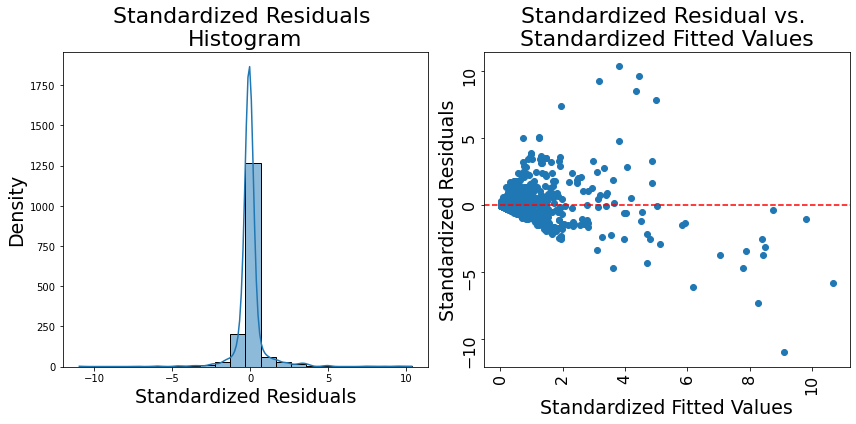

In [100]:
# Calculate the residuals of the model
residuals = uncosim.resid_response

# Calculate standardized residuals
std_residuals = residuals / np.std(residuals)

# Calculate standardized predicted values
std_fitted = uncosim.mu / np.std(uncosim.mu)

# Create a canvas with two subplots
plt.figure(figsize=(12, 6))

# Plot a histogram of standardized residuals
plt.subplot(1, 2, 1)
sns.histplot(std_residuals, bins=22, kde=True, color=None, edgecolor='black')
plt.title('Standardized Residuals \nHistogram', fontsize=22)
plt.xlabel('Standardized Residuals', fontsize=19)
plt.ylabel('Density', fontsize=19)

# Plot a scatter plot of standardized predicted values
plt.subplot(1, 2, 2)
plt.scatter(std_fitted, std_residuals, color=None)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal dashed line
plt.title('Standardized Residual vs. \nStandardized Fitted Values', fontsize=22)
plt.xlabel('Standardized Fitted Values', fontsize=19)
plt.ylabel('Standardized Residuals', fontsize=19)
plt.xticks(rotation=90, fontsize=16) 
plt.yticks(rotation=90, fontsize=16)  

plt.tight_layout()

# Save the image to a local file
plt.savefig('residual_plots_Total.png')

plt.show()

In [101]:
# Holiday

# Extract variables and take their logarithms
x_variables = ["pop_Orig", "pop_Dest", 
               "GDPrate_Orig","GDPrate_Dest",
               "houserate_Orig","houserate_Dest",
               "education_Orig", "education_Dest", 
               "incomerate_Orig", "incomerate_Dest",
               "tourist_Orig","tourist_Dest",
               "Dist_cert"
              ]
log_x_vars = []
for x in x_variables:
    df_holiday[f"log_{x}"] = np.log(df_holiday[x])
    log_x_vars.append(f"log_{x}")
    
# Create a formula
formula = 'Total_holiday ~  log_pop_Orig + log_pop_Dest + log_GDPrate_Orig + log_GDPrate_Dest + log_houserate_Orig + log_houserate_Dest + log_education_Orig +  log_education_Dest + log_incomerate_Orig + log_incomerate_Dest + log_tourist_Orig + log_tourist_Dest  + log_Dist_cert'

#run the regression
uncosim_holiday = smf.glm(formula = formula, 
                  data=df_holiday, 
                  family=sm.families.Poisson()).fit()

In [102]:
# Extract summary of the unconstrained model
print(uncosim_holiday.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Total_holiday   No. Observations:                 1640
Model:                            GLM   Df Residuals:                     1626
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13433.
Date:                Wed, 23 Aug 2023   Deviance:                       20427.
Time:                        22:48:37   Pearson chi2:                 2.36e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.2949    

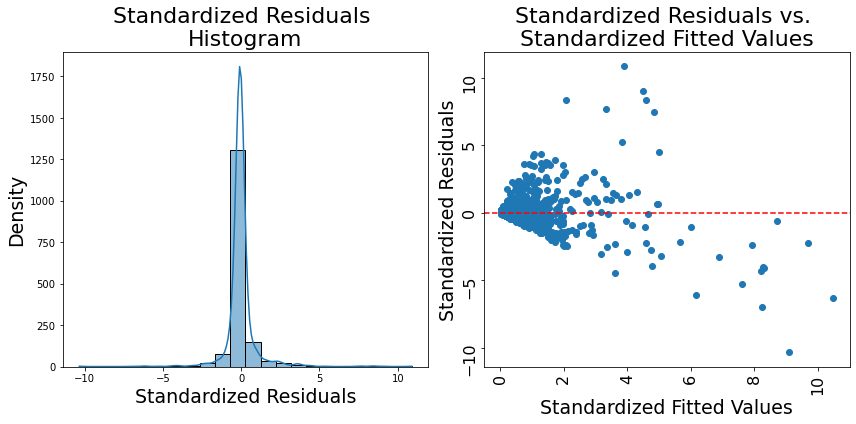

In [103]:
# Calculate the residuals of the model
residuals = uncosim_holiday.resid_response

# Calculate standardized residuals
std_residuals = residuals / np.std(residuals)

# Calculate standardized predicted values
std_fitted = uncosim_holiday.mu / np.std(uncosim_holiday.mu)

# Create a canvas with two subplots
plt.figure(figsize=(12, 6))

# Plot a histogram of standardized residuals
plt.subplot(1, 2, 1)
sns.histplot(std_residuals, bins=22, kde=True, color=None, edgecolor='black')
plt.title('Standardized Residuals \nHistogram', fontsize=22)
plt.xlabel('Standardized Residuals', fontsize=19)
plt.ylabel('Density', fontsize=19)

# Plot a scatter plot of standardized predicted values
plt.subplot(1, 2, 2)
plt.scatter(std_fitted, std_residuals, color=None)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal dashed line
plt.title('Standardized Residuals vs. \nStandardized Fitted Values', fontsize=22)
plt.xlabel('Standardized Fitted Values', fontsize=19)
plt.ylabel('Standardized Residuals', fontsize=19)
plt.xticks(rotation=90, fontsize=16) 
plt.yticks(rotation=90, fontsize=16)  

plt.tight_layout()

# Save the image to a local file
plt.savefig('residual_plots_Holiday.png')

plt.show()

In [104]:
# Regular Days

# Extract variables and take their logarithms
x_variables = ["pop_Orig", "pop_Dest", 
               "GDPrate_Orig","GDPrate_Dest",
               "houserate_Orig","houserate_Dest",
               "education_Orig", "education_Dest", 
               "incomerate_Orig", "incomerate_Dest",
               "tourist_Orig","tourist_Dest",
               "Dist_cert"
              ]
log_x_vars = []
for x in x_variables:
    df_Ordinary[f"log_{x}"] = np.log(df_Ordinary[x])
    log_x_vars.append(f"log_{x}")
    


# Create a formula
formula = 'Total_Ordinary ~  log_pop_Orig + log_pop_Dest + log_GDPrate_Orig + log_GDPrate_Dest + log_houserate_Orig + log_houserate_Dest + log_education_Orig +  log_education_Dest + log_incomerate_Orig + log_incomerate_Dest + log_tourist_Orig + log_tourist_Dest + log_Dist_cert'

#run the regression
uncosim_Ordinary = smf.glm(formula = formula, 
                  data=df_Ordinary, 
                  family=sm.families.Poisson()).fit()

In [105]:
# Extract summary of the unconstrained model
print(uncosim_Ordinary.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Total_Ordinary   No. Observations:                 1640
Model:                            GLM   Df Residuals:                     1626
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32177.
Date:                Wed, 23 Aug 2023   Deviance:                       56287.
Time:                        22:48:38   Pearson chi2:                 6.63e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.8458    

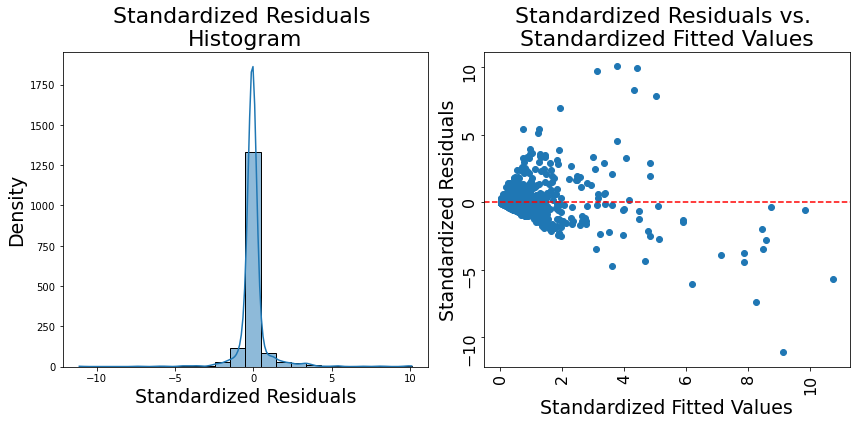

In [106]:
# Calculate the residuals of the model
residuals = uncosim_Ordinary.resid_response

# Calculate standardized residuals
std_residuals = residuals / np.std(residuals)

# Calculate standardized predicted values
std_fitted = uncosim_Ordinary.mu / np.std(uncosim_Ordinary.mu)

# Create a canvas with two subplots
plt.figure(figsize=(12, 6))

# Plot a histogram of standardized residuals
plt.subplot(1, 2, 1)
sns.histplot(std_residuals, bins=22, kde=True, color=None, edgecolor='black')
plt.title('Standardized Residuals \nHistogram', fontsize=22)
plt.xlabel('Standardized Residuals', fontsize=19)
plt.ylabel('Density', fontsize=19)

# Plot a scatter plot of standardized predicted values
plt.subplot(1, 2, 2)
plt.scatter(std_fitted, std_residuals, color=None)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal dashed line
plt.title('Standardized Residuals vs. \nStandardized Fitted Values', fontsize=22)
plt.xlabel('Standardized Fitted Values', fontsize=19)
plt.ylabel('Standardized Residuals', fontsize=19)
plt.xticks(rotation=90, fontsize=16) 
plt.yticks(rotation=90, fontsize=16)  

plt.tight_layout()

# Save the image to a local file
plt.savefig('residual_plots_Ordinary.png')

plt.show()

### 4.5 Model performance

#### 4.5.1 Model performance for both holidays and regular days

In [107]:
# Assign the parameter values from the model to appropriate variables
K = uncosim.params[0]
alpha0 = uncosim.params[1]
gamma0 = uncosim.params[2]
alpha1 = uncosim.params[3]
gamma1 = uncosim.params[4]
alpha2 = uncosim.params[5]
gamma2 = uncosim.params[6]
alpha3 = uncosim.params[7]
gamma3 = uncosim.params[8]
alpha4 = uncosim.params[9]
gamma4 = uncosim.params[10]
alpha5 = uncosim.params[11]
gamma5 = uncosim.params[12]
beta = -uncosim.params[13]

df_rg["unconstrainedEst2"] = np.exp(K 
                                       + alpha0*df_rg["log_pop_Orig"] 
                                       + alpha1*df_rg["log_GDPrate_Orig"] 
                                       + alpha2*df_rg["log_houserate_Orig"] 
                                       + alpha3*df_rg["log_education_Orig"] 
                                       + alpha4*df_rg["log_incomerate_Orig"] 
                                       + alpha5*df_rg["log_tourist_Orig"] 
                                       + gamma0*df_rg["log_pop_Dest"] 
                                       + gamma1*df_rg["log_GDPrate_Dest"]
                                       + gamma2*df_rg["log_houserate_Dest"] 
                                       + gamma3*df_rg["log_education_Dest"] 
                                       + gamma4*df_rg["log_incomerate_Dest"]
                                       + gamma5*df_rg["log_tourist_Dest"] 
                                       - beta*df_rg["log_Dist_cert"])

predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
df_rg["fitted"] = predictions_summary_frame["mean"]

In [108]:
uncosim.mu              

array([ 91.15905015, 166.28062653,  14.86833207, ...,  53.46159538,
        20.01315231,  70.23520216])

In [109]:
#df_rg

In [110]:
# Check if the "column_name" column has any missing values
if df_rg['unconstrainedEst2'].isnull().any():
    print("There are missing values in the 'unconstrainedEst2' column.")
else:
    print("There are mo missing values in the 'unconstrainedEst2' column.")


There are mo missing values in the 'unconstrainedEst2' column.


In [111]:
# Round the numbers to avoid getting half-person figures
df_rg["unconstrainedEst2"] = round(df_rg["unconstrainedEst2"], 0)
# convert to integers
df_rg["unconstrainedEst2"] = df_rg["unconstrainedEst2"].astype(int)
# Check if the sum of these estimated numbers is reasonable
sum(df_rg["unconstrainedEst2"])

167766

In [112]:
df_rg.head()

No  OrigCode  OrigCity  DestCode         DestCity  \
1   1    310000  Shanghai    320100          Nanjing   
2   2    310000  Shanghai    320200             Wuxi   
3   3    310000  Shanghai    320300           Xuzhou   
4   4    310000  Shanghai    320400        Changzhou   
5   5    310000  Shanghai    320500  Suzhou(Jiangsu)   

   Standard_deviation_Ordinary  Standard_deviation_holiday  Total_Ordinary  \
1                     0.254373                    0.225765           90.92   
2                     0.274290                    0.378330          129.47   
3                     0.142568                    0.211438           21.72   
4                     0.146421                    0.232436           65.09   
5                     2.893489                    5.292366          944.87   

   Total_holiday    Total  ...  log_houserate_Dest  log_education_Orig  \
1          26.36   117.28  ...           -3.985732            4.158883   
2          38.20   167.67  ...           -0.164221            4.158883   
3           8.78    30.50  ...           -0.628572            4.158883   
4          21.01    86.10  ...           -0.171264            4.158883   
5         244.24  1189.11  ...           -1.424915            4.158883   

   log_education_Dest  log_incomerate_Orig  log_incomerate_Dest  \
1            3.931826            -2.546042            -2.414508   
2            2.564949            -2.546042            -2.417479   
3            2.484907            -2.546042            -2.425291   
4            2.397895            -2.546042            -2.436737   
5            3.258097            -2.546042            -2.483527   

   log_tourist_Orig  log_tourist_Dest  log_Dist_cert  unconstrainedEst2  \
1           4.26268          3.295837       1.005835                 91   
2           4.26268          3.401197       0.365189                166   
3           4.26268          2.995732       1.621456                 15   
4           4.26268          2.564949       0.637113                 67   
5           4.26268          3.688879      -0.169507                820   

       fitted  
1   91.159050  
2  166.280627  
3   14.868332  
4   67.223372  
5  820.269558  

[5 rows x 93 columns]

In [113]:
# Matrix
cdatasubmat2 = df_rg.pivot_table(values ="unconstrainedEst2", index="OrigCity", columns = "DestCity",
                            aggfunc=np.sum, margins=True)
#cdatasubmat2 

In [114]:
def CalcRSqaured(observed, estimated):  
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

In [115]:
def CalcRMSE(observed, estimated):   
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [116]:
CalcRSqaured(df_rg["Total"], df_rg["unconstrainedEst2"])

0.6651619555125627

In [117]:
CalcRMSE(df_rg["Total"], df_rg["unconstrainedEst2"])

130.76

#### 4.5.2 Model performance for holidays 

In [118]:
# Assign the parameter values from the model to appropriate variables
K = uncosim.params[0]
alpha0 = uncosim.params[1]
gamma0 = uncosim.params[2]
alpha1 = uncosim.params[3]
gamma1 = uncosim.params[4]
alpha2 = uncosim.params[5]
gamma2 = uncosim.params[6]
alpha3 = uncosim.params[7]
gamma3 = uncosim.params[8]
alpha4 = uncosim.params[9]
gamma4 = uncosim.params[10]
alpha5 = uncosim.params[11]
gamma5 = uncosim.params[12]
beta = -uncosim.params[13]

df_holiday["unconstrainedEst2"] = np.exp(K 
                                       + alpha0*df_holiday["log_pop_Orig"] 
                                       + alpha1*df_holiday["log_GDPrate_Orig"] 
                                       + alpha2*df_holiday["log_houserate_Orig"] 
                                       + alpha3*df_holiday["log_education_Orig"] 
                                       + alpha4*df_holiday["log_incomerate_Orig"] 
                                       + alpha5*df_holiday["log_tourist_Orig"] 
                                       + gamma0*df_holiday["log_pop_Dest"] 
                                       + gamma1*df_holiday["log_GDPrate_Dest"]
                                       + gamma2*df_holiday["log_houserate_Dest"] 
                                       + gamma3*df_holiday["log_education_Dest"] 
                                       + gamma4*df_holiday["log_incomerate_Dest"]
                                       + gamma5*df_holiday["log_tourist_Dest"] 
                                       - beta*df_holiday["log_Dist_cert"])
predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
df_holiday["fitted"] = predictions_summary_frame["mean"]

In [119]:
uncosim.mu             

array([ 91.15905015, 166.28062653,  14.86833207, ...,  53.46159538,
        20.01315231,  70.23520216])

In [120]:
# Round the numbers to avoid getting half-person figures
df_holiday["unconstrainedEst2"] = round(df_holiday["unconstrainedEst2"], 0)
# convert to integers
df_holiday["unconstrainedEst2"] = df_holiday["unconstrainedEst2"].astype(int)
# Check if the sum of these estimated numbers is reasonable
sum(df_holiday["unconstrainedEst2"])

167766

In [121]:
# Matrix
cdatasubmat2 = df_holiday.pivot_table(values ="unconstrainedEst2", index="OrigCity", columns = "DestCity",
                            aggfunc=np.sum, margins=True)
#cdatasubmat2

In [122]:
CalcRSqaured(df_holiday["Total_holiday"], df_holiday["unconstrainedEst2"])

0.630152479237482

In [123]:
CalcRMSE(df_holiday["Total_holiday"], df_holiday["unconstrainedEst2"])

179.4

#### 4.5.3 Model performance for regular days

In [124]:
# Assign the parameter values from the model to appropriate variables
K = uncosim.params[0]
alpha0 = uncosim.params[1]
gamma0 = uncosim.params[2]
alpha1 = uncosim.params[3]
gamma1 = uncosim.params[4]
alpha2 = uncosim.params[5]
gamma2 = uncosim.params[6]
alpha3 = uncosim.params[7]
gamma3 = uncosim.params[8]
alpha4 = uncosim.params[9]
gamma4 = uncosim.params[10]
alpha5 = uncosim.params[11]
gamma5 = uncosim.params[12]
beta = -uncosim.params[13]

df_Ordinary["unconstrainedEst2"] = np.exp(K 
                                       + alpha0*df_Ordinary["log_pop_Orig"] 
                                       + alpha1*df_Ordinary["log_GDPrate_Orig"] 
                                       + alpha2*df_Ordinary["log_houserate_Orig"] 
                                       + alpha3*df_Ordinary["log_education_Orig"] 
                                       + alpha4*df_Ordinary["log_incomerate_Orig"] 
                                       + alpha5*df_Ordinary["log_tourist_Orig"] 
                                       + gamma0*df_Ordinary["log_pop_Dest"] 
                                       + gamma1*df_Ordinary["log_GDPrate_Dest"]
                                       + gamma2*df_Ordinary["log_houserate_Dest"] 
                                       + gamma3*df_Ordinary["log_education_Dest"] 
                                       + gamma4*df_Ordinary["log_incomerate_Dest"]
                                       + gamma5*df_Ordinary["log_tourist_Dest"] 
                                       - beta*df_Ordinary["log_Dist_cert"])

predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
df_Ordinary["fitted"] = predictions_summary_frame["mean"]

In [125]:
uncosim.mu          

array([ 91.15905015, 166.28062653,  14.86833207, ...,  53.46159538,
        20.01315231,  70.23520216])

In [126]:
# Round the numbers to avoid getting half-person figures
df_Ordinary["unconstrainedEst2"] = round(df_Ordinary["unconstrainedEst2"], 0)
# convert to integers
df_Ordinary["unconstrainedEst2"] = df_Ordinary["unconstrainedEst2"].astype(int)
# Check if the sum of these estimated numbers is reasonable
sum(df_Ordinary["unconstrainedEst2"])

167766

In [127]:
# Matrix
cdatasubmat2 = df_Ordinary.pivot_table(values ="unconstrainedEst2", index="OrigCity", columns = "DestCity",
                            aggfunc=np.sum, margins=True)
#datasubmat2  

In [128]:
CalcRSqaured(df_Ordinary["Total_Ordinary"], df_Ordinary["unconstrainedEst2"])

0.672671020263231

In [129]:
CalcRMSE(df_Ordinary["Total_Ordinary"], df_Ordinary["unconstrainedEst2"])

118.751

## 5. Community detection

### 5.1 Regular days

In [130]:
#df

In [131]:
G = nx.from_pandas_edgelist(df_compare,source='OrigCity',target='DestCity',edge_attr='Total_Ordinary',create_using=nx.Graph)

random.seed(1000)
np.random.seed(140)

In [132]:
pt = community_louvain.best_partition(G,weight='Total_Ordinary')
pt

{'Shanghai': 2,
 'Nanjing': 4,
 'Wuxi': 2,
 'Xuzhou': 3,
 'Changzhou': 2,
 'Suzhou(Jiangsu)': 2,
 'Nantong': 2,
 'Lianyungang': 2,
 'Huaian': 2,
 'Yancheng': 2,
 'Yangzhou': 2,
 'Zhenjiang': 4,
 'Taizhou(Jiangsu)': 2,
 'Suqian': 2,
 'Hangzhou': 0,
 'Ningbo': 0,
 'Wenzhou': 0,
 'Jiaxing': 0,
 'Huzhou': 0,
 'Shaoxing': 0,
 'Jinhua': 0,
 'Quzhou': 0,
 'Zhoushan': 0,
 'Taizhou(Zhejiang)': 0,
 'Lishui': 0,
 'Hefei': 1,
 'Wuhu': 4,
 'Bengbu': 1,
 'Huainan': 1,
 'Maanshan': 4,
 'Huaibei': 3,
 'Tongling': 1,
 'Anqing': 1,
 'Huangshan': 1,
 'Chuzhou': 4,
 'Fuyang': 1,
 'Suzhou(Anhui)': 3,
 'Luan': 1,
 'Bozhou': 1,
 'Chizhou': 1,
 'Xuancheng': 4}

In [133]:
ply.head()

code       city                                           geometry  \
0  310000   Shanghai  MULTIPOLYGON (((1447289.228 3473963.606, 14455...   
1  320100    Nanjing  MULTIPOLYGON (((1259232.421 3620497.258, 12573...   
2  320200       Wuxi  POLYGON ((1314624.309 3478765.675, 1315477.030...   
3  320300     Xuzhou  POLYGON ((1181307.591 3835436.272, 1182078.880...   
4  320400  Changzhou  POLYGON ((1354069.962 3572647.934, 1352852.641...   

                    Centroids    color  
0  POINT (121.48663 31.20863)  #FF8888  
1  POINT (118.84816 31.92578)  #8888FF  
2  POINT (120.08033 31.52198)  #8888FF  
3  POINT (117.52264 34.35425)  #8888FF  
4  POINT (119.64157 31.62297)  #8888FF

In [134]:
ply['region'] = ply['city'].map(pt)+1 
ply.head()

code       city                                           geometry  \
0  310000   Shanghai  MULTIPOLYGON (((1447289.228 3473963.606, 14455...   
1  320100    Nanjing  MULTIPOLYGON (((1259232.421 3620497.258, 12573...   
2  320200       Wuxi  POLYGON ((1314624.309 3478765.675, 1315477.030...   
3  320300     Xuzhou  POLYGON ((1181307.591 3835436.272, 1182078.880...   
4  320400  Changzhou  POLYGON ((1354069.962 3572647.934, 1352852.641...   

                    Centroids    color  region  
0  POINT (121.48663 31.20863)  #FF8888       3  
1  POINT (118.84816 31.92578)  #8888FF       5  
2  POINT (120.08033 31.52198)  #8888FF       3  
3  POINT (117.52264 34.35425)  #8888FF       4  
4  POINT (119.64157 31.62297)  #8888FF       3

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: SimSun
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: SimSun


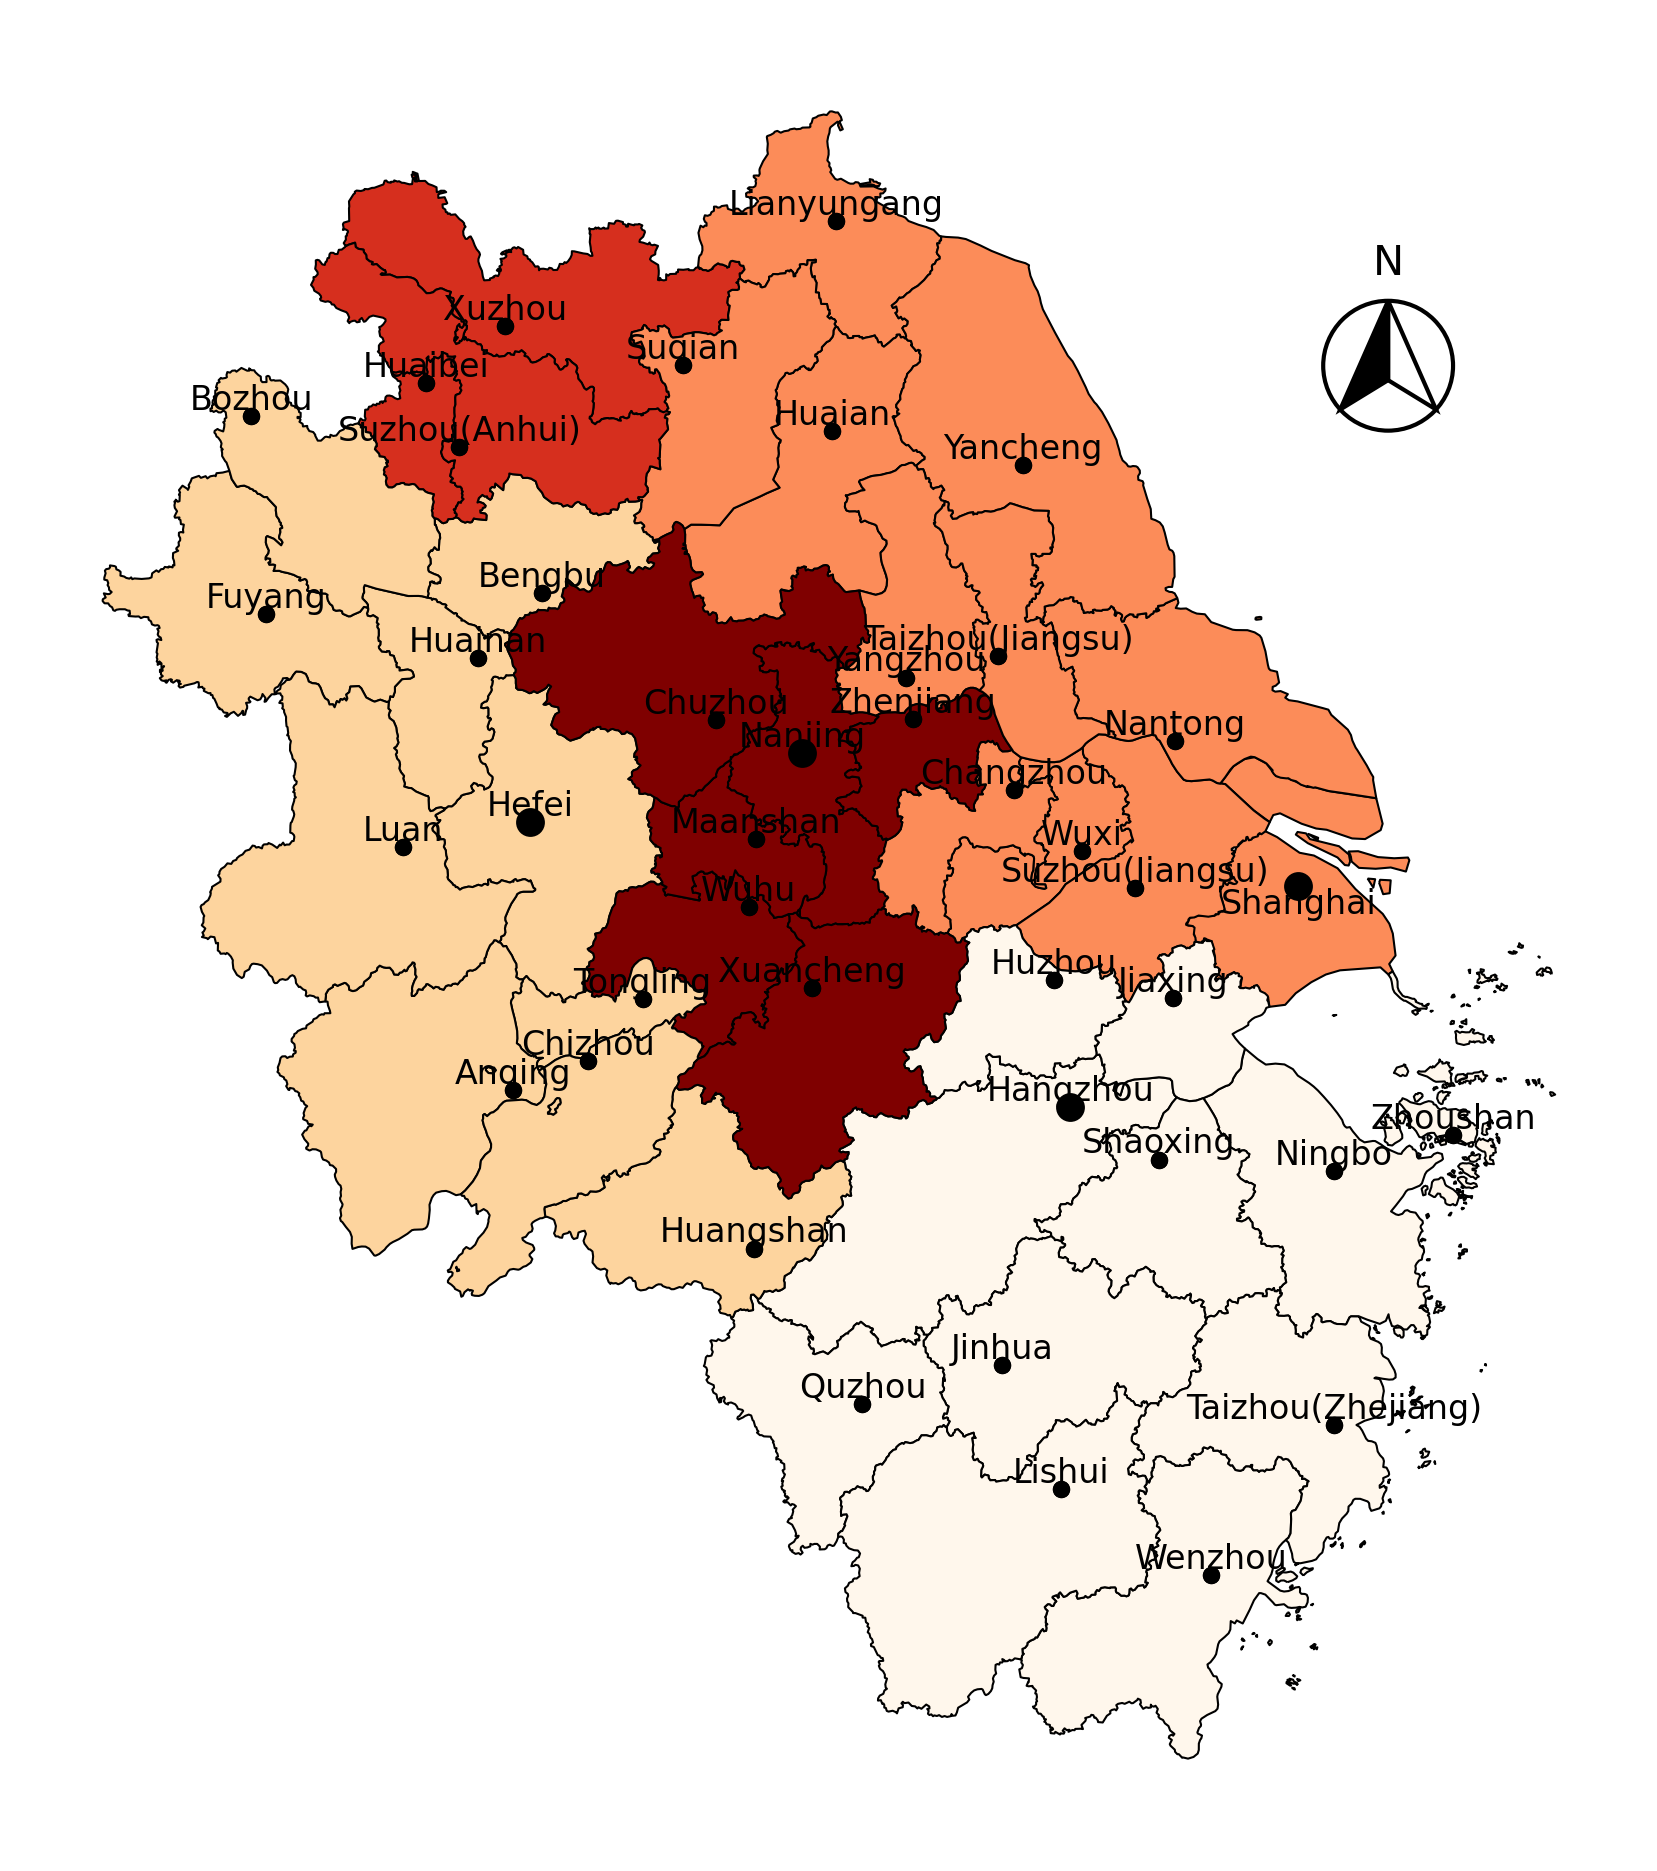

In [135]:
config = {
    "font.family": 'serif', 
    "font.size": 12, 
    "font.serif": ['SimSun'], 
    "mathtext.fontset": 'stix', 
    'axes.unicode_minus': False 
}
rcParams.update(config)

fig  = plt.figure(1,(8,8),dpi = 300)      
ax   = plt.subplot(111)

point = gpd.read_file('data/points_shp/points.shp')
point = point.to_crs(epsg=32649)
ply = ply.to_crs(epsg=32649)

# Get a color mapping object
cmap = plt.get_cmap('OrRd')

ply.plot(ax=ax, column='region', scheme='equalinterval', cmap=cmap, edgecolor='k', lw=0.5,
         )

point.plot(ax=ax, color='black', edgecolor='black', markersize=10, zorder=10)

ax.axis('off')


# Set individual city sizes
highlight_cities = ['Hangzhou', 'Nanjing', 'Shanghai', 'Hefei']
highlight_points = point[point['city'].isin(highlight_cities)]

# Plot highlighted points, and set different sizes and z-order values
highlight_points.plot(ax=ax, marker='o', color="black", markersize=35, zorder=10)

# Plot regular points
point[~point['city'].isin(highlight_cities)].plot(ax=ax, marker='o', color="black", markersize=10, zorder=10)

# Display city names on each point
for point, label in zip(point.geometry, point['city']):
    x, y = point.x, point.y

    # Check if the city is one that should be displayed separately
    if label == 'Shanghai': 
        plt.text(x, y - 90, label, fontsize=8, ha='center', va='top') 
    else:
        plt.text(x, y + 90, label, fontsize=8, ha='center', va='bottom')

# Add a north arrow
x = 0.85 
y = 0.85 
add_north(ax, x, y, text_size=10, arrow_width=0.06, arrow_height=0.06)

plt.savefig('Community_detection_Ordinary.jpg',dpi = 300) 
plt.show()

### 5.2 Holiday

In [136]:
G = nx.from_pandas_edgelist(df_compare,source='OrigCity',target='DestCity',edge_attr='Total_holiday',create_using=nx.Graph)

random.seed(1000)
np.random.seed(140)

In [137]:
pt = community_louvain.best_partition(G,weight='Total_holiday')
pt

{'Shanghai': 0,
 'Nanjing': 0,
 'Wuxi': 0,
 'Xuzhou': 0,
 'Changzhou': 0,
 'Suzhou(Jiangsu)': 0,
 'Nantong': 0,
 'Lianyungang': 0,
 'Huaian': 0,
 'Yancheng': 0,
 'Yangzhou': 0,
 'Zhenjiang': 0,
 'Taizhou(Jiangsu)': 0,
 'Suqian': 0,
 'Hangzhou': 1,
 'Ningbo': 1,
 'Wenzhou': 1,
 'Jiaxing': 1,
 'Huzhou': 1,
 'Shaoxing': 1,
 'Jinhua': 1,
 'Quzhou': 1,
 'Zhoushan': 1,
 'Taizhou(Zhejiang)': 1,
 'Lishui': 1,
 'Hefei': 2,
 'Wuhu': 2,
 'Bengbu': 2,
 'Huainan': 2,
 'Maanshan': 2,
 'Huaibei': 2,
 'Tongling': 2,
 'Anqing': 2,
 'Huangshan': 2,
 'Chuzhou': 2,
 'Fuyang': 2,
 'Suzhou(Anhui)': 2,
 'Luan': 2,
 'Bozhou': 2,
 'Chizhou': 2,
 'Xuancheng': 2}

In [138]:
ply.head()

code       city                                           geometry  \
0  310000   Shanghai  MULTIPOLYGON (((1447289.228 3473963.606, 14455...   
1  320100    Nanjing  MULTIPOLYGON (((1259232.421 3620497.258, 12573...   
2  320200       Wuxi  POLYGON ((1314624.309 3478765.675, 1315477.030...   
3  320300     Xuzhou  POLYGON ((1181307.591 3835436.272, 1182078.880...   
4  320400  Changzhou  POLYGON ((1354069.962 3572647.934, 1352852.641...   

                    Centroids    color  region  
0  POINT (121.48663 31.20863)  #FF8888       3  
1  POINT (118.84816 31.92578)  #8888FF       5  
2  POINT (120.08033 31.52198)  #8888FF       3  
3  POINT (117.52264 34.35425)  #8888FF       4  
4  POINT (119.64157 31.62297)  #8888FF       3

In [139]:
ply['region'] = ply['city'].map(pt)+1 
ply.head()

code       city                                           geometry  \
0  310000   Shanghai  MULTIPOLYGON (((1447289.228 3473963.606, 14455...   
1  320100    Nanjing  MULTIPOLYGON (((1259232.421 3620497.258, 12573...   
2  320200       Wuxi  POLYGON ((1314624.309 3478765.675, 1315477.030...   
3  320300     Xuzhou  POLYGON ((1181307.591 3835436.272, 1182078.880...   
4  320400  Changzhou  POLYGON ((1354069.962 3572647.934, 1352852.641...   

                    Centroids    color  region  
0  POINT (121.48663 31.20863)  #FF8888       1  
1  POINT (118.84816 31.92578)  #8888FF       1  
2  POINT (120.08033 31.52198)  #8888FF       1  
3  POINT (117.52264 34.35425)  #8888FF       1  
4  POINT (119.64157 31.62297)  #8888FF       1

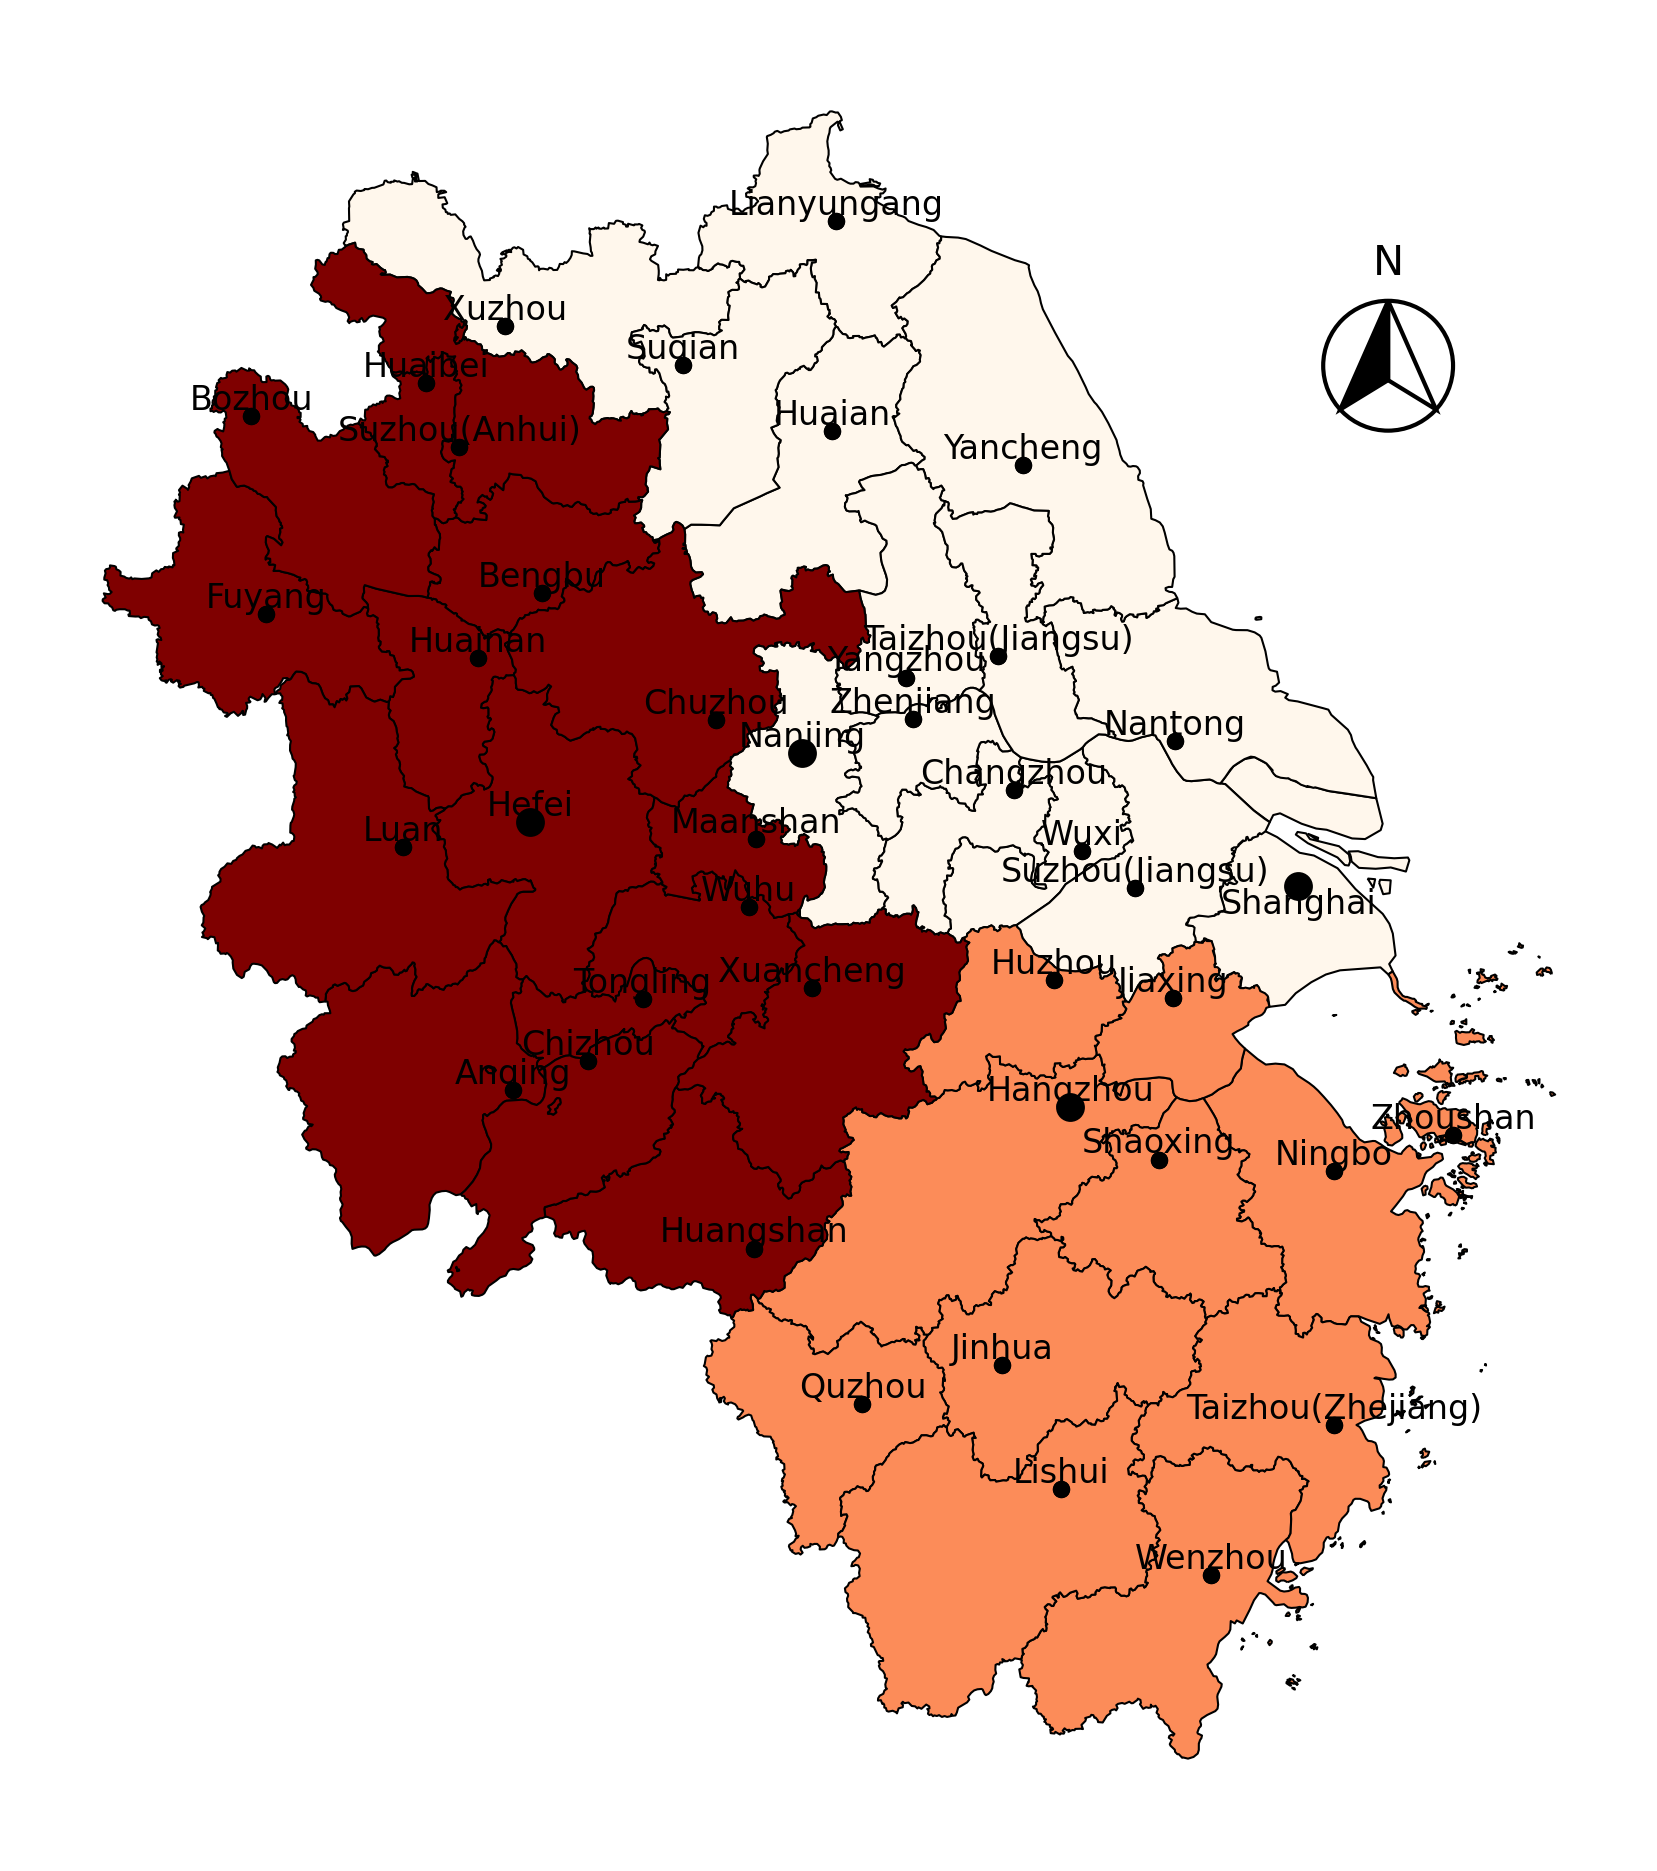

In [140]:
config = {
    "font.family": 'serif', 
    "font.size": 12, 
    "font.serif": ['SimSun'], 
    "mathtext.fontset": 'stix',
    'axes.unicode_minus': False
}
rcParams.update(config)

fig  = plt.figure(1,(8,8),dpi = 300)      
ax   = plt.subplot(111)

point = gpd.read_file('data/points_shp/points.shp')
point = point.to_crs(epsg=32649)
ply = ply.to_crs(epsg=32649)

# Get a color mapping object
cmap = plt.get_cmap('OrRd')

ply.plot(ax=ax, column='region', scheme='equalinterval', cmap=cmap, edgecolor='k', lw=0.5,
         )

point.plot(ax=ax, color='black', edgecolor='black', markersize=10, zorder=10)

ax.axis('off')

# Set individual city sizes
highlight_cities = ['Hangzhou', 'Nanjing', 'Shanghai', 'Hefei']
highlight_points = point[point['city'].isin(highlight_cities)]

# Plot highlighted points, and set different sizes and z-order values
highlight_points.plot(ax=ax, marker='o', color="black", markersize=35, zorder=10)

# Plot regular points
point[~point['city'].isin(highlight_cities)].plot(ax=ax, marker='o', color="black", markersize=10, zorder=10)

# Display city names on each point
for point, label in zip(point.geometry, point['city']):
    x, y = point.x, point.y

     # Check if the city is one that should be displayed separately.
    if label == 'Shanghai':  
        plt.text(x, y - 90, label, fontsize=8, ha='center', va='top')  
    else:
        plt.text(x, y + 90, label, fontsize=8, ha='center', va='bottom')

# Add a north arrow
x = 0.85  
y = 0.85 
add_north(ax, x, y, text_size=10, arrow_width=0.06, arrow_height=0.06)

plt.savefig('Community_detection_holiday.jpg',dpi = 300) 
plt.show()